In [1]:
from tools_stance import * 
from models import *
from transformer_class import *
from keras.layers import Conv1D, Conv2D, MaxPooling1D, Input
from keras.models import Model
from keras.layers import LSTM,GRU,Dense
from keras.utils import Sequence,to_categorical
from keras.preprocessing.sequence import pad_sequences
import os 
import torch 
import gc
import pandas as pd

keras.losses.focal_loss=keras.losses.MSE
keras.losses.focal_loss_fixed=keras.losses.MSE

n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('There are',torch.cuda.device_count(),'GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

dict_cl=dict()
dict_cl[0]="support"
dict_cl[1]="denying"
dict_cl[2]="questioning"
dict_cl[3]="commenting"

#sdqc
d_lab=dict()
d_lab["support"]=0
d_lab["denying"]=1
d_lab["questioning"]=2
d_lab["commenting"]=3

keys=["commenting", "support", "denying", "questioning"]

path="../../../Datasets/CSV_Stance/"
train =pd.read_csv(path + "train_semeval_raw.csv")
val=pd.read_csv(path + "dev_semeval_raw.csv")
test=pd.read_csv(path + "test_semeval_raw.csv")

stoplist = stopwords.words("english")
puntos='!?."()[´]“<>¡¿-/;:=_”@#.'

def cleaner(post): 
    s= re.sub(r"http\S+", " html ", post)   ##########elimina http    
    s= re.sub(r'#\w+ ?', " hashtag ", s) ########3
    s= re.sub(r'@\w+ ?', " user ", s)##############    
    s= s.lower()
    s=emoji_pattern.sub(r'', s)
    s=re.sub(r"'\b", " ' ", s)
    s=re.sub(r"\b'\b", " ' ", s)
    s=re.sub(r"“\b", " “ ", s)
    s=re.sub(r"\b’", " ’ ", s)
    s=re.sub(r"‘\b", " ‘ ", s)
    s=re.sub(r"\b’\b", " ‘ ", s)
    s = re.sub(r"-", " - ", s)
    s = re.sub(r"\(", " ", s)
    s = re.sub(r"\)", " ", s)
    s = re.sub(r"\?", " ? ", s)    
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"' ", " ' ", s)
    s = re.sub(r" '", " ' ", s)
    s = re.sub(r"\!", " ! ", s)
    s=re.sub("[\.]+", " . ", s)
    s=re.sub("[\,]+", " , ", s)
    s=re.sub("[\;]+", " ; ", s)
    s=re.sub("[\:]+", " : ", s)
    s=re.sub('[\"]+', ' " ', s)
    s=re.sub(r'\b[0-9]\b', " number ",  s)
    s=re.sub(r'\b[0-9]*[0-9]\b', " number ",  s)    
    s=re.sub(r'\b”', ' " ', s)
    sl= list(s.split())
    sl_2=[]
    for wd in sl:
        try: 
            q=token_2_idx[wd]
            sl_2.append(wd)
        except:
            try: 
                if stemmer.stem(wd) in token_2_idx.keys():
                    sl_2.append(stemmer.stem(wd))
                elif lemmatizer.lemmatize(wd) in token_2_idx.keys():
                    sl_2.append(lemmatizer.lemmatize(wd))
                else:
                    sl_2.append(wd)
            except:
                sl_2.append(wd)
    sl=sl_2
    s=' '.join([word for word in sl])# if word not in stoplist])
    return s, sl


embeddings_index = {}
token_2_idx={}
idx_2_token={}
f = open(os.path.join("../../../Datasets/glove.twitter.27B.200d.txt"))#'glove.twitter.27B.100d.txt'))
i=0
for line in f:
    values = line.split()
    if len(values)>200:
        word = values[0]
    else:
        continue
    token_2_idx[word]=i
    idx_2_token[i]=word
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    i+=1
f.close()

MAX_LEN = 37
emb=200
EMB_matrix=np.zeros((len(token_2_idx.keys()), emb))
for i in range(len(token_2_idx.keys())):
    EMB_matrix[i]=embeddings_index[idx_2_token[i]]
    
transformer = Normalizer().fit(EMB_matrix) 
EMB_matrix=transformer.transform(EMB_matrix)
EMB_matrix.shape

Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1060 6GB


(1193513, 200)

In [2]:
def cm_norma(matrix):
    return matrix/matrix.sum(axis=-1, keepdims=True)

def plot_cm(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    
    import itertools
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
        
    thresh = cm.max() / 2.# if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.3f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def match(objetos,ejemplo):
    i=0
    for obj in objetos:
        if obj==ejemplo:
            return i
        i+=1
        
def data_gen(batch_size,mode,n_machines,new_matrix, matrix, matrix_val, matrix_test, lab_str_embeddings, index_embeddings):  
    """ESTA FUNCION DEBERÁ RETORNAR MATRICES DE TAMAÑO BATCH_SIZE * TW,M1,M2,M3,M4,M5,M6
    CADA EJEMPLO DEBERÁ SER ESTILO [ID_T, 1,2,1,2,1,2] SIENDO 1 CUANDO LA CLASE PREDICHA ES LA 0
    2 PARA CLASE PREDICHA 1, ETC. ID_T DEBEŔA INICIAR EN 5 PARA REFERIRSE AL PRIMER TW (EL PRIMERO DE TRAIN)"""
    x_data=[] 
    y_data=[]
    if mode=='Train':
        max_objs=matrix.shape[1]
        x_list=np.arange(max_objs)
        np.random.shuffle(x_list)        #indices desordenados de seccion train
        objs=ids_train
        labels=etiq     #np.load("matrices/y_train_num_4.npy")
        labels=np.asarray(labels) #+ np.ones(labels.shape),dtype='uint8')
    if mode=='Val':
        max_objs=matrix_val.shape[1] 
        x_list=np.arange(max_objs)
        x_list=[x+matrix.shape[1] for x in x_list]   
        #np.random.shuffle(x_list)        #indices desordenados de seccion val
        objs=val['Tw_id']    #df_val['Unnamed: 0'].values        
        labels=np.asarray(etiq_v)     #np.load("matrices/y_val_num_4.npy")
        labels=np.asarray(labels) #+ np.ones(labels.shape),dtype='uint8') 
    if mode=='Test':
        max_objs=matrix_test.shape[1] 
        x_list=np.arange(max_objs)
        x_list=[x+matrix.shape[1]+matrix_val.shape[1] for x in x_list]
        total=matrix.shape[1]+matrix_val.shape[1]
        objs=test['Tw_id']     #np.arange(total, total+max_objs)
        
    #----------------------------------- COMPLETA MINI BATCHES ----------------------    
    if len(x_list)%batch_size==0:
        n_batches=len(x_list)/batch_size
        for nb in range(n_batches): 
            x_data.append(x_list[nb*batch_size:(nb+1)*batch_size])
    else:
        n_batches=int(len(x_list)/batch_size)
        resto=int(len(x_list)-n_batches*batch_size)
        to_repeat=batch_size-resto        
        for nb in range(n_batches): 
            x_data.append(x_list[nb*batch_size:(nb+1)*batch_size])
        cola=list(x_list[(nb+1)*batch_size:])
        for i in range(to_repeat):
            indice= np.random.randint(len(x_list))
            cola.append(x_list[indice])
        x_data.append(np.asarray(cola))
        if mode=='Test':
            print ("SE TUVIERON QUE REPETIR", to_repeat, "EJEMPLOS")
    #print ("los indices de train k voy a acceder random son", x_data[0])
            
    #-------------------------------- CONSTRUCCION MINI BATCHES (X,Y)----------------------   
    new_x_data=[] 
    for batch in x_data:
        #print ("transformando batch", batch)
        temp=[]
        for pos in batch:
            #print("en especifico el numerito", pos)
            temp2=[index_embeddings[pos+5]]#fromId2num[objs[exam]]] ### obj evaluado en maquinas  
            #print ("me dice que es el embed en index", temp2)
            for m in range(n_machines): 
                #print ("machine ",m,"dice:", np.argmax(new_matrix[m][pos])+1)
                temp2= temp2 + [np.argmax(new_matrix[m][pos])+1] 
                #matrix[4][cosa-5])+1)
            temp.append(temp2)
        new_x_data.append(temp)   

    if mode=='Train' or mode=='Val':    
        y_data=[]
        for conjunto in range(len(new_x_data)):
            batch=new_x_data[conjunto]
            temp_y=[]
            for linea in range(len(batch)):
                indice=x_data[conjunto][linea]  #pos
                lab=d_lab[lab_str_embeddings[indice+5]]+1 #labels_train
                temp_y.append([lab])       
            y_data.append(temp_y)
            
        y_data=np.asarray(y_data)
        
    new_x_data=np.asarray(new_x_data)
    pok=True
    #print ("primer batch X.Y", new_x_data[0], y_data[0])
    if mode=='Test':
        for x in new_x_data:
            if pok: 
                print("x", x, "\n\ny", y)
                pok=False
            src = Variable(torch.from_numpy(np.asarray(x)), requires_grad=False)
            yield Batch(src, None, 0)        
    else:          
        for x,y in zip(new_x_data, y_data):
            src = Variable(torch.from_numpy(np.asarray(x)), requires_grad=False)
            har = Variable(torch.from_numpy(np.asarray(y)), requires_grad=False)
            yield Batch(src, har, 0)
            

def make_model_concat(target, K_list_new, N=2, d_model=768, d_ff=1024, h=4, dropout=0.3, soft=True):  #recibir src_vocab si lo utiliza dummy_Emb
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalText_concat(d_model, dropout)
    if soft:
        print ("Creando modelo con salida Softmax")
        model = EncoderDecoderSoft(
            Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
            nn.Sequential(Dummy_Embeddings(d_model, K_list_new), c(position)),
            nn.Linear(d_model, 4))
    else:
        print ("")
        print ("Creando modelo con salida Log_softmax")
        model = EncoderDecoderLogSoft(
            Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
            nn.Sequential(Dummy_Embeddings(d_model, K_list_new), c(position)),
            nn.Linear(d_model, 4))

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

def run_epoch(data_iter, model, loss_compute, mode):
    if mode=='Test':
        with torch.no_grad():
            start = time.time()
            pred_classes=[]
            for i, batch in enumerate(data_iter):
                rint ("BATCH\n", i, 'src\n', batch.src, 'size\n', batch.src.size())
                out = model.forward(batch.src, batch.src_mask)
                pred_classes.append(out.argmax(dim=-1).numpy())
                #la loss del batch es sobre todos los ejemplos o es promedio en batch?
            return pred_classes
    
    else:
        start = time.time()
        total_learners = 0
        total_datos = 0
        total_loss = 0
        total_acc=0
        total_fm1=0
        total_fs=0
        n_batches = 0
        cm_last=np.zeros((4,4))
        for i, batch in enumerate(data_iter):            
            out = model.forward(batch.src, batch.src_mask)
            print ("out en run epoch", out)
            loss,acc,f1,cm = loss_compute(out, batch.trg_y, batch.ntokens, mode)
            print ("loss, acc , f1", loss, acc, f1)
            cm_last+=cm
            f_ma=np.mean(f1)
            total_loss += loss
            total_acc += np.array(acc)
            total_fm1 += np.sum(f1)/4.0    #4 clases (macro)
            total_fs += f1                 #none  
            total_datos += batch.ntokens
            n_batches += 1
        return total_loss/n_batches, torch.from_numpy(np.array(total_acc))/n_batches, torch.from_numpy(np.array(total_fm1))/n_batches, torch.from_numpy(np.array(total_fs))/n_batches, cm_last

def predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, name_model):
    etiq = etiq.astype("int")
    trainPredict = trained.predict(x_train, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq, trainPredict)  
    f1=f1_score(etiq, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=cm_norma(confusion_matrix(etiq, trainPredict))
    """print ("")
    print ("------ Training ------")
    print ("Accuracy", name_model, ": %.3f" % acc)     
    print ("F1-score macro", name_model, ": %.3f" % f1_ma)
    np.set_printoptions(precision=3)
    print ("F1-score None", name_model, ":", f1)"""
    
    ########################################
    trainPredict = trained.predict(x_val, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq_v, trainPredict)  
    f1=f1_score(etiq_v, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq_v, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=cm_norma(confusion_matrix(etiq_v, trainPredict))
    """print ("")
    print ("------ Validation ------")
    print ("Accuracy", name_model, ": %.3f" % acc)     
    print ("F1-score macro", name_model, ": %.3f" % f1_ma)
    np.set_printoptions(precision=3)
    print ("F1-score None", name_model, ":", f1)"""
    ########################################
    trainPredict = trained.predict(x_test, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc_t= accuracy_score(etiq_t, trainPredict)  
    f1_t=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma_t=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    matriz_t=cm_norma(confusion_matrix(etiq_t, trainPredict))
    print ("")
    print ("------ Testing ------")
    print ("Accuracy", name_model, ": %.3f" % acc_t)     
    print ("F1-score macro", name_model, ": %.3f" % f1_ma_t)
    np.set_printoptions(precision=3)
    print ("F1-score None", name_model, ":", f1_t)
    
    return f1_ma_t, f1_t, acc_t, matriz_t

In [3]:
MAX_LEN = 37
emb=200
EMB_matrix=np.zeros((len(token_2_idx.keys()), emb))
for i in range(len(token_2_idx.keys())):
    EMB_matrix[i]=embeddings_index[idx_2_token[i]]
    
transformer = Normalizer().fit(EMB_matrix) 
EMB_matrix=transformer.transform(EMB_matrix)
    
ids_train=train['Tw_id']
tws_train=train['Tweet']
labels_train=[d_lab[lb] for lb in train['Label']]
#class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
class_weights= np.asarray([1.0, 1.0, 1.0, 1.0])
print ("Pesos de clases:", class_weights)

ids_val=val['Tw_id']
tws_val=val['Tweet']
labels_val=[d_lab[lb] for lb in val['Label']]

ids_test=test['Tw_id']
tws_test=test['Tweet']
labels_test=[d_lab[lb] for lb in test['Label']]

sentences = tws_train
n_labels = np.asarray(labels_train)
y_train=to_categorical(n_labels,num_classes=4)

sentences_val = tws_val
n_labels_val = np.array(labels_val)
y_val=to_categorical(n_labels_val,num_classes=4)

sentences_test = tws_test
n_labels_test = np.array(labels_test)
y_test=to_categorical(n_labels_test,num_classes=4)

input_ids=[]
for sent in sentences:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids.append(encoded_sent) 
    
input_ids_val=[]
for sent in sentences_val:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids_val.append(encoded_sent) 

input_ids_test=[]
for sent in sentences_test:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids_test.append(encoded_sent) 
    

Pesos de clases: [1. 1. 1. 1.]


In [4]:
input_ids = pad_sequences(input_ids,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_val = pad_sequences(input_ids_val,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_test = pad_sequences(input_ids_test,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")

shape=np.asarray(input_ids).shape
shape_val=np.asarray(input_ids_val).shape
shape_test=np.asarray(input_ids_test).shape

x_train=np.zeros((shape[0], shape[1], emb))
j=0
for in_id in input_ids:
    x_train[j]=EMB_matrix[in_id]
    j+=1
    
x_val=np.zeros((shape_val[0], shape_val[1], emb))
i=0
for in_id in input_ids_val:
    x_val[i]=EMB_matrix[in_id]
    i+=1
    
x_test=np.zeros((shape_test[0], shape_test[1], emb))
i=0
for in_id in input_ids_test:
    x_test[i]=EMB_matrix[in_id]
    i+=1

In [5]:
path_m='../../../Datasets/Models_Stance/'

etiq=np.asarray(labels_train)
etiq_v=np.asarray(labels_val)
etiq_t=np.asarray(labels_test)

In [6]:
from bert_serving.client import BertClient
import seaborn 

def draw(data, ax, label, color="Blues"):
    seaborn.heatmap(data, 
                    xticklabels=label[0], square=True, yticklabels=label[0], vmin=0.0, vmax=1.0, 
                    cbar=False,  cmap=color, ax=ax)

#sns.heatmap(matriz_attn, xticklabels=label[0], yticklabels=label[0],
#                    vmin=0.0, vmax=1.0, linewidths=.5, cmap="Blues", cbar=False, square=True, ax=axs[head]) #, annot=False,cbar_kws={"orientation": "horizontal","pad": 0.25})
#    plt.show()
    
bc = BertClient()  

In [7]:
n_machines=5

In [8]:
global_accs=[]
global_fnones=[]
global_fmacros=[]
global_cms=[]
global_attn=[]
best_macro={'F_ma':0.1 , 'Run':0}

dict_attn_enc={'00':[], '01':[], '02':[], '03':[], '10':[], '11':[], '12':[], '13':[]}
  
prob=0.0
bs=32

for x in range(1,2): 
    print ("Entrenando Run #", x)
    cnn1 = load_model(path_m+str(prob)+'/cnn1_'+str(x)+'-exec.h5')
    cnn2 = load_model(path_m+str(prob)+'/cnn2_'+str(x)+'-exec.h5')
    rnn1 = load_model(path_m+str(prob)+'/rnn1_'+str(x)+'-exec.h5')
    rnn2 = load_model(path_m+str(prob)+'/rnn2_'+str(x)+'-exec.h5')
    rnn3 = load_model(path_m+str(prob)+'/rnn3_'+str(x)+'-exec.h5')

    list_models=['cnn1', 'cnn2', 'rnn1', 'rnn2', 'rnn3']
    index_models=np.arange(5)
    dict_models=dict((key, value) for (key, value) in zip(index_models,list_models))
    modelos=[cnn1, cnn2, rnn1, rnn2, rnn3]
    ind=np.arange(5)
    dict_trainedModel=dict((key, value) for (key, value) in zip(ind,modelos))

    predicciones_all=[]
    predicciones_all_val=[]
    predicciones_all_test=[]
    
    print ("agregando predicciones Train")
    for i in dict_trainedModel.keys(): 
        a_evaluar=dict_models[i]
        predicciones_all.append(dict_trainedModel[i].predict(x_train, batch_size=bs))
    print ("agregando predicciones Val")
    for i in dict_trainedModel.keys(): 
        a_evaluar=dict_models[i]
        predicciones_all_val.append(dict_trainedModel[i].predict(x_val, batch_size=bs))
    print ("agregando predicciones Test")
    for i in dict_trainedModel.keys(): 
        a_evaluar=dict_models[i]
        predicciones_all_test.append(dict_trainedModel[i].predict(x_test, batch_size=bs))

    matrix=np.asarray(predicciones_all)
    matrix_val=np.asarray(predicciones_all_val)
    matrix_test=np.asarray(predicciones_all_test)
    new_matrix=np.concatenate([matrix,matrix_val,matrix_test], axis=1)
    
    b_dim=768
    espacio=[np.ones(b_dim)]
    Ks= ortho_group.rvs(dim=b_dim)
    random=np.random.randint(Ks.shape[0], size=4)
    K_list=Ks[random]
    K_list_ext=espacio+list(K_list)
    index_embeddings=[0,1,2,3,4]
    lab_str_embeddings=['','','','','']

    for i in range(len(sentences)):
        #ide=ids_train[i]
        tw_tr=tws_train[i]
        clase=dict_cl[labels_train[i]]
        encoded_tok = cleaner(tw_tr)[0]  #cleaner: raw, no cleaner:augmented version
        vector=bc.encode([encoded_tok])[0]
        final_bert= vector
            
        index_embeddings.append(i+5)
        lab_str_embeddings.append(clase)
        K_list_ext.append(final_bert)
    
    objs_val=val['Tw_id']      #df_val['Unnamed: 0'].values
    objs_test=test['Tw_id']    #np.arange(df_test.shape[0])
    lab_val=val['Label']
    lab_test=test['Label']
    tw_val=val['Tweet']
    tw_test=test['Tweet']
    llaves=np.concatenate([objs_val,objs_test])
    clases=np.concatenate([lab_val,lab_test])
    sent_all=np.concatenate([tw_val,tw_test])
      
    for num in range(len(llaves)):
        i=llaves[num]
        clase=clases[num]
        tw_tr=sent_all[num]
        encoded_tok = cleaner(tw_tr)[0]  #cleaner: raw, no cleaner:augmented version
        vector=bc.encode([encoded_tok])[0]
        final_bert= vector

        index_embeddings.append(num+5+train.shape[0])
        lab_str_embeddings.append(clase)
        K_list_ext.append(final_bert)

    
    K_list_new= np.asarray(K_list_ext, dtype='float32')
    
    ###################################### TRANSFORMER ###############################
    hist_train_loss=[]
    hist_train_acc=[]
    hist_train_fma=[]
    hist_val_loss=[]
    hist_val_acc=[]
    hist_val_fma=[]
    
    V = 4
    pesos = torch.from_numpy(class_weights).float()
    criterion = FocalLoss(weights=pesos)
    model = make_model_concat(4, K_list_new, N=2,d_model=b_dim, d_ff=128, h=4, dropout=0.35)
    model_opt = NoamOpt(model.src_embed[0].d_model,  1, 6000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-5))

    
    for epoch in range(60):
        model.train()
        DATA=data_gen(bs, 'Train', 5, new_matrix)
        loss_train, acc_train,fma_train, f_none, cm_train=run_epoch(DATA, model, SimpleLossComputeFL(criterion, model_opt), 'Train')
        
        model.eval()
        loss_val, acc_val,fma_val, f_val_none, cm_val=run_epoch(data_gen(bs, 'Val', 5, new_matrix), model, SimpleLossComputeFL(criterion, None),'Val')
        if epoch%10==0:
            print ("Epoch",epoch, "\tacc_val: %.3f" % acc_val.numpy(), "\tF-macro_val: %.3f" % fma_val.numpy())
    
    model.eval()
    print ("Testing run #",x)
    predicciones = run_epoch(data_gen(bs, 'Test', 5, new_matrix), model, SimpleLossComputeFL(criterion, None),'Test')
    predicciones=np.concatenate(predicciones, axis=-1)
    
    glo_acc=accuracy_score(etiq_t, predicciones[:-3])
    glo_fno=f1_score(etiq_t,predicciones[:-3], average=None)
    glo_fma=f1_score(etiq_t,predicciones[:-3], average='macro')

    glo_cm=confusion_matrix(etiq_t, predicciones[:-3])

    plot_cm(cm_norma(glo_cm),["S","D","Q","C"],"BERT Sin Aum No Cw")
    global_accs.append(glo_acc)
    global_fnones.append(glo_fno)
    global_fmacros.append(glo_fma)
    global_cms.append(glo_cm)
    print("Test_ acc:",glo_acc) 
    print("Test_ f1 none:",glo_fno) 
    print("Test_ f1 macro:",glo_fma) 

    if glo_fma>best_macro['F_ma']:
        best_macro['F_ma']=glo_fma
        best_macro['Run']=x                
        tope=4520

        for key in keys: 
            mask_s=test["Label"]==key
            q_tid=np.random.choice(test["Tw_id"][mask_s])
            q_ide=list(test["Tw_id"].values).index(q_tid)

            model.eval()

            temp2= [tope + q_ide]

            for m in range(n_machines): 
                temp2= temp2 + [np.argmax(matrix_test[m][q_ide])+1] 

            sent = [temp2]
            src = torch.LongTensor([w for w in sent])
            src = Variable(src)
            src_mask = src_mask=  (src != 0).unsqueeze(-2)
            out = model.forward(src, src_mask)
            print ("\n\nEjemplo de tweet con label ", key, " y Tw_id ", q_tid)
            for layer in range(2):
                fig, axs = plt.subplots(1,4, figsize=(22,11))
                print("Encoder Layer", layer+1)
                for h in range(4):
                    draw(model.encoder.layers[layer].self_attn.attn[0, h].data, 
                        axs[h], sent, cmap="Blues")
                plt.show()

Entrenando Run # 1





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax


TypeError: data_gen() missing 5 required positional arguments: 'matrix', 'matrix_val', 'matrix_test', 'lab_str_embeddings', and 'index_embeddings'

In [18]:
class EncoderDecoderSoft(nn.Module):
    def __init__(self, encoder, src_embed, sequential):
        super(EncoderDecoderSoft, self).__init__()
        self.encoder = encoder
        self.linearSoft = sequential
        self.src_embed = src_embed
        
    def forward(self, src, src_mask):
        print ("\nsrc de encDecSoft", src.size())
        print ("src_mask de encDecSoft", src_mask.size())
        out=self.encode(src, src_mask)
        print ("out de encDecSoft", out.size())
        retorno=self.toSoftmax(out)
        print ("retorno de encDecSoft", retorno.size())
        return retorno
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def toSoftmax(self, tensor):
        a=tensor.size()[0]
        b=tensor.size()[-1]
        c=tensor.size()[-2]
        new_tensor= np.zeros((a, b))
        ini=True
        for ai in range(a):
            for ci in range(c):
                if ini:
                    new_tensor[ai]=tensor.data[ai][ci].numpy()
                    ini=False
                else: 
                    new_tensor[ai]*=tensor.data[ai][ci].numpy()
            ini=True
            
        new_tensor=torch.from_numpy(new_tensor)
        lineal=self.linearSoft(new_tensor.float())
        return F.softmax(lineal, dim = -1)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        print ("\nx en encoder layer", x.size())
        print ("mask en encoder layer", mask.size())
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        print ("x new en encoder layer", x.size())
        retorno = self.sublayer[1](x, self.feed_forward)
        print ("retorno new en encoder layer", retorno.size())
        return retorno
    
    
class Generator(nn.Module):
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)
    
def attention(query, key, value, mask=None, dropout=None):
    d_k = query.size(-1)
    #print ("query", query.size())
    #print ("key.transpose(-2, -1)", key.transpose(-2, -1).size())
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    #print ("scores primero", scores.size())
    #print ("\ndebiese haber sido", torch.matmul(query, key.transpose(-2, -1)).size())
    if mask is not None:
        #print ("MAsk attention", mask.size(), mask.type())
        #print("scores.masked_fill(mask == 0)", scores.masked_fill(mask == 0.000, -1e9).size())
        scores = scores.masked_fill(mask == 0, -1e9)
        #print ("scores", scores.size())
    p_attn = F.softmax(scores, dim = -1)
    #print ("\np_att F soft ", p_attn.size())
    if dropout is not None:
        p_attn = dropout(p_attn)
    #print ("value att", value.size())
    #print ("p_att ", p_attn.size())
    #print ("torch.matmul(p_attn, value)", torch.matmul(p_attn, value).size())
    return torch.matmul(p_attn, value), p_attn


class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        #print ("mask para attn...", mask)
        if mask is not None:
            #print ("\n\nmask.unsqueeze(1)", mask.unsqueeze(1).size())
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        #print ("mask", mask.size() )
        
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [19]:
V = 4
pesos = torch.from_numpy(class_weights).float()
criterion = FocalLoss(weights=pesos)
model = make_model_concat(4, K_list_new, N=2,d_model=b_dim, d_ff=128, h=4, dropout=0.35)
model_opt = NoamOpt(model.src_embed[0].d_model,  1, 6000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-5))


for epoch in range(60):
    model.train()
    #DATA=data_gen(bs, 'Train', 5, new_matrix)
    DATA=data_gen(bs, 'Train', 5, new_matrix, matrix, matrix_val, matrix_test, lab_str_embeddings, index_embeddings) 
    loss_train, acc_train,fma_train, f_none, cm_train=run_epoch(DATA, model, SimpleLossComputeFL(criterion, model_opt), 'Train')

    model.eval()
    loss_val, acc_val,fma_val, f_val_none, cm_val=run_epoch(data_gen(bs, 'Val', 5, new_matrix), model, SimpleLossComputeFL(criterion, None),'Val')
    if epoch%10==0:
        print ("Epoch",epoch, "\tacc_val: %.3f" % acc_val.numpy(), "\tF-macro_val: %.3f" % fma_val.numpy())

model.eval()
print ("Testing run #",x)
predicciones = run_epoch(data_gen(bs, 'Test', 5, new_matrix), model, SimpleLossComputeFL(criterion, None),'Test')
predicciones=np.concatenate(predicciones, axis=-1)

Creando modelo con salida Softmax

src de encDecSoft torch.Size([32, 6])
src_mask de encDecSoft torch.Size([32, 1, 6])
x forward encoder torch.Size([32, 6, 768])
mask forward encoder torch.Size([32, 1, 6])

x en encoder layer torch.Size([32, 6, 768])
mask en encoder layer torch.Size([32, 1, 6])
x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])

x en encoder layer torch.Size([32, 6, 768])
mask en encoder layer torch.Size([32, 1, 6])
x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[3.3392e-19, 1.0000e+00, 1.6526e-16, 4.8329e-14],
        [6.0991e-20, 9.9999e-01, 1.2912e-20, 6.6680e-06],
        [9.9396e-01, 8.0849e-08, 6.0380e-03, 1.1467e-07],
        [1.

x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[4.5220e-07, 1.0000e+00, 7.9169e-09, 1.9400e-15],
        [9.3846e-01, 3.8733e-02, 4.5100e-06, 2.2797e-02],
        [2.4496e-13, 1.0000e+00, 2.8099e-07, 2.6571e-10],
        [3.8795e-10, 1.0000e+00, 8.6408e-07, 5.5742e-14],
        [5.6541e-05, 9.6184e-03, 5.8298e-05, 9.9027e-01],
        [8.1557e-11, 9.9834e-01, 1.6611e-03, 2.6785e-08],
        [2.1867e-05, 9.9998e-01, 2.5566e-08, 1.7686e-06],
        [2.8334e-12, 9.9998e-01, 1.5583e-05, 2.2915e-06],
        [8.0608e-10, 1.0000e+00, 1.9656e-13, 3.2464e-14],
        [9.6565e-03, 9.8548e-01, 4.5693e-03, 2.9515e-04],
        [1.3264e-02, 8.1949e-01, 1.6725e-01, 1.4295e-08],
        [5.0408e-10, 7.5032e-01, 1.5531e-03, 2.4813e-01],
        [8.0696e

retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[1.8893e-10, 9.6390e-04, 9.9856e-01, 4.7972e-04],
        [4.1444e-03, 9.9586e-01, 2.4066e-11, 1.1671e-09],
        [2.8032e-01, 7.1945e-01, 7.5217e-06, 2.2186e-04],
        [8.3444e-21, 3.9588e-19, 9.9620e-01, 3.8024e-03],
        [9.8916e-05, 9.0271e-01, 6.5442e-05, 9.7121e-02],
        [8.1520e-06, 1.6144e-01, 8.3855e-01, 3.9272e-08],
        [4.7800e-09, 2.1677e-01, 8.2586e-02, 7.0064e-01],
        [2.4205e-16, 1.0704e-09, 1.0000e+00, 5.5384e-21],
        [2.8107e-01, 2.6279e-04, 8.2342e-03, 7.1044e-01],
        [2.1273e-04, 9.9941e-01, 3.8091e-04, 9.1927e-17],
        [7.2793e-11, 4.8169e-08, 3.6922e-08, 1.0000e+00],
        [4.3262e-01, 3.0757e-02, 5.3660e-01, 2.2621e-05],
        [1.2850e-09, 9.9998e-01, 5.4860e-08, 2.0598e-05],
      

x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[2.9856e-01, 3.5205e-03, 6.5401e-01, 4.3911e-02],
        [1.7327e-07, 1.0000e+00, 2.5240e-07, 2.4513e-24],
        [3.1888e-07, 9.9999e-01, 1.1022e-05, 6.5557e-07],
        [6.5422e-15, 1.0000e+00, 2.4293e-13, 5.3685e-16],
        [1.7158e-22, 1.0000e+00, 2.2865e-23, 1.0055e-23],
        [9.8138e-01, 2.1036e-10, 2.1333e-15, 1.8622e-02],
        [4.5810e-05, 9.5346e-03, 2.1720e-03, 9.8825e-01],
        [9.9842e-01, 1.4350e-03, 7.9946e-05, 6.0362e-05],
        [4.3338e-07, 9.9338e-01, 6.6165e-03, 6.2107e-09],
        [4.0180e-03, 9.9546e-01, 2.0351e-06, 5.1673e-04],
        [1.5109e-34, 1.0000e+00, 2.8165e-28, 0.0000e+00],
        [1.0000e+00, 7.4022e-22, 3.4829e-16, 1.1618e-20],
        [2.1717e

x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[9.1970e-01, 8.0304e-02, 1.2521e-10, 1.5051e-08],
        [7.4655e-08, 4.9952e-07, 2.2850e-04, 9.9977e-01],
        [2.1164e-04, 8.3468e-09, 1.2523e-02, 9.8727e-01],
        [2.6774e-09, 9.0124e-04, 1.9591e-06, 9.9910e-01],
        [1.0000e+00, 2.6168e-12, 3.3149e-07, 1.8338e-15],
        [1.8217e-03, 9.7561e-01, 2.2540e-02, 3.1446e-05],
        [9.9998e-01, 2.2829e-07, 8.3747e-06, 8.6590e-06],
        [2.5159e-09, 2.1373e-19, 1.0000e+00, 2.8048e-25],
        [6.8673e-03, 2.1630e-06, 9.9313e-01, 1.9586e-06],
        [4.3961e-03, 7.6105e-01, 8.8920e-04, 2.3366e-01],
        [7.3227e-22, 1.0000e+00, 1.2197e-10, 1.5545e-23],
        [2.8388e-28, 1.2431e-09, 1.0000e+00, 2.8105e-20],
        [6.2655e

retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[6.7322e-13, 1.0000e+00, 1.2881e-07, 7.1055e-14],
        [2.4926e-33, 1.0419e-15, 6.2370e-17, 1.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.2831e-03, 4.0106e-04, 5.4880e-01, 4.4852e-01],
        [3.0983e-02, 7.7504e-07, 9.6902e-01, 1.2644e-07],
        [7.1558e-04, 2.4376e-02, 9.5030e-01, 2.4610e-02],
        [1.0327e-21, 2.7805e-24, 1.0000e+00, 9.2878e-29],
        [4.0477e-11, 1.0000e+00, 1.3487e-10, 3.0608e-10],
        [3.6525e-10, 1.6720e-18, 1.0000e+00, 2.7549e-15],
        [6.6588e-09, 8.9271e-01, 8.2522e-02, 2.4772e-02],
        [6.4383e-06, 9.9139e-01, 8.4176e-03, 1.8635e-04],
        [7.7845e-24, 5.4759e-11, 7.0876e-02, 9.2912e-01],
        [6.0496e-05, 3.9769e-01, 5.7009e-17, 6.0225e-01],
      

x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[9.6495e-01, 4.5355e-04, 3.9976e-05, 3.4552e-02],
        [5.1379e-04, 1.0876e-08, 1.5979e-08, 9.9949e-01],
        [6.9492e-03, 9.9147e-01, 6.7031e-06, 1.5781e-03],
        [2.5341e-06, 1.0000e+00, 4.2400e-15, 3.9924e-23],
        [1.0630e-07, 9.2948e-03, 9.9070e-01, 1.7728e-06],
        [5.2557e-25, 1.0000e+00, 3.8086e-12, 8.6813e-17],
        [1.6062e-20, 6.9975e-01, 1.7815e-13, 3.0025e-01],
        [3.0756e-02, 5.4067e-01, 4.2768e-01, 8.8992e-04],
        [1.6760e-04, 2.5955e-07, 9.8706e-01, 1.2775e-02],
        [1.5869e-01, 7.8820e-01, 4.5504e-02, 7.6088e-03],
        [1.6632e-03, 9.9834e-01, 4.9168e-08, 5.3385e-12],
        [9.8073e-01, 3.7500e-24, 1.9267e-02, 2.5895e-09],
        [1.4860e

retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[9.9864e-01, 8.9006e-06, 6.0850e-15, 1.3484e-03],
        [1.7565e-03, 9.9328e-01, 4.9641e-03, 7.6623e-09],
        [1.0784e-03, 2.4649e-20, 9.9892e-01, 2.9757e-17],
        [1.0000e+00, 4.9211e-18, 1.3584e-08, 7.8495e-17],
        [4.3199e-04, 2.9531e-03, 9.9661e-01, 2.2066e-12],
        [1.4516e-06, 2.3294e-04, 7.3855e-06, 9.9976e-01],
        [1.4167e-36, 1.4314e-21, 8.8908e-01, 1.1092e-01],
        [9.8832e-01, 1.3487e-15, 1.1681e-02, 1.4536e-08],
        [1.1979e-14, 1.0000e+00, 6.7396e-11, 2.6133e-12],
        [1.6197e-26, 2.1965e-08, 1.5873e-07, 1.0000e+00],
        [1.2413e-02, 1.4420e-01, 8.2558e-01, 1.7806e-02],
        [2.1399e-06, 9.9791e-01, 1.7727e-04, 1.9100e-03],
        [7.8581e-05, 9.9992e-01, 3.7038e-12, 2.8403e-09],
      

x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[4.0420e-12, 3.6075e-16, 1.0000e+00, 7.0322e-15],
        [6.8105e-06, 9.9999e-01, 1.1084e-06, 3.4656e-07],
        [7.3188e-20, 4.1329e-02, 9.5862e-01, 4.7105e-05],
        [1.9638e-02, 7.8016e-02, 1.4723e-01, 7.5511e-01],
        [9.7840e-01, 1.2306e-06, 2.1597e-02, 1.0340e-07],
        [4.6274e-06, 9.9680e-01, 2.6003e-03, 5.9480e-04],
        [2.2965e-10, 1.0000e+00, 2.9347e-06, 3.2714e-07],
        [1.7785e-03, 9.5931e-01, 8.3213e-03, 3.0592e-02],
        [6.1594e-01, 3.2631e-01, 5.1375e-02, 6.3777e-03],
        [6.3917e-06, 5.4061e-07, 9.9999e-01, 3.0826e-09],
        [1.1215e-04, 9.9969e-01, 1.9478e-04, 3.8565e-07],
        [9.9995e-01, 2.0785e-12, 7.7805e-20, 4.6857e-05],
        [3.4096e

retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[1.3935e-07, 2.5081e-01, 7.4915e-01, 4.6098e-05],
        [1.2873e-13, 9.8893e-01, 1.1067e-02, 3.3738e-15],
        [3.6012e-08, 9.6675e-01, 2.6913e-02, 6.3405e-03],
        [1.8398e-08, 9.9761e-01, 1.4825e-07, 2.3866e-03],
        [8.9718e-08, 6.1798e-01, 3.8189e-01, 1.2780e-04],
        [2.6899e-06, 1.0909e-20, 1.0000e+00, 1.8586e-09],
        [1.3922e-05, 4.6087e-01, 1.0821e-08, 5.3911e-01],
        [1.0000e+00, 4.2893e-18, 7.8216e-13, 1.0666e-08],
        [9.9998e-01, 1.8508e-05, 3.5979e-15, 7.5703e-11],
        [5.9285e-12, 1.0000e+00, 1.1215e-11, 4.0177e-15],
        [1.0000e+00, 4.4471e-12, 9.5804e-11, 1.5925e-25],
        [4.6070e-27, 6.2792e-19, 1.0000e+00, 3.1794e-36],
        [7.5123e-08, 1.0000e+00, 2.3407e-08, 2.2354e-18],
      

x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])

x en encoder layer torch.Size([32, 6, 768])
mask en encoder layer torch.Size([32, 1, 6])
x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[1.4767e-06, 1.0000e+00, 1.0670e-08, 4.3253e-14],
        [3.4402e-10, 5.2344e-05, 2.7937e-10, 9.9995e-01],
        [1.0000e+00, 6.8680e-18, 8.9430e-08, 6.4443e-17],
        [1.9021e-15, 6.8941e-02, 4.1747e-03, 9.2688e-01],
        [1.7934e-08, 9.9280e-01, 1.5358e-05, 7.1826e-03],
        [2.0704e-07, 1.0000e+00, 3.6224e-08, 9.6431e-07],
        [1.0000e+00, 1.6074e-20, 1.8314e-20, 2.1875e-35],
        [1.6955e-03, 7.0572e-01, 2.9256e-01, 1.9442e-05],
        [7.9408e-

x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])

x en encoder layer torch.Size([32, 6, 768])
mask en encoder layer torch.Size([32, 1, 6])
x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[2.4431e-10, 9.0048e-11, 1.0000e+00, 9.9328e-18],
        [9.4123e-02, 4.8043e-02, 8.5392e-01, 3.9111e-03],
        [1.2431e-21, 1.0000e+00, 2.2662e-20, 1.6367e-15],
        [9.9242e-01, 7.5763e-03, 1.4509e-25, 5.4413e-20],
        [8.2849e-03, 8.2199e-01, 1.6768e-01, 2.0419e-03],
        [1.0000e+00, 2.2210e-07, 8.0812e-18, 2.9440e-36],
        [3.1616e-09, 9.9885e-01, 1.1391e-03, 8.8669e-06],
        [9.5789e-01, 3.3959e-06, 8.5466e-09, 4.2108e-02],
        [7.4556e-

x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[7.9072e-06, 1.9710e-08, 9.9999e-01, 1.1236e-11],
        [9.7520e-07, 1.0000e+00, 1.6061e-09, 7.7090e-32],
        [3.8416e-15, 1.0000e+00, 4.7790e-07, 7.2942e-30],
        [3.7889e-11, 1.0000e+00, 2.4044e-06, 7.5946e-08],
        [5.2102e-06, 1.0401e-22, 9.9999e-01, 1.1344e-15],
        [4.1673e-02, 6.0498e-01, 2.1290e-02, 3.3205e-01],
        [1.0000e+00, 1.9440e-06, 1.7220e-10, 3.8027e-10],
        [1.2561e-17, 1.0000e+00, 6.8376e-15, 1.1479e-08],
        [9.1970e-03, 9.9029e-01, 3.5959e-04, 1.5414e-04],
        [7.4290e-18, 1.0000e+00, 3.3988e-15, 3.0066e-31],
        [8.1968e-01, 1.7058e-01, 1.0443e-05, 9.7300e-03],
        [5.4189e-07, 8.5952e-06, 3.9639e-23, 9.9999e-01],
        [2.9408e

x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[1.3007e-01, 4.7269e-03, 8.6461e-01, 5.9256e-04],
        [7.7483e-05, 5.6742e-06, 4.5834e-06, 9.9991e-01],
        [4.4401e-07, 3.3905e-04, 3.3834e-16, 9.9966e-01],
        [1.5046e-30, 1.0000e+00, 1.0487e-21, 0.0000e+00],
        [3.1793e-06, 8.0568e-05, 7.6411e-11, 9.9992e-01],
        [4.2375e-02, 9.5600e-01, 7.2515e-04, 9.0258e-04],
        [8.6612e-09, 9.9999e-01, 5.5432e-06, 3.2178e-10],
        [1.4768e-10, 9.9948e-01, 6.6135e-11, 5.1820e-04],
        [9.0779e-01, 2.5777e-05, 2.2611e-02, 6.9573e-02],
        [5.8388e-12, 4.0736e-09, 9.9822e-01, 1.7782e-03],
        [9.9418e-01, 1.8713e-07, 5.8238e-03, 2.7190e-13],
        [8.4472e-17, 0.0000e+00, 1.0000e+00, 1.8576e-26],
        [4.1627e

x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[5.8025e-05, 9.9958e-01, 3.4802e-04, 1.8466e-05],
        [1.4828e-08, 1.1791e-01, 8.8848e-06, 8.8208e-01],
        [8.7150e-06, 1.4052e-03, 9.9859e-01, 3.2764e-07],
        [7.8729e-01, 2.7117e-02, 3.2076e-03, 1.8239e-01],
        [4.7039e-08, 5.4216e-06, 9.9997e-01, 2.8210e-05],
        [3.0592e-01, 2.2728e-16, 3.8827e-02, 6.5526e-01],
        [2.9726e-03, 9.9251e-01, 4.5170e-03, 5.2766e-10],
        [1.5105e-12, 1.3111e-04, 9.9987e-01, 3.7572e-09],
        [1.5426e-18, 1.6090e-12, 1.0000e+00, 1.0299e-16],
        [3.3981e-01, 6.2884e-01, 2.6379e-02, 4.9668e-03],
        [1.0217e-06, 9.9971e-01, 2.8847e-04, 4.8369e-12],
        [3.8249e-08, 1.7231e-08, 9.8641e-01, 1.3589e-02],
        [1.2197e

x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[1.1696e-01, 8.6988e-01, 1.3098e-02, 6.2291e-05],
        [9.9966e-01, 2.2375e-18, 3.6878e-13, 3.4340e-04],
        [8.4019e-05, 9.9684e-01, 3.0711e-03, 5.5775e-10],
        [5.4467e-01, 4.5286e-04, 6.3740e-03, 4.4850e-01],
        [2.7538e-07, 5.8930e-03, 1.0766e-03, 9.9303e-01],
        [7.2571e-08, 1.2860e-13, 5.4934e-06, 9.9999e-01],
        [5.2001e-10, 1.2494e-10, 6.4225e-12, 1.0000e+00],
        [3.4074e-02, 3.0114e-01, 1.3901e-05, 6.6477e-01],
        [6.9073e-10, 1.9108e-02, 9.8089e-01, 1.7529e-11],
        [1.0000e+00, 2.4124e-12, 5.9977e-08, 2.3547e-06],
        [9.9258e-06, 9.7712e-01, 2.5899e-06, 2.2868e-02],
        [9.4330e-05, 3.1036e-08, 9.9991e-01, 2.2104e-10],
        [9.9962e

x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[7.2931e-08, 1.0000e+00, 9.2474e-09, 2.1474e-10],
        [9.2056e-14, 9.8529e-01, 1.4711e-02, 6.2320e-24],
        [1.3676e-06, 1.7866e-06, 1.0000e+00, 7.0721e-08],
        [6.6760e-02, 8.4885e-01, 8.4389e-02, 6.8043e-09],
        [9.6880e-15, 1.4261e-09, 9.9998e-01, 2.0952e-05],
        [1.2145e-03, 8.5203e-01, 1.4248e-01, 4.2670e-03],
        [9.6289e-08, 1.0000e+00, 9.2305e-07, 5.3942e-12],
        [7.5578e-06, 9.9996e-01, 6.6342e-06, 2.0918e-05],
        [9.9990e-01, 2.0204e-09, 1.0036e-04, 2.0032e-06],
        [1.8241e-09, 1.0000e+00, 1.2382e-07, 2.3049e-09],
        [1.6796e-08, 9.3608e-01, 1.5217e-10, 6.3920e-02],
        [9.6656e-01, 4.9851e-05, 3.2551e-02, 8.3883e-04],
        [9.9543e

x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[1.3590e-04, 9.9944e-01, 1.6459e-05, 4.1123e-04],
        [1.2079e-05, 4.8894e-02, 9.5109e-01, 1.4464e-06],
        [5.8456e-02, 4.4331e-01, 4.0938e-01, 8.8860e-02],
        [8.1644e-05, 3.2977e-04, 9.3058e-03, 9.9028e-01],
        [1.0122e-01, 8.3949e-01, 4.7924e-02, 1.1362e-02],
        [9.9747e-07, 1.8688e-14, 5.4759e-15, 1.0000e+00],
        [5.6394e-07, 1.2282e-06, 3.8016e-02, 9.6198e-01],
        [3.0630e-09, 5.7486e-02, 9.4234e-01, 1.7703e-04],
        [1.7651e-13, 1.8587e-07, 1.2034e-03, 9.9880e-01],
        [4.8915e-03, 1.7508e-01, 8.1992e-01, 1.0639e-04],
        [2.1676e-03, 9.3054e-01, 6.7291e-02, 6.9559e-09],
        [1.0000e+00, 1.2089e-14, 5.1007e-10, 2.8474e-19],
        [6.4603e

retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[6.4567e-06, 9.9457e-01, 1.0490e-08, 5.4209e-03],
        [7.8474e-06, 2.7519e-03, 9.9723e-01, 1.0500e-05],
        [1.9402e-07, 1.5292e-06, 3.4093e-10, 1.0000e+00],
        [9.9743e-01, 2.5700e-03, 1.3687e-13, 1.5155e-08],
        [4.1736e-12, 2.1445e-05, 9.9931e-01, 6.6643e-04],
        [3.6123e-09, 7.0930e-05, 2.5658e-11, 9.9993e-01],
        [3.3836e-08, 2.1169e-07, 1.0000e+00, 2.0118e-08],
        [9.9891e-01, 1.0874e-03, 2.8728e-06, 2.0620e-06],
        [3.1572e-08, 7.9815e-19, 1.6223e-20, 1.0000e+00],
        [1.0000e+00, 2.2063e-22, 1.9289e-21, 3.0362e-22],
        [1.0000e+00, 3.8685e-07, 1.7936e-39, 7.9632e-25],
        [7.0679e-04, 4.3753e-05, 6.4519e-01, 3.5406e-01],
        [4.1375e-13, 3.2748e-03, 9.5291e-01, 4.3811e-02],
      

retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[1.2560e-06, 3.6690e-01, 2.2215e-07, 6.3310e-01],
        [2.6227e-07, 1.8513e-03, 1.0705e-09, 9.9815e-01],
        [1.7982e-03, 7.0201e-06, 9.9819e-01, 4.5054e-11],
        [1.2747e-07, 3.6644e-01, 6.3096e-01, 2.5998e-03],
        [7.8796e-23, 0.0000e+00, 1.0000e+00, 5.5264e-28],
        [1.6338e-07, 3.8442e-05, 2.0494e-02, 9.7947e-01],
        [1.1707e-14, 1.0000e+00, 8.7881e-11, 4.2621e-18],
        [2.5790e-08, 1.3567e-04, 1.9955e-08, 9.9986e-01],
        [1.0895e-14, 7.8160e-15, 1.0000e+00, 1.2477e-07],
        [8.4078e-45, 4.4698e-10, 1.0000e+00, 4.6221e-33],
        [3.5726e-09, 9.8915e-01, 2.2708e-05, 1.0832e-02],
        [1.7828e-13, 1.0000e+00, 8.2541e-07, 5.5684e-10],
        [2.7803e-06, 9.5773e-11, 1.0000e+00, 8.0874e-13],
      

x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[4.7123e-06, 9.9994e-01, 5.2299e-05, 1.0280e-08],
        [3.1314e-04, 9.8613e-01, 1.2785e-04, 1.3429e-02],
        [1.1077e-02, 9.2429e-05, 6.4701e-07, 9.8883e-01],
        [6.1125e-01, 2.6871e-01, 2.7748e-02, 9.2286e-02],
        [8.0004e-13, 9.9998e-01, 1.6498e-05, 1.1998e-18],
        [6.1187e-01, 3.3378e-01, 5.4343e-02, 6.5641e-06],
        [9.9998e-01, 4.3935e-13, 1.8999e-05, 1.2746e-12],
        [8.3108e-08, 9.9770e-01, 2.2987e-03, 2.5234e-09],
        [8.0110e-04, 4.2649e-03, 9.9387e-01, 1.0682e-03],
        [1.0838e-03, 9.6213e-01, 3.6784e-02, 3.6604e-13],
        [8.9295e-03, 2.5943e-14, 9.9107e-01, 3.3015e-18],
        [8.2833e-10, 9.9945e-01, 2.4525e-05, 5.2391e-04],
        [2.3688e

x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])

x en encoder layer torch.Size([32, 6, 768])
mask en encoder layer torch.Size([32, 1, 6])
x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[6.1950e-08, 9.9984e-01, 1.6097e-04, 2.0227e-20],
        [6.5397e-02, 1.3143e-02, 9.2146e-01, 4.6977e-10],
        [2.5494e-02, 4.7018e-08, 2.2315e-04, 9.7428e-01],
        [3.0998e-14, 2.5790e-02, 9.4691e-11, 9.7421e-01],
        [9.9805e-01, 7.0462e-06, 8.0035e-14, 1.9383e-03],
        [7.9306e-12, 1.0000e+00, 3.9155e-08, 3.7321e-19],
        [7.5982e-01, 3.1886e-02, 1.0729e-02, 1.9756e-01],
        [6.1003e-23, 1.0000e+00, 2.5751e-19, 3.8529e-14],
        [9.4257e-

x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])

x en encoder layer torch.Size([32, 6, 768])
mask en encoder layer torch.Size([32, 1, 6])
x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[8.7820e-05, 1.5427e-05, 1.7770e-05, 9.9988e-01],
        [4.1923e-15, 1.0000e+00, 6.7796e-07, 3.9028e-18],
        [2.4438e-20, 1.9666e-05, 2.0353e-22, 9.9998e-01],
        [8.2146e-04, 5.9187e-01, 4.0702e-01, 2.8570e-04],
        [4.0452e-01, 2.9029e-03, 2.0738e-04, 5.9237e-01],
        [2.9683e-06, 8.6875e-01, 1.3125e-01, 1.0973e-11],
        [2.4711e-08, 6.0209e-02, 9.3949e-01, 3.0198e-04],
        [9.8669e-01, 2.4736e-04, 1.3065e-02, 1.7555e-06],
        [8.1770e-

retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])

x en encoder layer torch.Size([32, 6, 768])
mask en encoder layer torch.Size([32, 1, 6])
x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[3.2014e-04, 9.9220e-01, 7.4772e-03, 7.2737e-08],
        [3.1935e-04, 5.3507e-02, 4.7034e-03, 9.4147e-01],
        [4.9818e-08, 1.0000e+00, 3.3229e-07, 2.0493e-06],
        [8.1111e-03, 3.7576e-07, 1.1266e-03, 9.9076e-01],
        [9.0399e-06, 9.9999e-01, 4.9562e-08, 3.4512e-12],
        [4.4666e-06, 6.1056e-09, 2.2086e-01, 7.7914e-01],
        [8.9013e-08, 9.9999e-01, 1.2478e-05, 1.6890e-07],
        [8.2562e-14, 3.4487e-09, 6.3265e-01, 3.6735e-01],
        [3.4737e-03, 5.0121e-03, 6.9355e-02, 9.2216e-01],
       

retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])

x en encoder layer torch.Size([32, 6, 768])
mask en encoder layer torch.Size([32, 1, 6])
x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[1.4692e-04, 9.9985e-01, 2.8582e-07, 1.2685e-09],
        [3.6801e-03, 7.0049e-01, 1.8035e-02, 2.7779e-01],
        [1.0000e+00, 1.7605e-07, 2.7824e-06, 1.8469e-09],
        [5.9471e-05, 1.5402e-10, 3.7033e-10, 9.9994e-01],
        [7.7849e-07, 1.0000e+00, 9.1321e-11, 1.7331e-12],
        [4.7407e-18, 3.5217e-08, 1.0989e-11, 1.0000e+00],
        [1.5723e-01, 8.1343e-01, 2.9337e-02, 5.1116e-06],
        [1.1363e-01, 8.8628e-01, 8.3912e-05, 4.4868e-07],
        [9.9653e-20, 9.9967e-01, 1.6290e-08, 3.3203e-04],
       

retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])

x en encoder layer torch.Size([32, 6, 768])
mask en encoder layer torch.Size([32, 1, 6])
x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[3.3867e-07, 6.8282e-02, 8.4698e-05, 9.3163e-01],
        [2.2688e-06, 1.5023e-02, 2.6324e-06, 9.8497e-01],
        [4.5396e-07, 4.5979e-04, 2.1224e-05, 9.9952e-01],
        [4.4499e-12, 1.0000e+00, 4.8062e-22, 3.9870e-31],
        [3.4552e-20, 2.0014e-01, 6.3885e-06, 7.9986e-01],
        [1.1231e-06, 9.2984e-01, 7.0160e-02, 1.3345e-06],
        [9.9447e-01, 2.6840e-03, 2.8457e-03, 3.6555e-16],
        [2.7725e-01, 7.2031e-01, 2.4376e-03, 8.2329e-08],
        [9.9951e-01, 9.7545e-05, 3.9663e-04, 1.1386e-07],
       

retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])

x en encoder layer torch.Size([32, 6, 768])
mask en encoder layer torch.Size([32, 1, 6])
x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[4.9364e-01, 2.5115e-04, 4.9325e-01, 1.2861e-02],
        [1.3510e-06, 1.4374e-04, 6.8097e-02, 9.3176e-01],
        [1.6779e-09, 1.0000e+00, 1.2014e-07, 7.8141e-13],
        [5.3006e-09, 1.0000e+00, 1.3239e-06, 6.0160e-09],
        [1.9825e-03, 1.3275e-03, 1.6119e-04, 9.9653e-01],
        [2.5433e-03, 2.4796e-01, 4.8102e-01, 2.6848e-01],
        [1.8816e-21, 9.9977e-01, 2.3061e-04, 1.0150e-32],
        [3.1805e-06, 9.9813e-01, 1.8640e-03, 3.8365e-12],
        [6.7596e-12, 1.0000e+00, 9.2627e-14, 1.5115e-16],
       

x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])

x en encoder layer torch.Size([32, 6, 768])
mask en encoder layer torch.Size([32, 1, 6])
x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[3.4664e-24, 9.9974e-01, 2.6377e-04, 9.4707e-15],
        [1.0183e-14, 9.9996e-01, 4.1098e-05, 6.6247e-07],
        [1.0000e+00, 6.6683e-09, 3.6827e-10, 7.7110e-14],
        [3.6919e-03, 9.9602e-01, 2.8692e-04, 4.8011e-09],
        [1.1191e-02, 3.5912e-07, 9.8879e-01, 1.9696e-05],
        [4.5097e-02, 3.2837e-01, 6.2548e-01, 1.0546e-03],
        [2.4003e-06, 1.0000e+00, 5.4787e-24, 3.4198e-22],
        [4.4497e-01, 5.5051e-01, 4.5200e-03, 3.1798e-07],
        [5.7239e-

x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[1.1068e-06, 1.0000e+00, 4.1564e-11, 2.2458e-06],
        [8.1035e-11, 2.2374e-02, 9.7760e-01, 2.2094e-05],
        [1.0390e-22, 1.0000e+00, 8.8018e-19, 5.3062e-36],
        [8.6164e-05, 1.3177e-01, 3.7772e-06, 8.6814e-01],
        [4.4713e-24, 7.8336e-18, 1.0000e+00, 4.6881e-09],
        [8.0842e-01, 1.9157e-01, 4.0015e-06, 1.8397e-06],
        [6.8494e-40, 1.4084e-25, 7.8519e-35, 1.0000e+00],
        [2.4915e-16, 1.4729e-16, 1.0000e+00, 8.3009e-11],
        [4.7651e-21, 1.0000e+00, 5.2216e-18, 7.2608e-27],
        [2.0618e-22, 2.3660e-15, 2.5118e-07, 1.0000e+00],
        [6.9418e-11, 4.2744e-17, 1.0000e+00, 6.5807e-26],
        [8.3771e-02, 9.7817e-05, 8.8844e-01, 2.7689e-02],
        [1.0000e

x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[1.7263e-04, 9.9982e-01, 6.2034e-06, 4.4106e-16],
        [8.4966e-01, 4.3273e-04, 3.8605e-03, 1.4605e-01],
        [1.5324e-10, 1.0000e+00, 1.3383e-15, 7.0423e-14],
        [1.6393e-04, 4.0401e-06, 9.9983e-01, 1.5061e-06],
        [4.3430e-06, 7.5184e-01, 2.4815e-01, 3.1669e-07],
        [5.7289e-01, 4.2711e-01, 2.6204e-06, 9.7421e-09],
        [1.4451e-08, 6.7645e-03, 6.3647e-07, 9.9323e-01],
        [1.2240e-11, 1.0000e+00, 2.1086e-07, 2.0257e-11],
        [9.9882e-01, 1.0686e-05, 3.8993e-09, 1.1726e-03],
        [1.8709e-12, 1.6337e-11, 1.7679e-10, 1.0000e+00],
        [9.7017e-01, 2.9829e-02, 2.8713e-15, 1.1028e-08],
        [2.2096e-14, 1.0000e+00, 6.3807e-09, 3.5782e-10],
        [2.5636e

x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])

x en encoder layer torch.Size([32, 6, 768])
mask en encoder layer torch.Size([32, 1, 6])
x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[8.9919e-08, 9.7577e-01, 2.2420e-02, 1.8135e-03],
        [1.0000e+00, 5.1270e-14, 1.0773e-17, 4.5068e-19],
        [4.7907e-01, 5.2660e-05, 5.2085e-01, 3.0351e-05],
        [1.1514e-03, 5.2899e-07, 4.4560e-01, 5.5324e-01],
        [1.6568e-12, 8.5418e-28, 1.0000e+00, 5.3762e-18],
        [6.9775e-08, 5.9361e-04, 1.1484e-05, 9.9939e-01],
        [5.3080e-11, 9.9874e-01, 1.2574e-03, 1.3683e-07],
        [5.2594e-01, 9.4335e-09, 6.4490e-03, 4.6761e-01],
        [2.1674e-

x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])

x en encoder layer torch.Size([32, 6, 768])
mask en encoder layer torch.Size([32, 1, 6])
x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[4.6475e-12, 1.1181e-15, 1.0000e+00, 3.1430e-10],
        [9.9629e-01, 3.7133e-03, 8.9338e-10, 1.0970e-12],
        [1.5898e-02, 9.8410e-01, 5.9763e-11, 2.2255e-07],
        [9.9995e-01, 1.0076e-23, 4.7580e-15, 4.5700e-05],
        [9.9692e-01, 3.6353e-04, 3.4007e-04, 2.3720e-03],
        [2.6829e-21, 2.2872e-19, 1.0000e+00, 2.1131e-19],
        [4.3108e-08, 1.5820e-20, 1.1909e-12, 1.0000e+00],
        [8.6855e-05, 9.9991e-01, 3.8543e-11, 1.1806e-22],
        [2.8076e-

x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])

x en encoder layer torch.Size([32, 6, 768])
mask en encoder layer torch.Size([32, 1, 6])
x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[1.0000e+00, 2.6707e-10, 8.4949e-09, 1.2668e-06],
        [2.9293e-03, 9.9707e-01, 4.9477e-09, 7.1504e-07],
        [8.5262e-03, 4.7763e-01, 5.8379e-13, 5.1385e-01],
        [1.8145e-12, 0.0000e+00, 1.0000e+00, 1.7735e-32],
        [1.7097e-04, 2.8104e-01, 6.3495e-10, 7.1879e-01],
        [1.1977e-05, 9.9999e-01, 3.6684e-09, 1.5232e-42],
        [4.6939e-16, 7.9828e-12, 1.0000e+00, 2.6244e-15],
        [3.3543e-07, 6.2333e-17, 1.3342e-04, 9.9987e-01],
        [1.7120e-

x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])

x en encoder layer torch.Size([32, 6, 768])
mask en encoder layer torch.Size([32, 1, 6])
x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[1.2795e-03, 3.2836e-01, 6.7036e-01, 3.7769e-07],
        [1.3279e-07, 1.4846e-04, 9.9983e-01, 2.5342e-05],
        [9.0724e-01, 2.3258e-03, 9.0407e-02, 2.3056e-05],
        [1.1499e-07, 1.0000e+00, 1.0997e-18, 3.1288e-21],
        [7.4073e-16, 1.5154e-05, 9.0853e-17, 9.9998e-01],
        [6.0033e-13, 8.5152e-01, 5.6939e-11, 1.4848e-01],
        [2.1301e-08, 9.9511e-01, 4.8897e-03, 5.7792e-15],
        [8.3506e-03, 4.8610e-04, 9.9116e-01, 1.5467e-06],
        [7.3600e-

x forward encoder torch.Size([32, 6, 768])
mask forward encoder torch.Size([32, 1, 6])

x en encoder layer torch.Size([32, 6, 768])
mask en encoder layer torch.Size([32, 1, 6])
x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])

x en encoder layer torch.Size([32, 6, 768])
mask en encoder layer torch.Size([32, 1, 6])
x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[1.0000e+00, 1.5420e-22, 3.6153e-13, 1.2549e-15],
        [2.6739e-04, 5.8559e-03, 9.9387e-01, 1.1614e-05],
        [6.3434e-07, 1.0000e+00, 1.8151e-10, 1.1135e-12],
        [8.9559e-12, 9.9956e-01, 4.3634e-04, 1.3931e-16],
        [9.0742e-21, 1.0000e+00, 6.9456e-15, 2.5406e-42],
        [2.278

x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[2.3355e-07, 4.8727e-02, 9.4997e-01, 1.3002e-03],
        [8.7680e-09, 1.5021e-21, 9.1180e-17, 1.0000e+00],
        [3.5817e-24, 1.7155e-11, 4.3199e-07, 1.0000e+00],
        [2.9081e-03, 9.9707e-01, 2.0371e-05, 2.4443e-16],
        [1.3560e-08, 4.7239e-07, 6.3717e-03, 9.9363e-01],
        [2.0903e-08, 1.0000e+00, 3.1593e-10, 1.0236e-19],
        [2.8696e-04, 5.8785e-05, 2.4342e-01, 7.5624e-01],
        [1.3197e-07, 4.1263e-15, 1.0000e+00, 1.7600e-18],
        [1.4258e-09, 9.9980e-01, 1.7388e-04, 2.7511e-05],
        [3.3383e-19, 9.9999e-01, 9.4544e-06, 1.8538e-13],
        [1.7653e-07, 9.9999e-01, 5.7244e-07, 7.8318e-06],
        [1.8149e-04, 8.6803e-01, 9.1478e-02, 4.0312e-02],
        [1.4638e

x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])

x en encoder layer torch.Size([32, 6, 768])
mask en encoder layer torch.Size([32, 1, 6])
x new en encoder layer torch.Size([32, 6, 768])
retorno new en encoder layer torch.Size([32, 6, 768])
x forwardeado torch.Size([32, 6, 768])
x forwardeado final torch.Size([32, 6, 768])
out de encDecSoft torch.Size([32, 6, 768])
retorno de encDecSoft torch.Size([32, 4])
out en run epoch tensor([[5.4978e-13, 1.0000e+00, 2.6076e-14, 2.4546e-21],
        [3.9212e-06, 1.0000e+00, 8.2712e-07, 7.6089e-08],
        [9.9972e-01, 2.5795e-04, 2.3370e-16, 1.7487e-05],
        [4.1012e-28, 1.7762e-03, 7.0065e-45, 9.9822e-01],
        [5.1222e-03, 9.9483e-01, 1.1504e-05, 3.8574e-05],
        [8.2116e-02, 4.5673e-06, 7.6709e-01, 1.5079e-01],
        [9.4747e-04, 7.4879e-07, 9.9905e-01, 5.6746e-09],
        [5.2775e-08, 9.9999e-01, 1.4412e-05, 4.1672e-07],
        [1.9339e-

TypeError: data_gen() missing 5 required positional arguments: 'matrix', 'matrix_val', 'matrix_test', 'lab_str_embeddings', and 'index_embeddings'

In [21]:
best_macro

{'F_ma': 0.4388557570626098, 'Run': 11}

Acc: 0.767 -- deviation: 0.011
F-score: 0.386 -- deviation: 0.027
(0.0_No CW) NIPS: 0.05448386813262103 0.10055174236057607 0.5271110307720577 0.8622786521045486


Confusion counts
[[5.000e+01 1.700e+01 1.800e+01 1.275e+03]
 [1.000e+01 9.800e+01 3.500e+01 1.237e+03]
 [2.200e+01 1.400e+01 9.320e+02 1.152e+03]
 [3.180e+02 2.630e+02 4.070e+02 1.457e+04]]


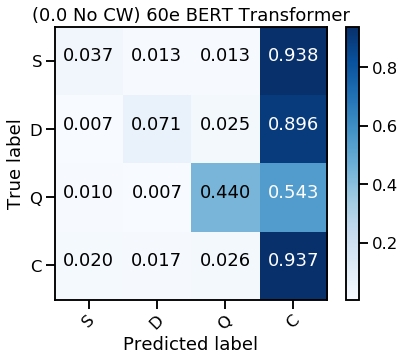

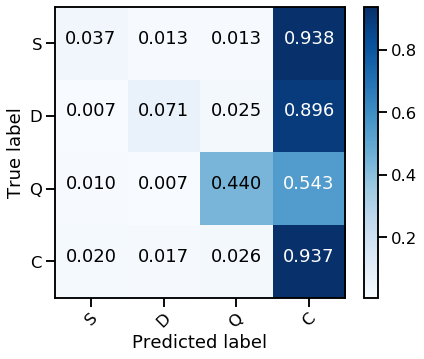

In [28]:
print ("Acc: %.3f" % np.mean(np.asarray(global_accs)), "-- deviation: %.3f" % np.std(np.asarray(global_accs)))
print ("F-score: %.3f" % np.mean(np.asarray(global_fmacros)), "-- deviation: %.3f" % np.std(np.asarray(global_fmacros)))
np.set_printoptions(precision=3)
sup=np.mean(np.asarray(global_fnones)[:,0])
den=np.mean(np.asarray(global_fnones)[:,1])
que=np.mean(np.asarray(global_fnones)[:,2])
com=np.mean(np.asarray(global_fnones)[:,3])

print ("(0.0_No CW) NIPS:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in global_cms:
    m_temp+=np.asarray(m)
    
print (m_temp)
plot_cm(cm_norma(m_temp),["S","D","Q","C"],"(0.0 No CW) 60e BERT Transformer", cmap='Blues')

plot_cm(cm_norma(m_temp),["S","D","Q","C"], "", cmap='Blues')

## 0.0 CW

In [29]:
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
class_weights

array([1.26 , 3.182, 3.211, 0.388])

In [32]:
bc = BertClient() 

Entrenando Run # 1
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.267 	F-macro_val: 0.213
Epoch 10 	acc_val: 0.493 	F-macro_val: 0.403
Epoch 20 	acc_val: 0.556 	F-macro_val: 0.474
Epoch 30 	acc_val: 0.625 	F-macro_val: 0.510
Epoch 40 	acc_val: 0.632 	F-macro_val: 0.511
Epoch 50 	acc_val: 0.653 	F-macro_val: 0.541
Testing run # 1
SE TUVIERON QUE REPETIR 3 EJEMPLOS


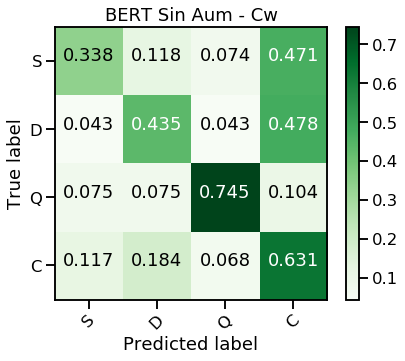

Test_ acc: 0.6101860920666013
Test_ f1 none: [0.238 0.233 0.642 0.73 ]
Test_ f1 macro: 0.4608220138436493


Ejemplo de tweet con label  commenting  y Tw_id  524938264575508482
Encoder Layer 1


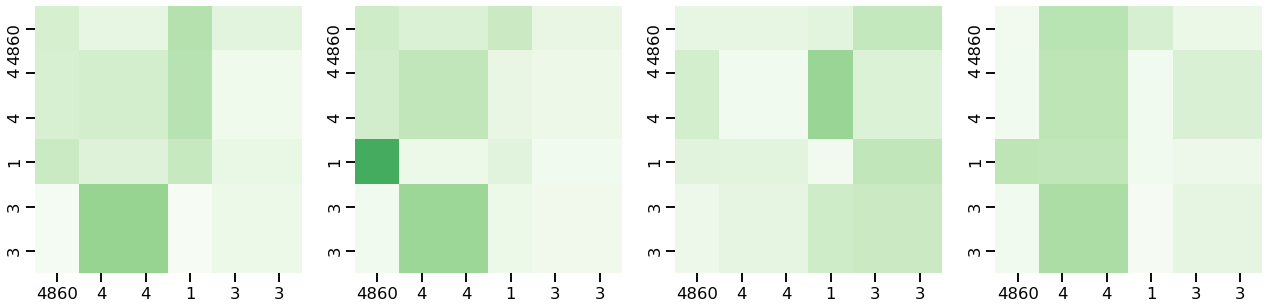

Encoder Layer 2


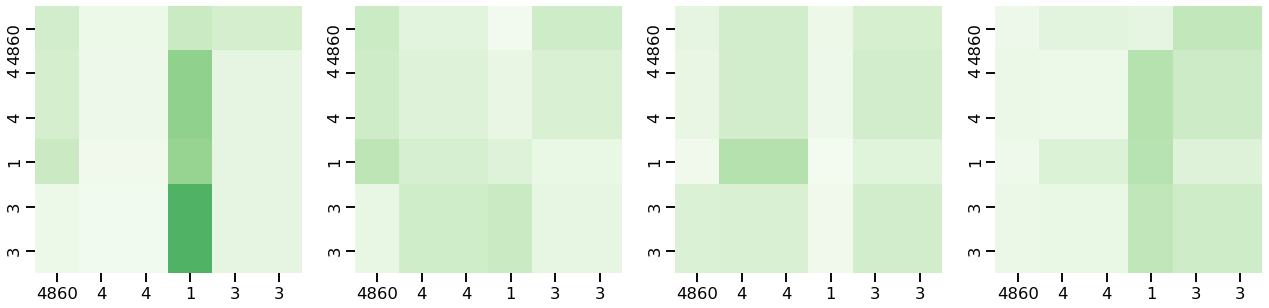



Ejemplo de tweet con label  support  y Tw_id  498299548625018880
Encoder Layer 1


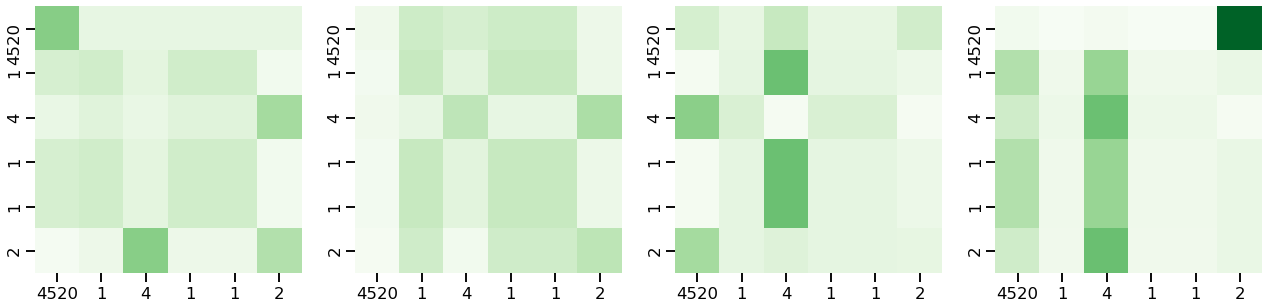

Encoder Layer 2


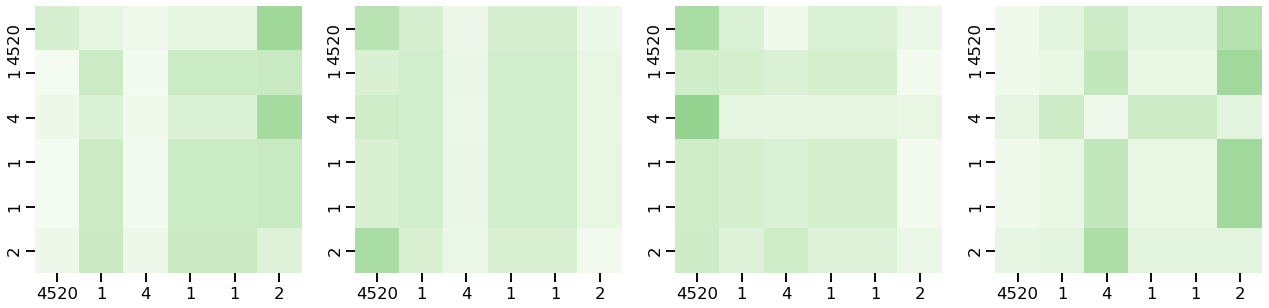



Ejemplo de tweet con label  denying  y Tw_id  758295910145204225
Encoder Layer 1


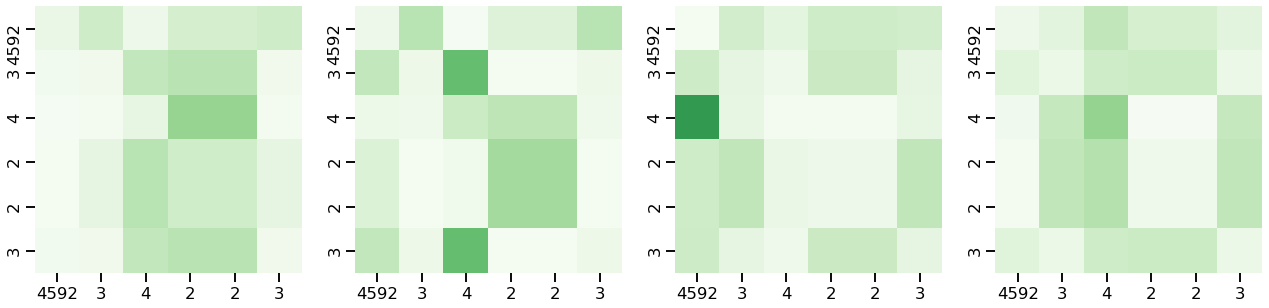

Encoder Layer 2


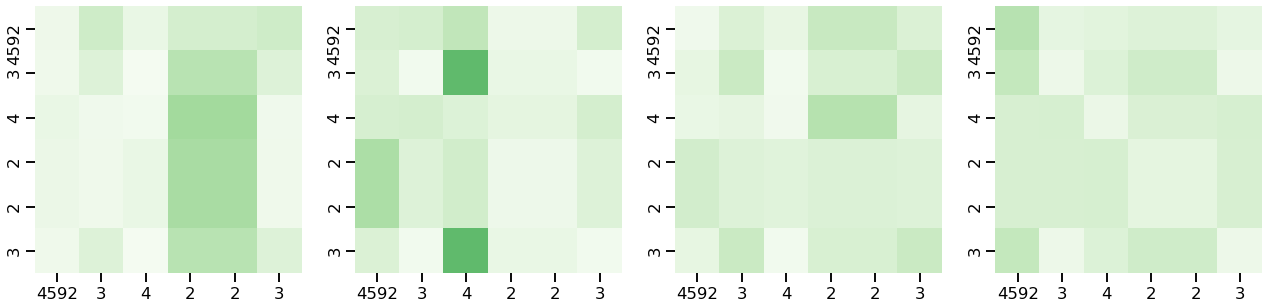



Ejemplo de tweet con label  questioning  y Tw_id  524953928320831489
Encoder Layer 1


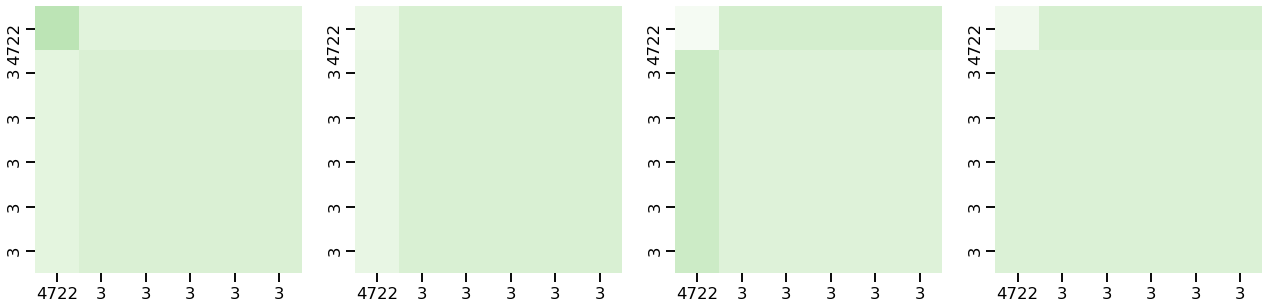

Encoder Layer 2


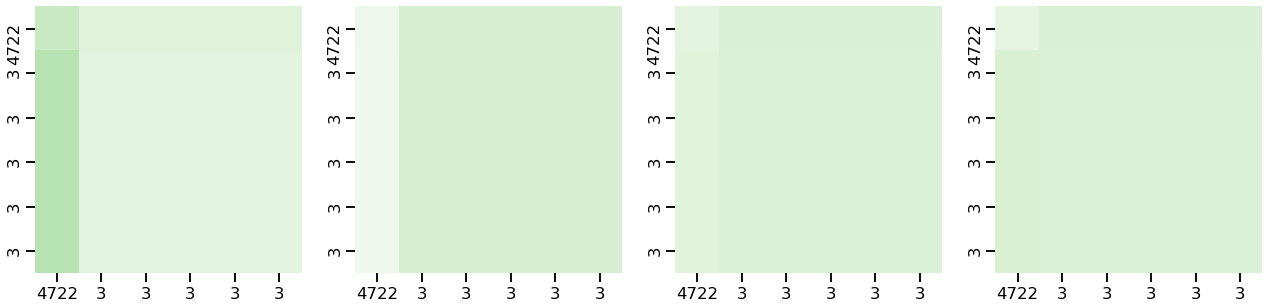

Entrenando Run # 2
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.101 	F-macro_val: 0.119
Epoch 10 	acc_val: 0.309 	F-macro_val: 0.289
Epoch 20 	acc_val: 0.573 	F-macro_val: 0.510
Epoch 30 	acc_val: 0.608 	F-macro_val: 0.513
Epoch 40 	acc_val: 0.628 	F-macro_val: 0.515
Epoch 50 	acc_val: 0.635 	F-macro_val: 0.524
Testing run # 2
SE TUVIERON QUE REPETIR 3 EJEMPLOS


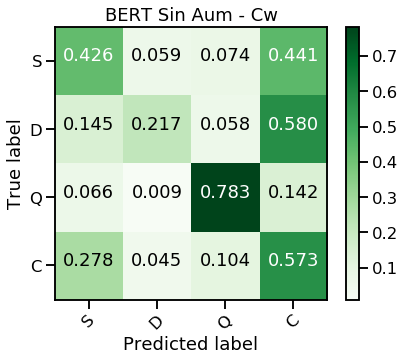

Test_ acc: 0.5612144955925563
Test_ f1 none: [0.176 0.242 0.595 0.681]
Test_ f1 macro: 0.4235278373323914
Entrenando Run # 3
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.062 	F-macro_val: 0.058
Epoch 10 	acc_val: 0.240 	F-macro_val: 0.198
Epoch 20 	acc_val: 0.274 	F-macro_val: 0.275
Epoch 30 	acc_val: 0.292 	F-macro_val: 0.273
Epoch 40 	acc_val: 0.292 	F-macro_val: 0.274
Epoch 50 	acc_val: 0.347 	F-macro_val: 0.309
Testing run # 3
SE TUVIERON QUE REPETIR 3 EJEMPLOS


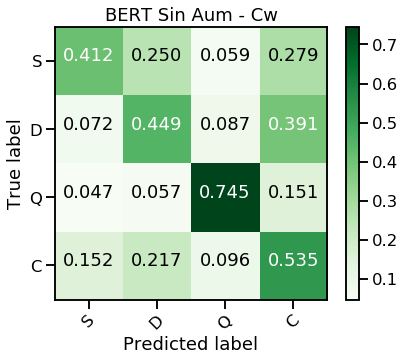

Test_ acc: 0.5426052889324192
Test_ f1 none: [0.25  0.212 0.585 0.662]
Test_ f1 macro: 0.42748358361851946
Entrenando Run # 4
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.163 	F-macro_val: 0.130
Epoch 10 	acc_val: 0.191 	F-macro_val: 0.166
Epoch 20 	acc_val: 0.299 	F-macro_val: 0.251
Epoch 30 	acc_val: 0.351 	F-macro_val: 0.339
Epoch 40 	acc_val: 0.424 	F-macro_val: 0.404
Epoch 50 	acc_val: 0.420 	F-macro_val: 0.399
Testing run # 4
SE TUVIERON QUE REPETIR 3 EJEMPLOS


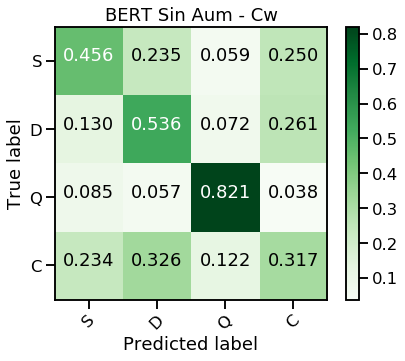

Test_ acc: 0.39373163565132224
Test_ f1 none: [0.207 0.194 0.586 0.464]
Test_ f1 macro: 0.3628048592907459
Entrenando Run # 5
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.132 	F-macro_val: 0.104
Epoch 10 	acc_val: 0.267 	F-macro_val: 0.200
Epoch 20 	acc_val: 0.434 	F-macro_val: 0.398
Epoch 30 	acc_val: 0.465 	F-macro_val: 0.417
Epoch 40 	acc_val: 0.576 	F-macro_val: 0.491
Epoch 50 	acc_val: 0.580 	F-macro_val: 0.486
Testing run # 5
SE TUVIERON QUE REPETIR 3 EJEMPLOS


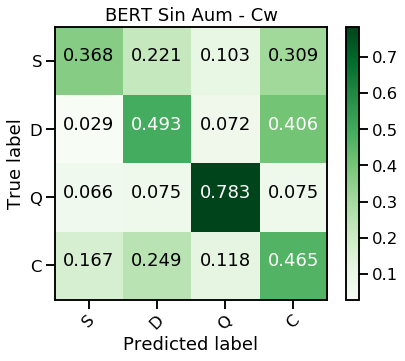

Test_ acc: 0.49363369245837413
Test_ f1 none: [0.216 0.212 0.567 0.605]
Test_ f1 macro: 0.39985389733847776
Entrenando Run # 6
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.125 	F-macro_val: 0.119
Epoch 10 	acc_val: 0.233 	F-macro_val: 0.219
Epoch 20 	acc_val: 0.368 	F-macro_val: 0.330
Epoch 30 	acc_val: 0.524 	F-macro_val: 0.455
Epoch 40 	acc_val: 0.569 	F-macro_val: 0.475
Epoch 50 	acc_val: 0.556 	F-macro_val: 0.466
Testing run # 6
SE TUVIERON QUE REPETIR 3 EJEMPLOS


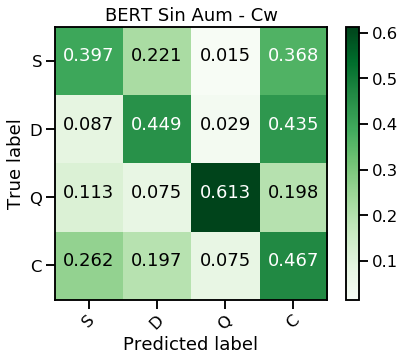

Test_ acc: 0.47600391772771794
Test_ f1 none: [0.17  0.225 0.56  0.597]
Test_ f1 macro: 0.3879696006537685
Entrenando Run # 7
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.295 	F-macro_val: 0.218
Epoch 10 	acc_val: 0.410 	F-macro_val: 0.371
Epoch 20 	acc_val: 0.486 	F-macro_val: 0.416
Epoch 30 	acc_val: 0.444 	F-macro_val: 0.380
Epoch 40 	acc_val: 0.493 	F-macro_val: 0.414
Epoch 50 	acc_val: 0.448 	F-macro_val: 0.390
Testing run # 7
SE TUVIERON QUE REPETIR 3 EJEMPLOS


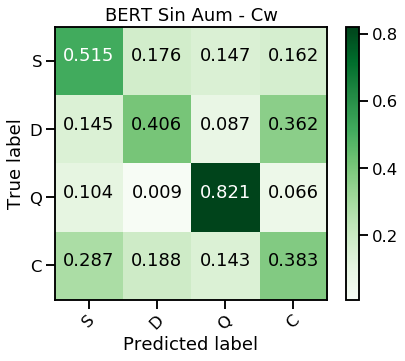

Test_ acc: 0.4387855044074437
Test_ f1 none: [0.202 0.219 0.544 0.533]
Test_ f1 macro: 0.37421187898056363
Entrenando Run # 8
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.125 	F-macro_val: 0.114
Epoch 10 	acc_val: 0.267 	F-macro_val: 0.231
Epoch 20 	acc_val: 0.319 	F-macro_val: 0.280
Epoch 30 	acc_val: 0.319 	F-macro_val: 0.277
Epoch 40 	acc_val: 0.337 	F-macro_val: 0.296
Epoch 50 	acc_val: 0.351 	F-macro_val: 0.311
Testing run # 8
SE TUVIERON QUE REPETIR 3 EJEMPLOS


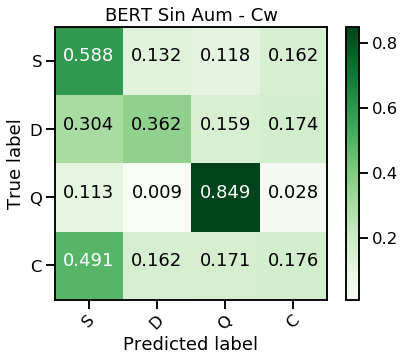

Test_ acc: 0.2859941234084231
Test_ f1 none: [0.153 0.217 0.517 0.291]
Test_ f1 macro: 0.29469398774014016
Entrenando Run # 9
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.385 	F-macro_val: 0.249
Epoch 10 	acc_val: 0.378 	F-macro_val: 0.319
Epoch 20 	acc_val: 0.396 	F-macro_val: 0.349
Epoch 30 	acc_val: 0.535 	F-macro_val: 0.467
Epoch 40 	acc_val: 0.562 	F-macro_val: 0.487
Epoch 50 	acc_val: 0.562 	F-macro_val: 0.480
Testing run # 9
SE TUVIERON QUE REPETIR 3 EJEMPLOS


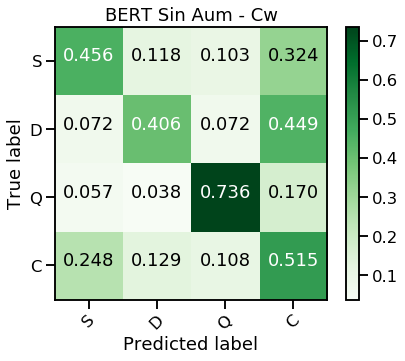

Test_ acc: 0.5269343780607247
Test_ f1 none: [0.205 0.268 0.557 0.642]
Test_ f1 macro: 0.41782647573027976
Entrenando Run # 10
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.236 	F-macro_val: 0.132
Epoch 10 	acc_val: 0.281 	F-macro_val: 0.212
Epoch 20 	acc_val: 0.312 	F-macro_val: 0.268
Epoch 30 	acc_val: 0.333 	F-macro_val: 0.283
Epoch 40 	acc_val: 0.566 	F-macro_val: 0.478
Epoch 50 	acc_val: 0.583 	F-macro_val: 0.493
Testing run # 10
SE TUVIERON QUE REPETIR 3 EJEMPLOS


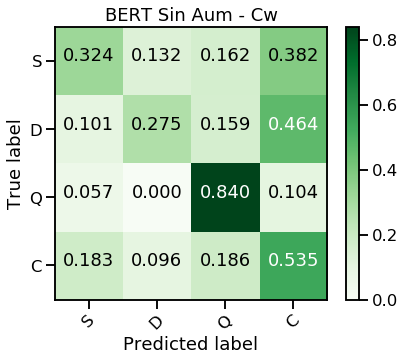

Test_ acc: 0.534769833496572
Test_ f1 none: [0.18  0.221 0.492 0.659]
Test_ f1 macro: 0.3877459466920268
Entrenando Run # 11
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.236 	F-macro_val: 0.193
Epoch 10 	acc_val: 0.361 	F-macro_val: 0.322
Epoch 20 	acc_val: 0.403 	F-macro_val: 0.372
Epoch 30 	acc_val: 0.521 	F-macro_val: 0.455
Epoch 40 	acc_val: 0.556 	F-macro_val: 0.485
Epoch 50 	acc_val: 0.538 	F-macro_val: 0.476
Testing run # 11
SE TUVIERON QUE REPETIR 3 EJEMPLOS


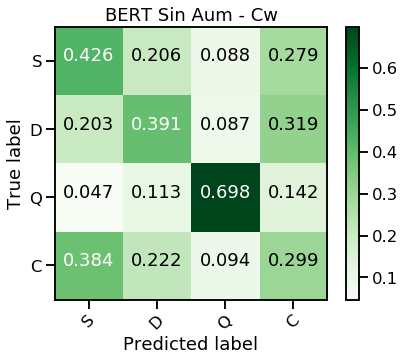

Test_ acc: 0.3555337904015671
Test_ f1 none: [0.14  0.183 0.558 0.437]
Test_ f1 macro: 0.3295097422131718
Entrenando Run # 12
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.389 	F-macro_val: 0.197
Epoch 10 	acc_val: 0.583 	F-macro_val: 0.438
Epoch 20 	acc_val: 0.622 	F-macro_val: 0.500
Epoch 30 	acc_val: 0.625 	F-macro_val: 0.505
Epoch 40 	acc_val: 0.611 	F-macro_val: 0.494
Epoch 50 	acc_val: 0.597 	F-macro_val: 0.493
Testing run # 12
SE TUVIERON QUE REPETIR 3 EJEMPLOS


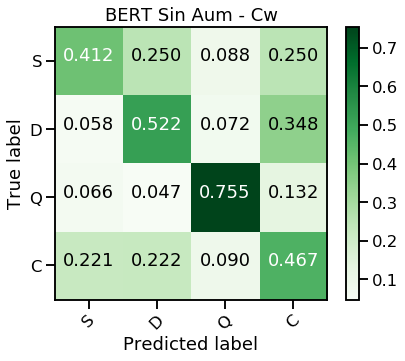

Test_ acc: 0.49657198824681686
Test_ f1 none: [0.201 0.24  0.599 0.607]
Test_ f1 macro: 0.4117477983947404
Entrenando Run # 13
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.257 	F-macro_val: 0.191
Epoch 10 	acc_val: 0.351 	F-macro_val: 0.308
Epoch 20 	acc_val: 0.330 	F-macro_val: 0.300
Epoch 30 	acc_val: 0.483 	F-macro_val: 0.424
Epoch 40 	acc_val: 0.622 	F-macro_val: 0.499
Epoch 50 	acc_val: 0.646 	F-macro_val: 0.516
Testing run # 13
SE TUVIERON QUE REPETIR 3 EJEMPLOS


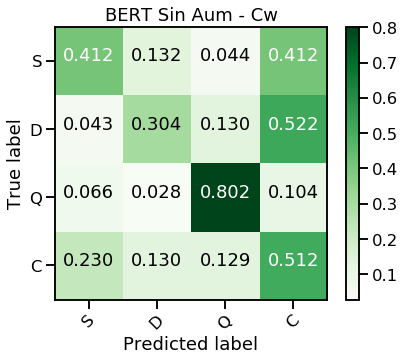

Test_ acc: 0.5210577864838394
Test_ f1 none: [0.196 0.207 0.561 0.636]
Test_ f1 macro: 0.40018371315777335
Entrenando Run # 14
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.257 	F-macro_val: 0.227
Epoch 10 	acc_val: 0.330 	F-macro_val: 0.344
Epoch 20 	acc_val: 0.396 	F-macro_val: 0.395
Epoch 30 	acc_val: 0.517 	F-macro_val: 0.468
Epoch 40 	acc_val: 0.601 	F-macro_val: 0.510
Epoch 50 	acc_val: 0.622 	F-macro_val: 0.515
Testing run # 14
SE TUVIERON QUE REPETIR 3 EJEMPLOS


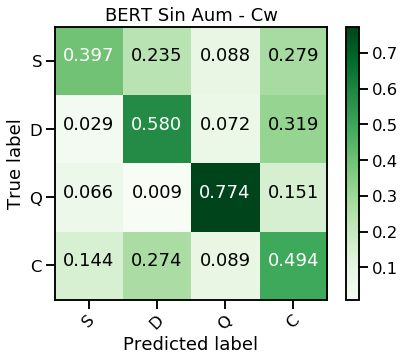

Test_ acc: 0.5220372184133203
Test_ f1 none: [0.25  0.236 0.612 0.63 ]
Test_ f1 macro: 0.4319882773584436
Entrenando Run # 15
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.264 	F-macro_val: 0.163
Epoch 10 	acc_val: 0.340 	F-macro_val: 0.321
Epoch 20 	acc_val: 0.323 	F-macro_val: 0.289
Epoch 30 	acc_val: 0.333 	F-macro_val: 0.309
Epoch 40 	acc_val: 0.375 	F-macro_val: 0.349
Epoch 50 	acc_val: 0.458 	F-macro_val: 0.421
Testing run # 15
SE TUVIERON QUE REPETIR 3 EJEMPLOS


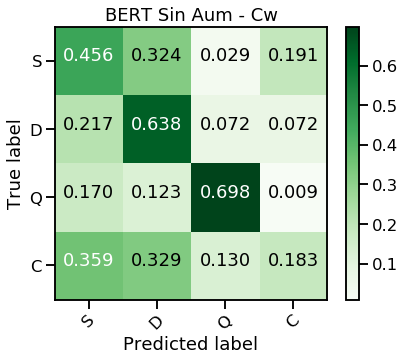

Test_ acc: 0.2850146914789422
Test_ f1 none: [0.151 0.218 0.514 0.302]
Test_ f1 macro: 0.29625291671153076
Entrenando Run # 16
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.330 	F-macro_val: 0.200
Epoch 10 	acc_val: 0.545 	F-macro_val: 0.434
Epoch 20 	acc_val: 0.622 	F-macro_val: 0.521
Epoch 30 	acc_val: 0.618 	F-macro_val: 0.527
Epoch 40 	acc_val: 0.635 	F-macro_val: 0.543
Epoch 50 	acc_val: 0.628 	F-macro_val: 0.539
Testing run # 16
SE TUVIERON QUE REPETIR 3 EJEMPLOS


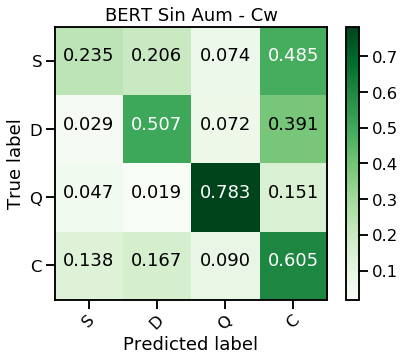

Test_ acc: 0.5925563173359452
Test_ f1 none: [0.162 0.28  0.617 0.711]
Test_ f1 macro: 0.44241498239744714
Entrenando Run # 17
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.247 	F-macro_val: 0.196
Epoch 10 	acc_val: 0.330 	F-macro_val: 0.282
Epoch 20 	acc_val: 0.344 	F-macro_val: 0.332
Epoch 30 	acc_val: 0.358 	F-macro_val: 0.337
Epoch 40 	acc_val: 0.427 	F-macro_val: 0.381
Epoch 50 	acc_val: 0.417 	F-macro_val: 0.387
Testing run # 17
SE TUVIERON QUE REPETIR 3 EJEMPLOS


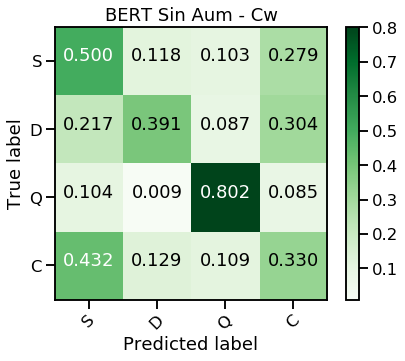

Test_ acc: 0.39471106758080315
Test_ f1 none: [0.147 0.263 0.588 0.474]
Test_ f1 macro: 0.36809284852483415
Entrenando Run # 18
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.094 	F-macro_val: 0.069
Epoch 10 	acc_val: 0.205 	F-macro_val: 0.129
Epoch 20 	acc_val: 0.309 	F-macro_val: 0.198
Epoch 30 	acc_val: 0.365 	F-macro_val: 0.352
Epoch 40 	acc_val: 0.615 	F-macro_val: 0.516
Epoch 50 	acc_val: 0.597 	F-macro_val: 0.488
Testing run # 18
SE TUVIERON QUE REPETIR 3 EJEMPLOS


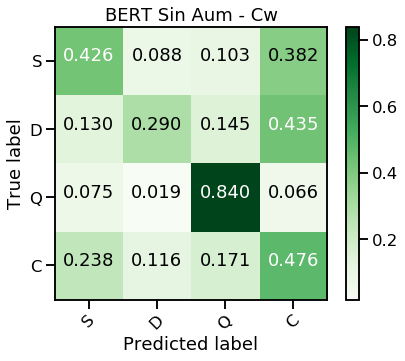

Test_ acc: 0.4975514201762977
Test_ f1 none: [0.194 0.214 0.516 0.611]
Test_ f1 macro: 0.3837227351885188
Entrenando Run # 19
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.260 	F-macro_val: 0.181
Epoch 10 	acc_val: 0.424 	F-macro_val: 0.362
Epoch 20 	acc_val: 0.438 	F-macro_val: 0.405
Epoch 30 	acc_val: 0.438 	F-macro_val: 0.392
Epoch 40 	acc_val: 0.476 	F-macro_val: 0.430
Epoch 50 	acc_val: 0.601 	F-macro_val: 0.509
Testing run # 19
SE TUVIERON QUE REPETIR 3 EJEMPLOS


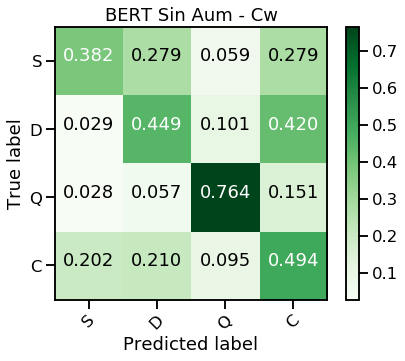

Test_ acc: 0.5112634671890304
Test_ f1 none: [0.203 0.215 0.596 0.626]
Test_ f1 macro: 0.41010460481772915
Entrenando Run # 20
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.125 	F-macro_val: 0.086
Epoch 10 	acc_val: 0.278 	F-macro_val: 0.208
Epoch 20 	acc_val: 0.309 	F-macro_val: 0.275
Epoch 30 	acc_val: 0.312 	F-macro_val: 0.279
Epoch 40 	acc_val: 0.337 	F-macro_val: 0.304
Epoch 50 	acc_val: 0.455 	F-macro_val: 0.388
Testing run # 20
SE TUVIERON QUE REPETIR 3 EJEMPLOS


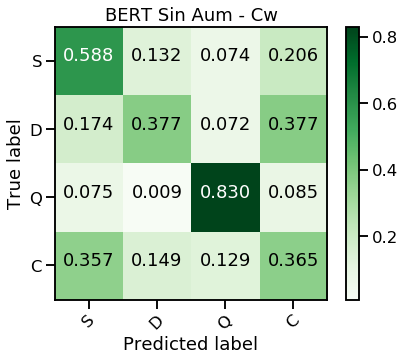

Test_ acc: 0.4289911851126347
Test_ f1 none: [0.197 0.235 0.579 0.511]
Test_ f1 macro: 0.3806342365389981


In [34]:
global_accs=[]
global_fnones=[]
global_fmacros=[]
global_cms=[]
global_attn=[]
best_macro={'F_ma':0.1 , 'Run':0}

prob=0.0
bs=32

for x in range(1,21): 
    print ("Entrenando Run #", x)
    cnn1 = load_model(path_m+str(prob)+'cw/cnn1_'+str(x)+'-exec.h5')
    cnn2 = load_model(path_m+str(prob)+'cw/cnn2_'+str(x)+'-exec.h5')
    rnn1 = load_model(path_m+str(prob)+'cw/rnn1_'+str(x)+'-exec.h5')
    rnn2 = load_model(path_m+str(prob)+'cw/rnn2_'+str(x)+'-exec.h5')
    rnn3 = load_model(path_m+str(prob)+'cw/rnn3_'+str(x)+'-exec.h5')

    list_models=['cnn1', 'cnn2', 'rnn1', 'rnn2', 'rnn3']
    index_models=np.arange(5)
    dict_models=dict((key, value) for (key, value) in zip(index_models,list_models))
    modelos=[cnn1, cnn2, rnn1, rnn2, rnn3]
    ind=np.arange(5)
    dict_trainedModel=dict((key, value) for (key, value) in zip(ind,modelos))

    predicciones_all=[]
    predicciones_all_val=[]
    predicciones_all_test=[]
    
    print ("agregando predicciones Train")
    for i in dict_trainedModel.keys(): 
        a_evaluar=dict_models[i]
        predicciones_all.append(dict_trainedModel[i].predict(x_train, batch_size=bs))
    print ("agregando predicciones Val")
    for i in dict_trainedModel.keys(): 
        a_evaluar=dict_models[i]
        predicciones_all_val.append(dict_trainedModel[i].predict(x_val, batch_size=bs))
    print ("agregando predicciones Test")
    for i in dict_trainedModel.keys(): 
        a_evaluar=dict_models[i]
        predicciones_all_test.append(dict_trainedModel[i].predict(x_test, batch_size=bs))

    matrix=np.asarray(predicciones_all)
    matrix_val=np.asarray(predicciones_all_val)
    matrix_test=np.asarray(predicciones_all_test)
    new_matrix=np.concatenate([matrix,matrix_val,matrix_test], axis=1)
    
    b_dim=768
    espacio=[np.ones(b_dim)]
    Ks= ortho_group.rvs(dim=b_dim)
    random=np.random.randint(Ks.shape[0], size=4)
    K_list=Ks[random]
    K_list_ext=espacio+list(K_list)
    index_embeddings=[0,1,2,3,4]
    lab_str_embeddings=['','','','','']

    for i in range(len(sentences)):
        #ide=ids_train[i]
        tw_tr=tws_train[i]
        clase=dict_cl[labels_train[i]]
        encoded_tok = cleaner(tw_tr)[0]  #cleaner: raw, no cleaner:augmented version
        vector=bc.encode([encoded_tok])[0]
        final_bert= vector
            
        index_embeddings.append(i+5)
        lab_str_embeddings.append(clase)
        K_list_ext.append(final_bert)
    
    objs_val=val['Tw_id']      #df_val['Unnamed: 0'].values
    objs_test=test['Tw_id']    #np.arange(df_test.shape[0])
    lab_val=val['Label']
    lab_test=test['Label']
    tw_val=val['Tweet']
    tw_test=test['Tweet']
    llaves=np.concatenate([objs_val,objs_test])
    clases=np.concatenate([lab_val,lab_test])
    sent_all=np.concatenate([tw_val,tw_test])
      
    for num in range(len(llaves)):
        i=llaves[num]
        clase=clases[num]
        tw_tr=sent_all[num]
        encoded_tok = cleaner(tw_tr)[0]  #cleaner: raw, no cleaner:augmented version
        vector=bc.encode([encoded_tok])[0]
        final_bert= vector

        index_embeddings.append(num+5+train.shape[0])
        lab_str_embeddings.append(clase)
        K_list_ext.append(final_bert)

    
    K_list_new= np.asarray(K_list_ext, dtype='float32')
    
    ###################################### TRANSFORMER ###############################
    hist_train_loss=[]
    hist_train_acc=[]
    hist_train_fma=[]
    hist_val_loss=[]
    hist_val_acc=[]
    hist_val_fma=[]
    
    V = 4
    pesos = torch.from_numpy(class_weights).float()
    criterion = FocalLoss(weights=pesos)
    model = make_model_concat(4, N=2,d_model=b_dim, d_ff=128, h=4, dropout=0.35)
    model_opt = NoamOpt(model.src_embed[0].d_model,  1, 6000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-5))

    
    for epoch in range(60):
        model.train()
        DATA=data_gen(bs, 'Train', 5, new_matrix)
        loss_train, acc_train,fma_train, f_none, cm_train=run_epoch(DATA, model, SimpleLossComputeFL(criterion, model_opt), 'Train')
        
        model.eval()
        loss_val, acc_val,fma_val, f_val_none, cm_val=run_epoch(data_gen(bs, 'Val', 5, new_matrix), model, SimpleLossComputeFL(criterion, None),'Val')
        if epoch%10==0:
            print ("Epoch",epoch, "\tacc_val: %.3f" % acc_val.numpy(), "\tF-macro_val: %.3f" % fma_val.numpy())
    
    model.eval()
    print ("Testing run #",x)
    predicciones = run_epoch(data_gen(bs, 'Test', 5, new_matrix), model, SimpleLossComputeFL(criterion, None),'Test')
    predicciones=np.concatenate(predicciones, axis=-1)
    
    glo_acc=accuracy_score(etiq_t, predicciones[:-3])
    glo_fno=f1_score(etiq_t,predicciones[:-3], average=None)
    glo_fma=f1_score(etiq_t,predicciones[:-3], average='macro')

    glo_cm=confusion_matrix(etiq_t, predicciones[:-3])

    plot_cm(cm_norma(glo_cm),["S","D","Q","C"],"BERT Sin Aum - Cw", cmap="Greens")
    global_accs.append(glo_acc)
    global_fnones.append(glo_fno)
    global_fmacros.append(glo_fma)
    global_cms.append(glo_cm)
    print("Test_ acc:",glo_acc) 
    print("Test_ f1 none:",glo_fno) 
    print("Test_ f1 macro:",glo_fma) 

    if glo_fma>best_macro['F_ma']:
        best_macro['F_ma']=glo_fma
        best_macro['Run']=x                
        tope=4520

        for key in keys: 
            mask_s=test["Label"]==key
            q_tid=np.random.choice(test["Tw_id"][mask_s])
            q_ide=list(test["Tw_id"].values).index(q_tid)

            model.eval()

            temp2= [tope + q_ide]

            for m in range(n_machines): 
                temp2= temp2 + [np.argmax(matrix_test[m][q_ide])+1] 

            sent = [temp2]
            src = torch.LongTensor([w for w in sent])
            src = Variable(src)
            src_mask = src_mask=  (src != 0).unsqueeze(-2)
            out = model.forward(src, src_mask)
            print ("\n\nEjemplo de tweet con label ", key, " y Tw_id ", q_tid)
            for layer in range(2):
                fig, axs = plt.subplots(1,4, figsize=(22,11))
                print("Encoder Layer", layer+1)
                for h in range(4):
                    draw(model.encoder.layers[layer].self_attn.attn[0, h].data, 
                        axs[h], sent, color="Greens")
                plt.show()

In [35]:
best_macro

{'F_ma': 0.4608220138436493, 'Run': 1}

Acc: 0.473 -- deviation: 0.089
F-score: 0.390 -- deviation: 0.043
(0.0CW) SDQC: 0.19181812853568164 0.22671695623250665 0.5692743519423219 0.5705089505942398


Confusion counts
[[ 579.  247.  113.  421.]
 [ 156.  585.  121.  518.]
 [ 162.   89. 1641.  228.]
 [3985. 2910. 1802. 6863.]]


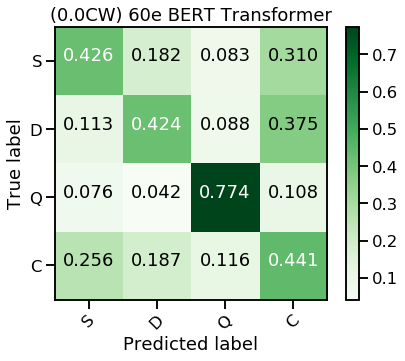

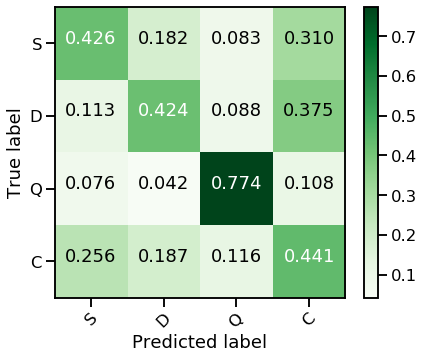

In [36]:
print ("Acc: %.3f" % np.mean(np.asarray(global_accs)), "-- deviation: %.3f" % np.std(np.asarray(global_accs)))
print ("F-score: %.3f" % np.mean(np.asarray(global_fmacros)), "-- deviation: %.3f" % np.std(np.asarray(global_fmacros)))
np.set_printoptions(precision=3)
sup=np.mean(np.asarray(global_fnones)[:,0])
den=np.mean(np.asarray(global_fnones)[:,1])
que=np.mean(np.asarray(global_fnones)[:,2])
com=np.mean(np.asarray(global_fnones)[:,3])

print ("(0.0CW) SDQC:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in global_cms:
    m_temp+=np.asarray(m)
    
print (m_temp)
plot_cm(cm_norma(m_temp),["S","D","Q","C"],"(0.0CW) 60e BERT Transformer", cmap='Greens')

plot_cm(cm_norma(m_temp),["S","D","Q","C"], "", cmap='Greens')

## Con aumento de datos

### 0.15

In [8]:
bc = BertClient()  

class_weights= np.asarray([1.0, 1.0, 1.0, 1.0])
path_a='../../../Datasets/CSV_Stance/Aumento_ofi/' 

print ("Pesos de clases:", class_weights)

Pesos de clases: [1. 1. 1. 1.]


In [35]:
def train_transformer(prob, num_epochs, path_a, path_m, c_gama,  xfrom=1, xto=20):    
    global_accs=[]
    global_fnones=[]
    global_fmacros=[]
    global_cms=[]
    global_attn=[]
    best_macro={'F_ma':0.1 , 'Run':0}

    bs=32

    for x in range(xfrom, xto + 1):

        macro_augmented= np.load(path_a + 'balance_GloVe_' + str(int(prob*100)) + '_'+ str(x)+'_run.npy', allow_pickle=True)

        ids_train=macro_augmented[:,0]
        tws_train=macro_augmented[:,1]
        labels_train=macro_augmented[:,2]
        class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
        print ("Pesos de clases:", class_weights)

        etiq=np.asarray(labels_train)
        sentences = tws_train
        n_labels = etiq.copy()
        y_train=to_categorical(n_labels,num_classes=4)

        input_ids=[]
        for sent in sentences:
            encoded_sent=[]
            for wd in sent:
                try:
                    encoded_sent.append(token_2_idx[wd])
                except:
                    continue
            input_ids.append(encoded_sent)

        input_ids = pad_sequences(input_ids,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
        shape=np.asarray(input_ids).shape

        x_train=np.zeros((shape[0], shape[1], emb))
        j=0
        for in_id in input_ids:
            x_train[j]=EMB_matrix[in_id]
            j+=1

        ################################################    
        print ("Entrenando Run #", x)
        cnn1 = load_model(path_m+str(prob)+'/cnn1_'+str(x)+'-exec.h5')
        cnn2 = load_model(path_m+str(prob)+'/cnn2_'+str(x)+'-exec.h5')
        rnn1 = load_model(path_m+str(prob)+'/rnn1_'+str(x)+'-exec.h5')
        rnn2 = load_model(path_m+str(prob)+'/rnn2_'+str(x)+'-exec.h5')
        rnn3 = load_model(path_m+str(prob)+'/rnn3_'+str(x)+'-exec.h5')

        list_models=['cnn1', 'cnn2', 'rnn1', 'rnn2', 'rnn3']
        index_models=np.arange(5)
        dict_models=dict((key, value) for (key, value) in zip(index_models,list_models))
        modelos=[cnn1, cnn2, rnn1, rnn2, rnn3]
        ind=np.arange(5)
        dict_trainedModel=dict((key, value) for (key, value) in zip(ind,modelos))

        predicciones_all=[]
        predicciones_all_val=[]
        predicciones_all_test=[]

        print ("agregando predicciones Train")
        for i in dict_trainedModel.keys(): 
            a_evaluar=dict_models[i]
            predicciones_all.append(dict_trainedModel[i].predict(x_train, batch_size=bs))
        print ("agregando predicciones Val")
        for i in dict_trainedModel.keys(): 
            a_evaluar=dict_models[i]
            predicciones_all_val.append(dict_trainedModel[i].predict(x_val, batch_size=bs))
        print ("agregando predicciones Test")
        for i in dict_trainedModel.keys(): 
            a_evaluar=dict_models[i]
            predicciones_all_test.append(dict_trainedModel[i].predict(x_test, batch_size=bs))

        matrix=np.asarray(predicciones_all)
        matrix_val=np.asarray(predicciones_all_val)
        matrix_test=np.asarray(predicciones_all_test)
        new_matrix=np.concatenate([matrix,matrix_val,matrix_test], axis=1)

        b_dim=768
        espacio=[np.ones(b_dim)]
        Ks= ortho_group.rvs(dim=b_dim)
        random=np.random.randint(Ks.shape[0], size=4)
        K_list=Ks[random]
        K_list_ext=espacio+list(K_list)
        index_embeddings=[0,1,2,3,4]
        lab_str_embeddings=['','','','','']

        for i in range(len(sentences)):
            #ide=ids_train[i]
            tw_tr=tws_train[i]
            clase=dict_cl[labels_train[i]]            
            tw=' '.join([word for word in tw_tr])
            vector= bc.encode([tw])[0]
            final_bert= vector

            index_embeddings.append(i+5)
            lab_str_embeddings.append(clase)
            K_list_ext.append(final_bert)

        objs_val=val['Tw_id']      #df_val['Unnamed: 0'].values
        objs_test=test['Tw_id']    #np.arange(df_test.shape[0])
        lab_val=val['Label']
        lab_test=test['Label']
        tw_val=val['Tweet']
        tw_test=test['Tweet']
        llaves=np.concatenate([objs_val,objs_test])
        clases=np.concatenate([lab_val,lab_test])
        sent_all=np.concatenate([tw_val,tw_test])

        for num in range(len(llaves)):
            i=llaves[num]
            clase=clases[num]
            tw_tr=sent_all[num]
            encoded_tok = cleaner(tw_tr)[0]  #cleaner: raw, no cleaner:augmented version
            vector=bc.encode([encoded_tok])[0]
            final_bert= vector

            index_embeddings.append(num+5+train.shape[0])
            lab_str_embeddings.append(clase)
            K_list_ext.append(final_bert)


        K_list_new= np.asarray(K_list_ext, dtype='float32')

        ###################################### TRANSFORMER ###############################
        hist_train_loss=[]
        hist_train_acc=[]
        hist_train_fma=[]
        hist_val_loss=[]
        hist_val_acc=[]
        hist_val_fma=[]

        V = 4
        pesos = torch.from_numpy(class_weights).float()
        criterion = FocalLoss(weights=pesos)
        model = make_model_concat(4, K_list_new, N=2,d_model=b_dim, d_ff=128, h=4, dropout=0.35)
        model_opt = NoamOpt(model.src_embed[0].d_model,  1, 6000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-5))


        for epoch in range(num_epochs):
            model.train()
            DATA=data_gen(bs, 'Train', 5, new_matrix, matrix, matrix_val, matrix_test, lab_str_embeddings, index_embeddings)  
            loss_train, acc_train,fma_train, f_none, cm_train=run_epoch(DATA, model, SimpleLossComputeFL(criterion, model_opt), 'Train')

            model.eval()
            DATA_VAL=data_gen(bs, 'Val', 5, new_matrix, matrix, matrix_val, matrix_test, lab_str_embeddings, index_embeddings)
            loss_val, acc_val,fma_val, f_val_none, cm_val=run_epoch(DATA_VAL, model, SimpleLossComputeFL(criterion, None),'Val')
            if epoch%10==0:
                print ("Epoch",epoch, "\tacc_val: %.3f" % acc_val.numpy(), "\tF-macro_val: %.3f" % fma_val.numpy())

        model.eval()
        print ("Testing run #",x)
        DATA_TEST=data_gen(bs, 'Test', 5, new_matrix, matrix, matrix_val, matrix_test, lab_str_embeddings, index_embeddings)
        predicciones = run_epoch(DATA_TEST, model, SimpleLossComputeFL(criterion, None),'Test')
        predicciones=np.concatenate(predicciones, axis=-1)

        glo_acc=accuracy_score(etiq_t, predicciones[:-3])
        glo_fno=f1_score(etiq_t,predicciones[:-3], average=None)
        glo_fma=f1_score(etiq_t,predicciones[:-3], average='macro')

        glo_cm=confusion_matrix(etiq_t, predicciones[:-3])

        plot_cm(cm_norma(glo_cm),["S","D","Q","C"],"BERT Aum 0.15", cmap=c_gama)
        global_accs.append(glo_acc)
        global_fnones.append(glo_fno)
        global_fmacros.append(glo_fma)
        global_cms.append(glo_cm)
        print("Test_ acc:",glo_acc) 
        print("Test_ f1 none:",glo_fno) 
        print("Test_ f1 macro:",glo_fma) 

        if glo_fma>best_macro['F_ma']:
            best_macro['F_ma']=glo_fma
            best_macro['Run']=x                
            tope=4520

            for key in keys: 
                mask_s=test["Label"]==key
                q_tid=np.random.choice(test["Tw_id"][mask_s])
                q_ide=list(test["Tw_id"].values).index(q_tid)

                model.eval()

                temp2= [tope + q_ide]

                for m in range(n_machines): 
                    temp2= temp2 + [np.argmax(matrix_test[m][q_ide])+1] 

                sent = [temp2]
                src = torch.LongTensor([w for w in sent])
                src = Variable(src)
                src_mask = src_mask=  (src != 0).unsqueeze(-2)
                out = model.forward(src, src_mask)
                print ("\n\nEjemplo de tweet con label ", key, " y Tw_id ", q_tid)
                for layer in range(2):
                    fig, axs = plt.subplots(1,4, figsize=(22,11))
                    print("Encoder Layer", layer+1)
                    for h in range(4):
                        draw(model.encoder.layers[layer].self_attn.attn[0, h].data, 
                            axs[h], sent, color=c_gama)
                    plt.show()
                    
    return best_macro, global_accs, global_fnones, global_fmacros, global_cms

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 1
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.153 	F-macro_val: 0.100
Epoch 10 	acc_val: 0.698 	F-macro_val: 0.561
Epoch 20 	acc_val: 0.708 	F-macro_val: 0.564
Testing run # 1
SE TUVIERON QUE REPETIR 3 EJEMPLOS


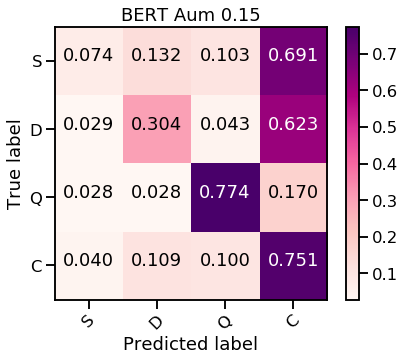

Test_ acc: 0.6777668952007836
Test_ f1 none: [0.09174312 0.22459893 0.5942029  0.79455782]
Test_ f1 macro: 0.4262756928568287


Ejemplo de tweet con label  commenting  y Tw_id  763153119035490306
Encoder Layer 1


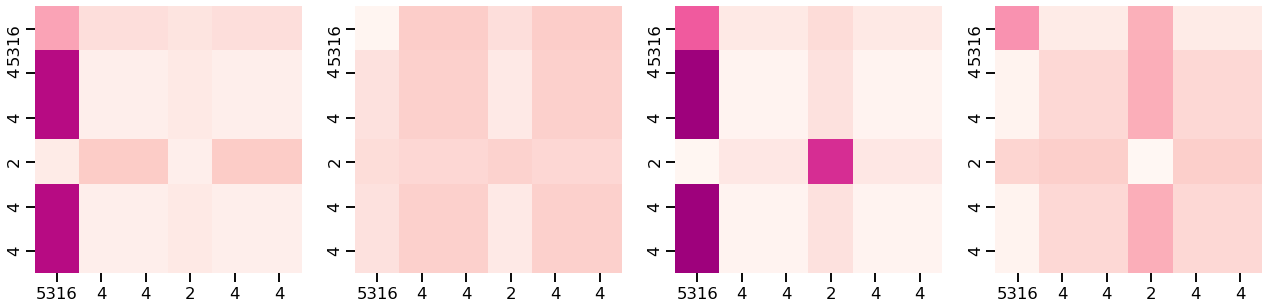

Encoder Layer 2


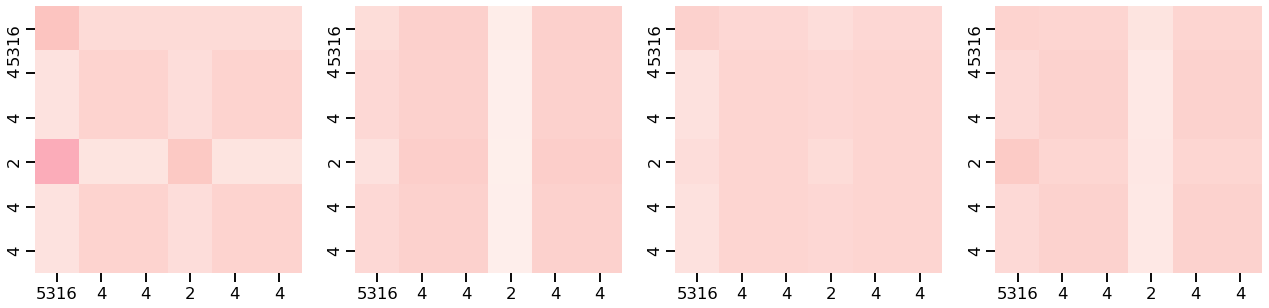



Ejemplo de tweet con label  support  y Tw_id  498295399682441217
Encoder Layer 1


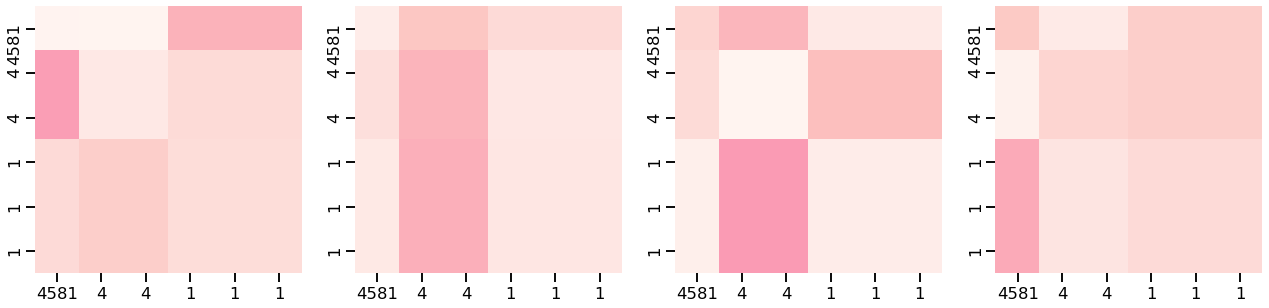

Encoder Layer 2


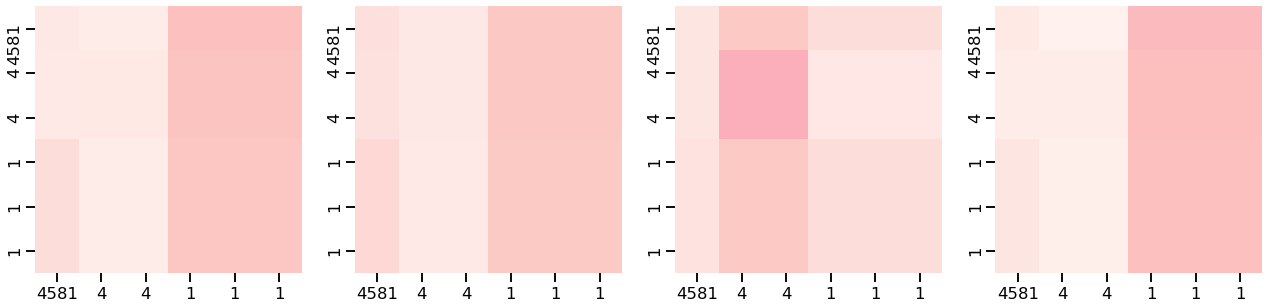



Ejemplo de tweet con label  denying  y Tw_id  580355626926231552
Encoder Layer 1


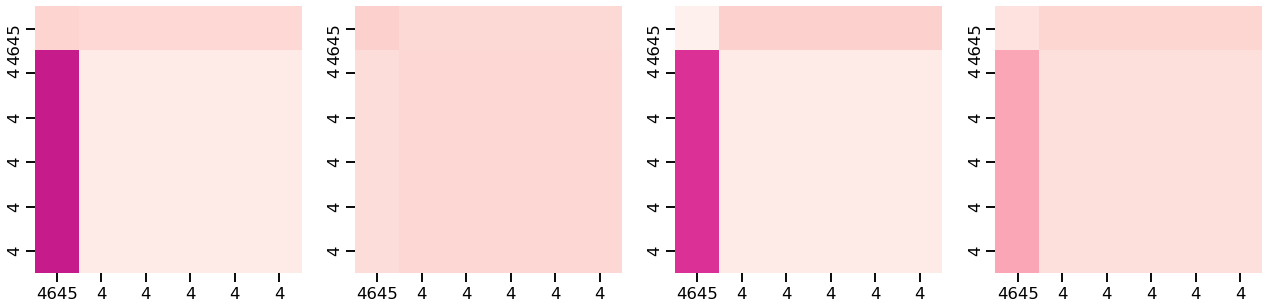

Encoder Layer 2


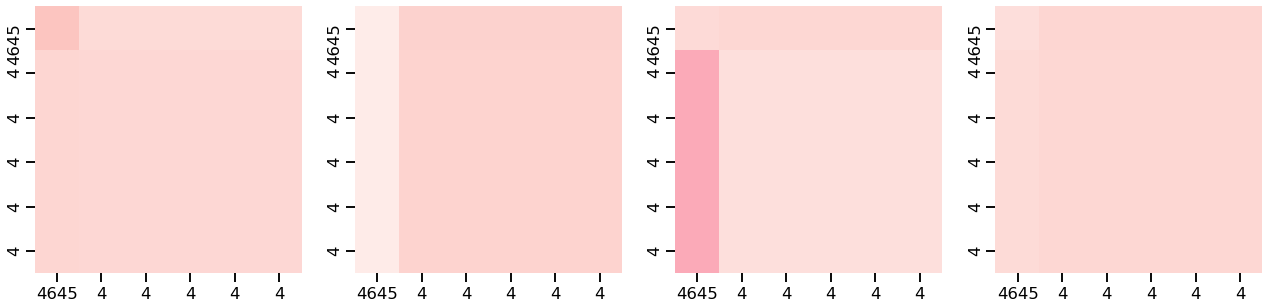



Ejemplo de tweet con label  questioning  y Tw_id  544283072720805890
Encoder Layer 1


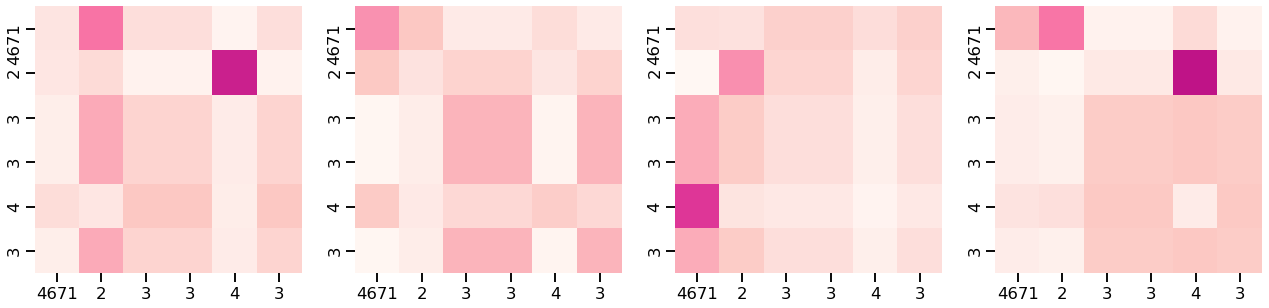

Encoder Layer 2


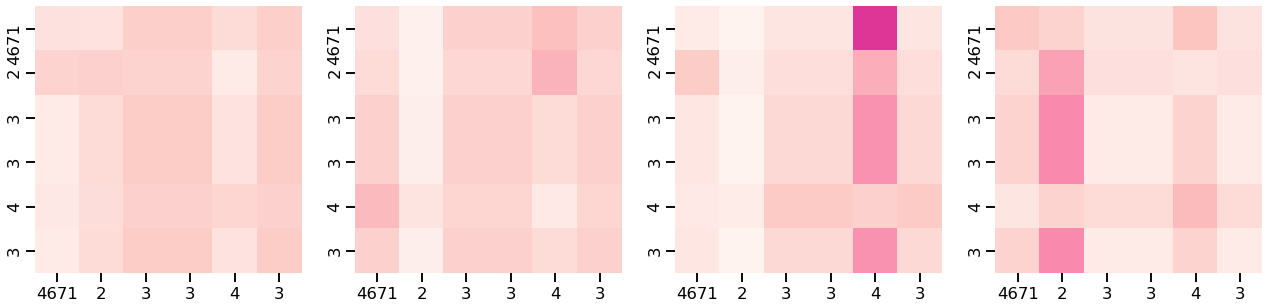

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 2
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.128 	F-macro_val: 0.141
Epoch 10 	acc_val: 0.660 	F-macro_val: 0.493
Epoch 20 	acc_val: 0.663 	F-macro_val: 0.494
Testing run # 2
SE TUVIERON QUE REPETIR 3 EJEMPLOS


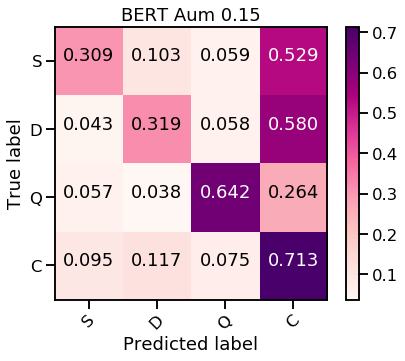

Test_ acc: 0.6523016650342801
Test_ f1 none: [0.24418605 0.22797927 0.56666667 0.77244259]
Test_ f1 macro: 0.4528186441290518


Ejemplo de tweet con label  commenting  y Tw_id  524926238243049473
Encoder Layer 1


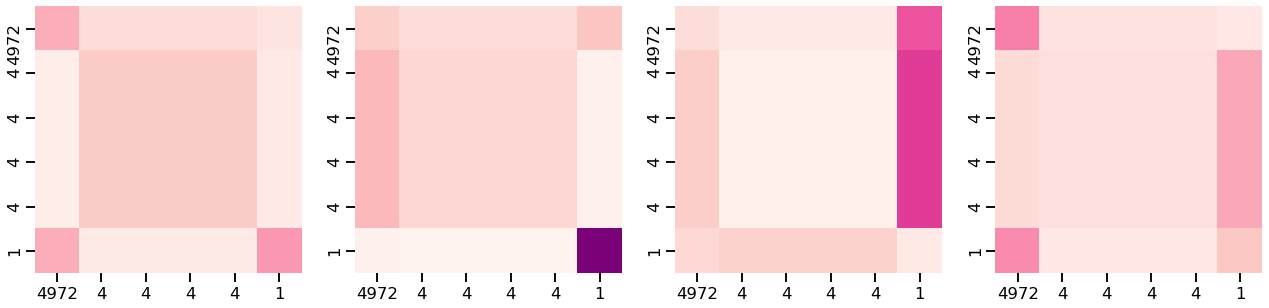

Encoder Layer 2


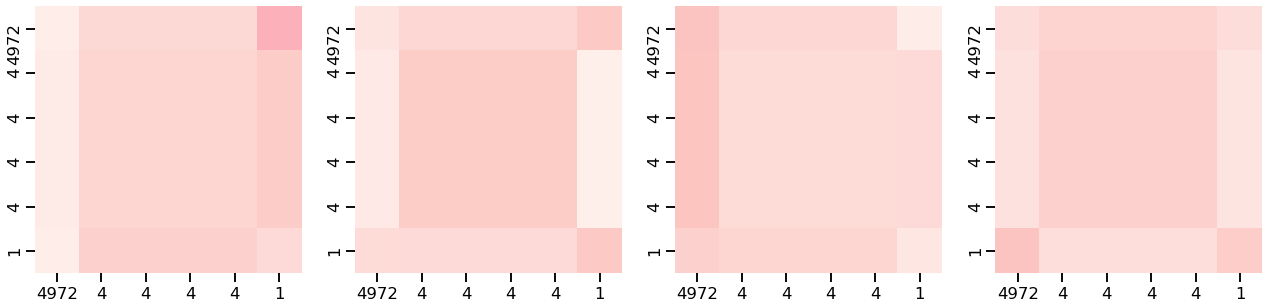



Ejemplo de tweet con label  support  y Tw_id  768898914510475264
Encoder Layer 1


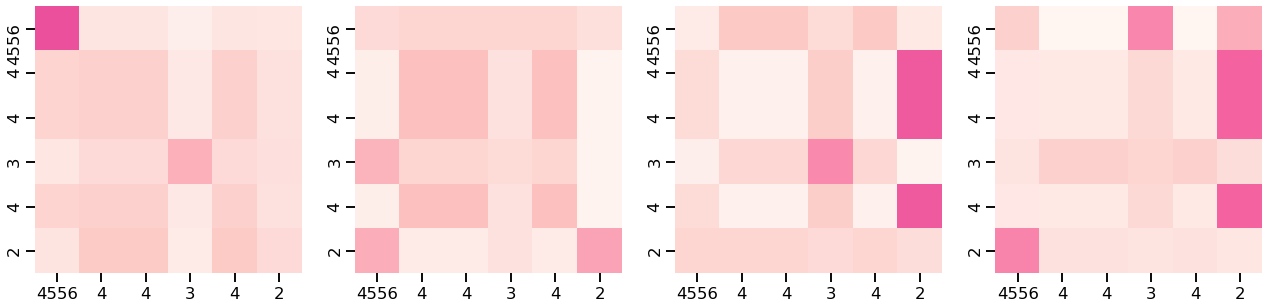

Encoder Layer 2


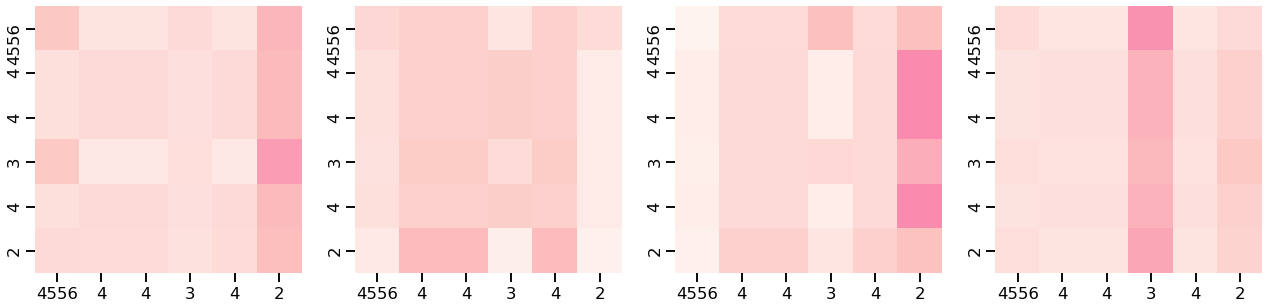



Ejemplo de tweet con label  denying  y Tw_id  764944029922590720
Encoder Layer 1


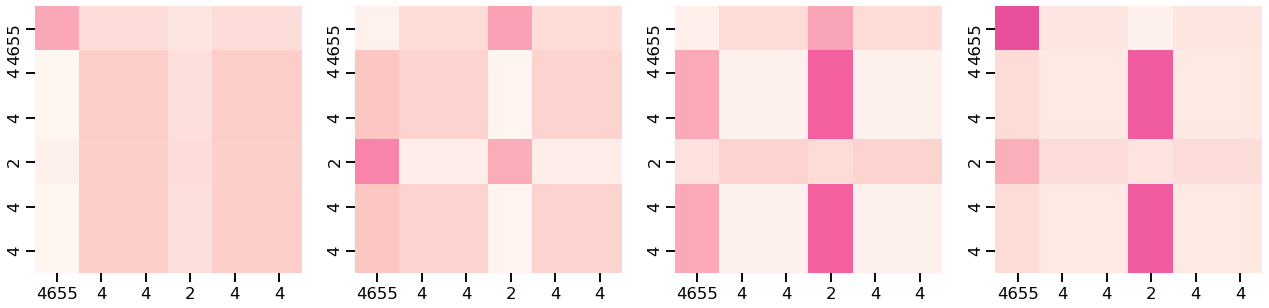

Encoder Layer 2


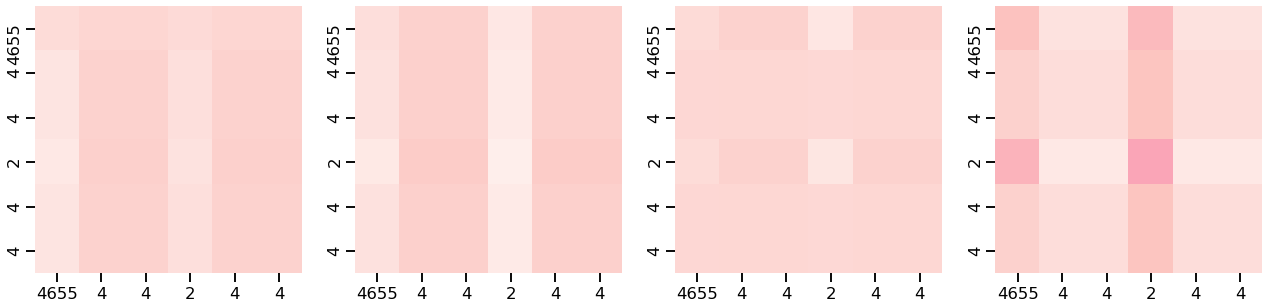



Ejemplo de tweet con label  questioning  y Tw_id  553561561139535872
Encoder Layer 1


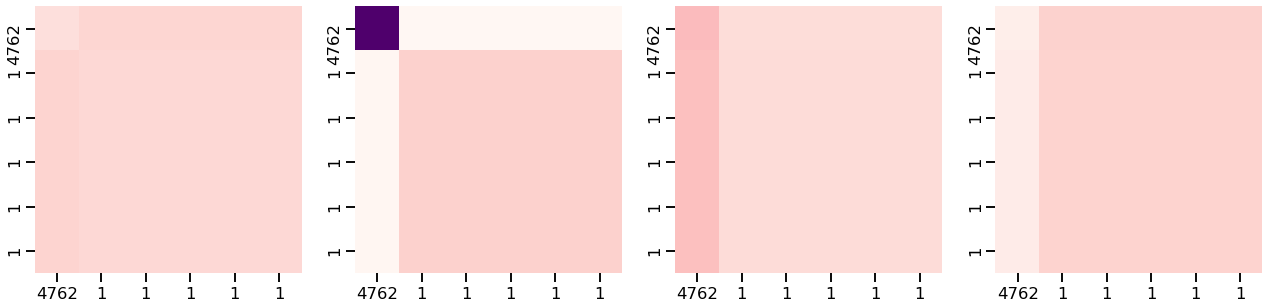

Encoder Layer 2


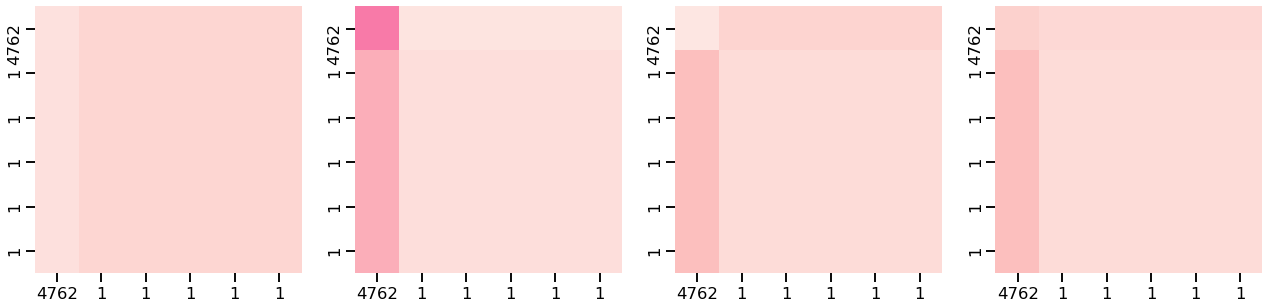

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 3
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.326 	F-macro_val: 0.190
Epoch 10 	acc_val: 0.632 	F-macro_val: 0.500
Epoch 20 	acc_val: 0.635 	F-macro_val: 0.490
Testing run # 3
SE TUVIERON QUE REPETIR 3 EJEMPLOS


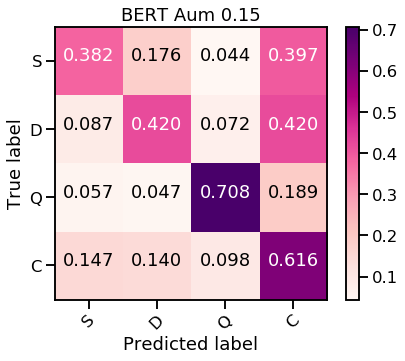

Test_ acc: 0.5964740450538688
Test_ f1 none: [0.23636364 0.25892857 0.56603774 0.71867967]
Test_ f1 macro: 0.44500240338968594
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 4
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.264 	F-macro_val: 0.188
Epoch 10 	acc_val: 0.708 	F-macro_val: 0.521
Epoch 20 	acc_val: 0.705 	F-macro_val: 0.511
Testing run # 4
SE TUVIERON QUE REPETIR 3 EJEMPLOS


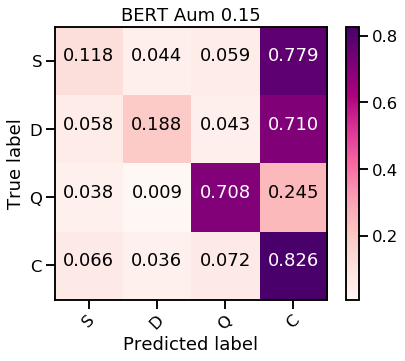

Test_ acc: 0.7238001958863859
Test_ f1 none: [0.11851852 0.22807018 0.6147541  0.83021304]
Test_ f1 macro: 0.4478889582472929
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 5
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.240 	F-macro_val: 0.151
Epoch 10 	acc_val: 0.701 	F-macro_val: 0.538
Epoch 20 	acc_val: 0.705 	F-macro_val: 0.544
Testing run # 5
SE TUVIERON QUE REPETIR 3 EJEMPLOS


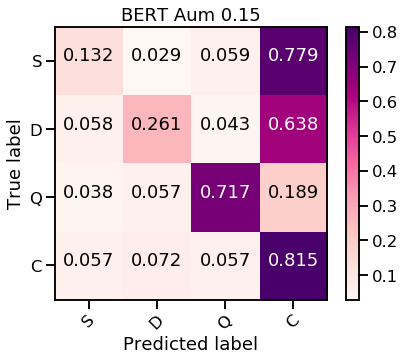

Test_ acc: 0.7218413320274241
Test_ f1 none: [0.13953488 0.2384106  0.65236052 0.8293002 ]
Test_ f1 macro: 0.46490154774388764


Ejemplo de tweet con label  commenting  y Tw_id  524935580996894720
Encoder Layer 1


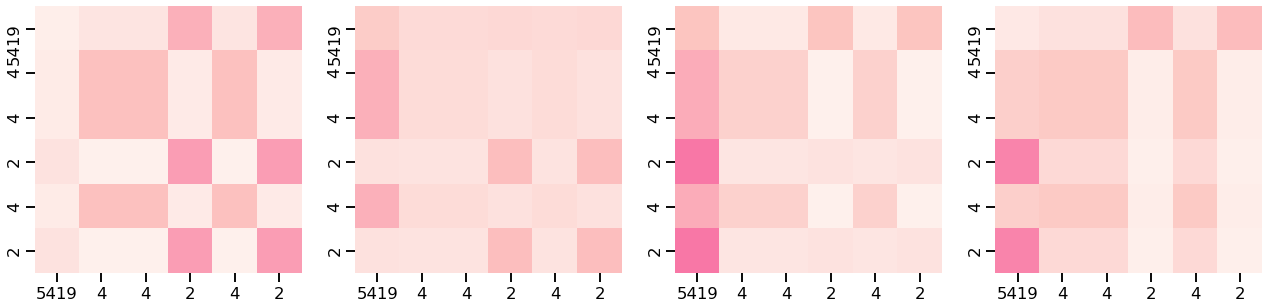

Encoder Layer 2


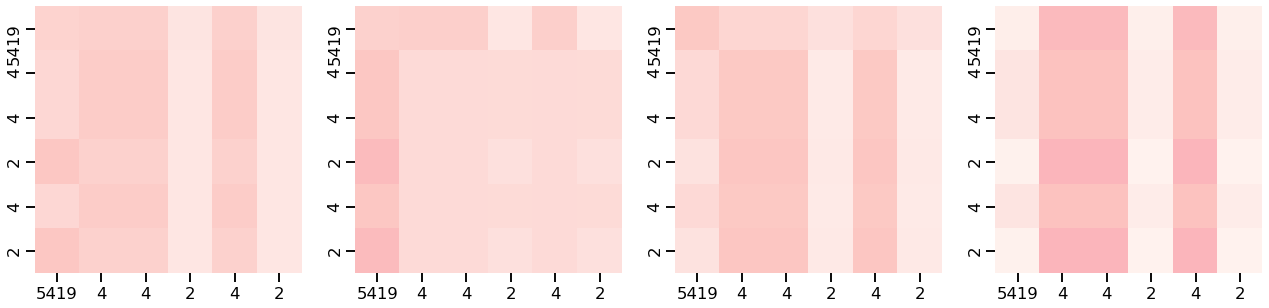



Ejemplo de tweet con label  support  y Tw_id  767730695619751938
Encoder Layer 1


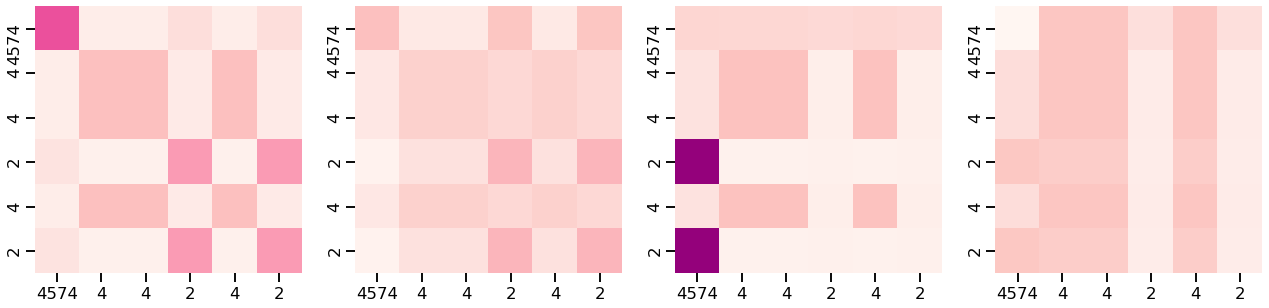

Encoder Layer 2


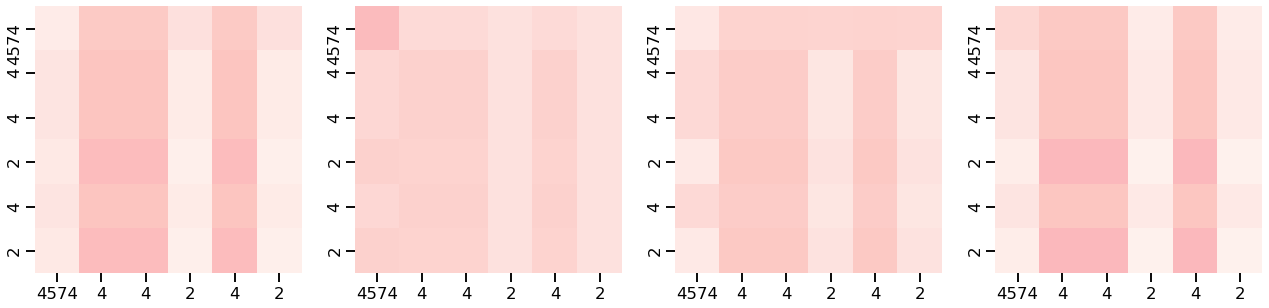



Ejemplo de tweet con label  denying  y Tw_id  581154995640221699
Encoder Layer 1


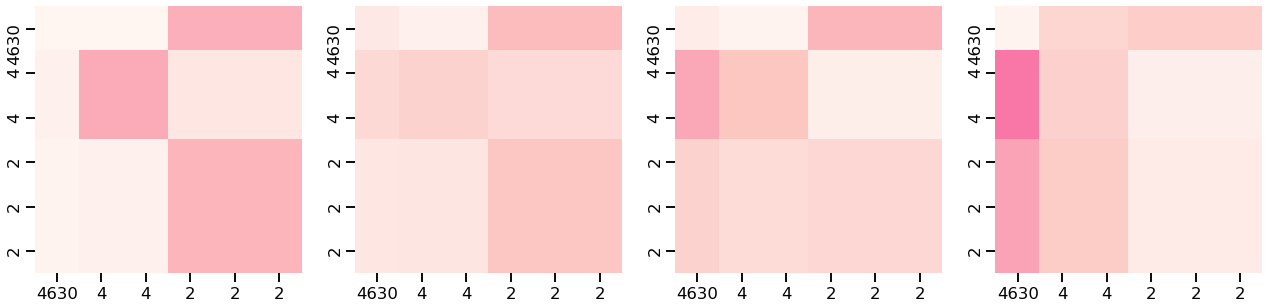

Encoder Layer 2


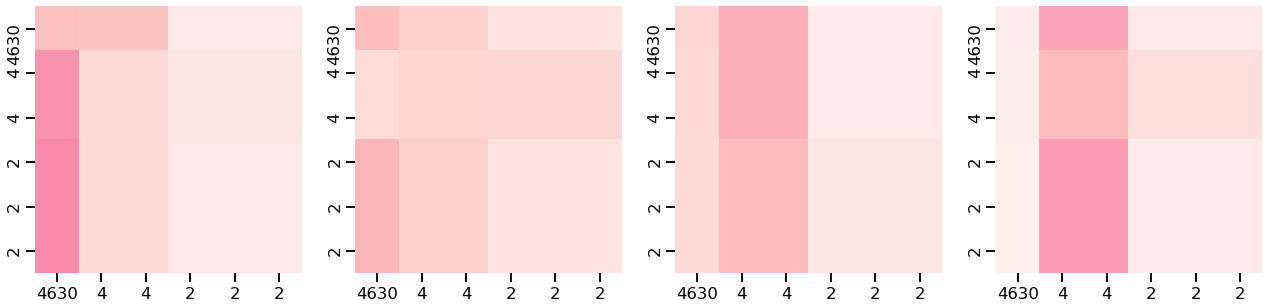



Ejemplo de tweet con label  questioning  y Tw_id  524945273358139392
Encoder Layer 1


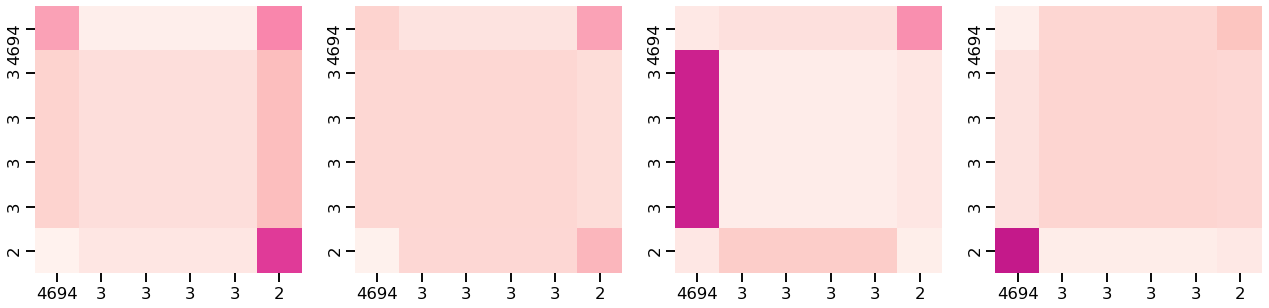

Encoder Layer 2


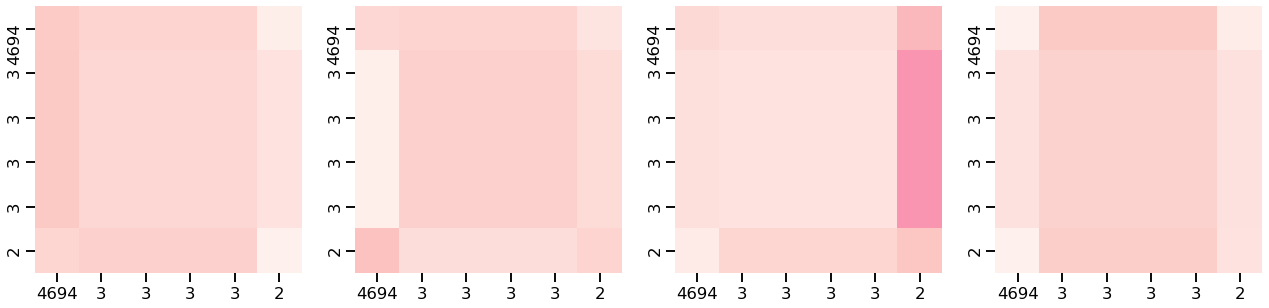

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 6
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.344 	F-macro_val: 0.292
Epoch 10 	acc_val: 0.688 	F-macro_val: 0.505
Epoch 20 	acc_val: 0.708 	F-macro_val: 0.516
Testing run # 6
SE TUVIERON QUE REPETIR 3 EJEMPLOS


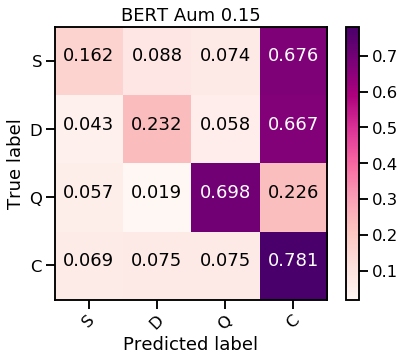

Test_ acc: 0.6944172380019589
Test_ f1 none: [0.15492958 0.21192053 0.59919028 0.80958722]
Test_ f1 macro: 0.4439069019277161
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 7
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.451 	F-macro_val: 0.301
Epoch 10 	acc_val: 0.694 	F-macro_val: 0.542
Epoch 20 	acc_val: 0.698 	F-macro_val: 0.550
Testing run # 7
SE TUVIERON QUE REPETIR 3 EJEMPLOS


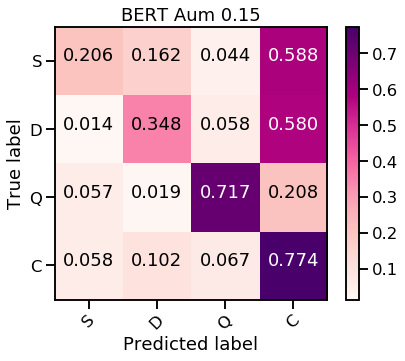

Test_ acc: 0.7012732615083251
Test_ f1 none: [0.20895522 0.25945946 0.63070539 0.81241565]
Test_ f1 macro: 0.4778839330129614


Ejemplo de tweet con label  commenting  y Tw_id  544297327402713088
Encoder Layer 1


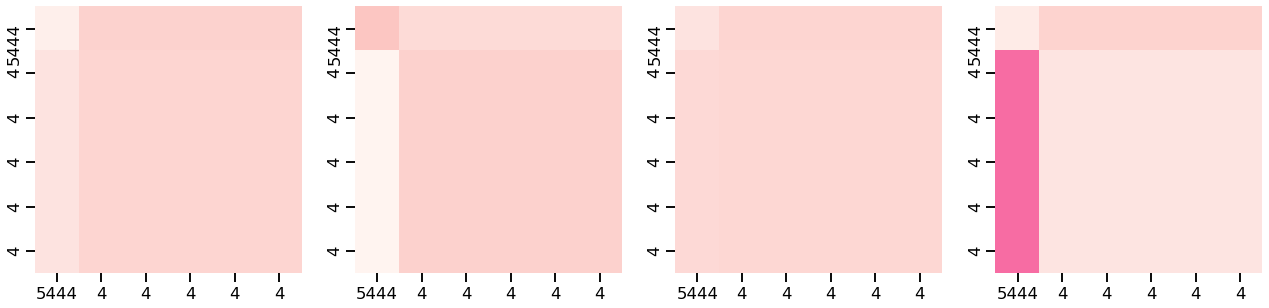

Encoder Layer 2


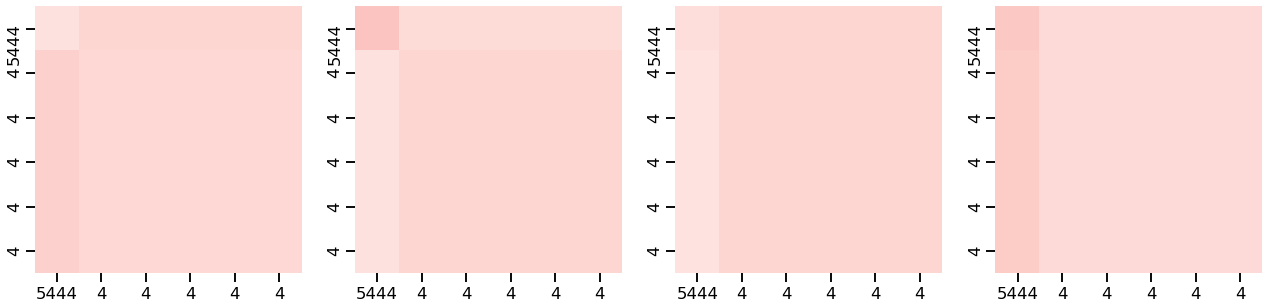



Ejemplo de tweet con label  support  y Tw_id  524942125553954816
Encoder Layer 1


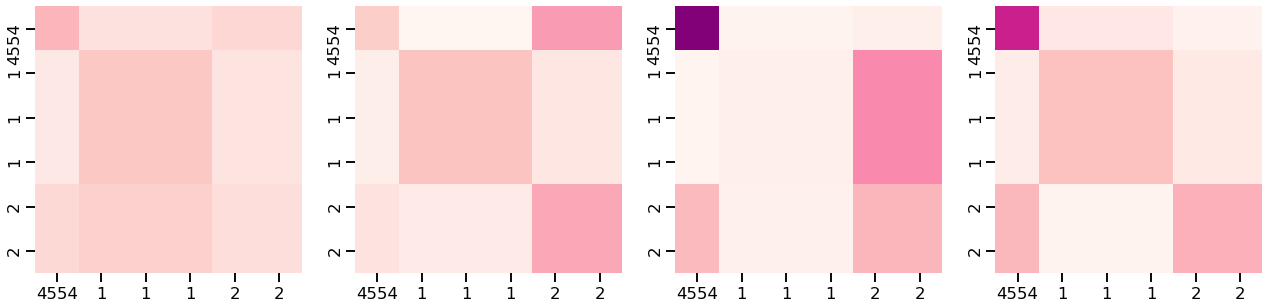

Encoder Layer 2


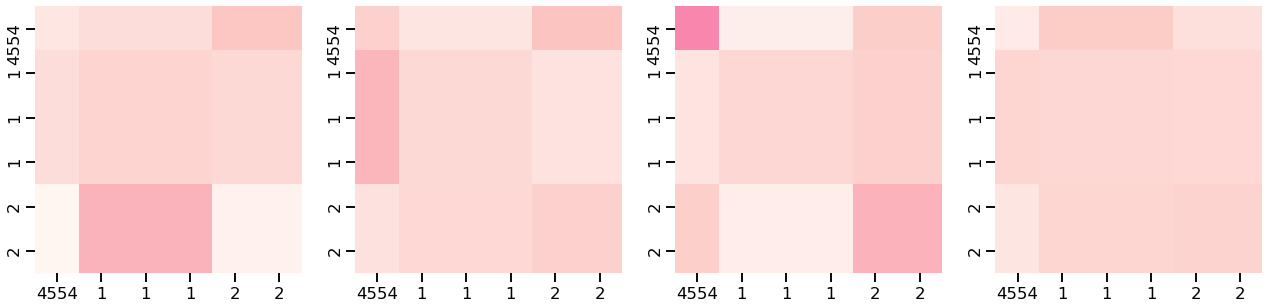



Ejemplo de tweet con label  denying  y Tw_id  758367239011766272
Encoder Layer 1


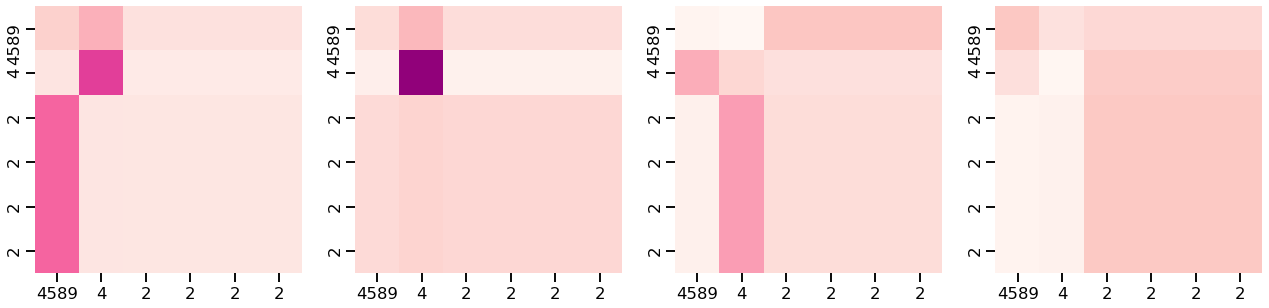

Encoder Layer 2


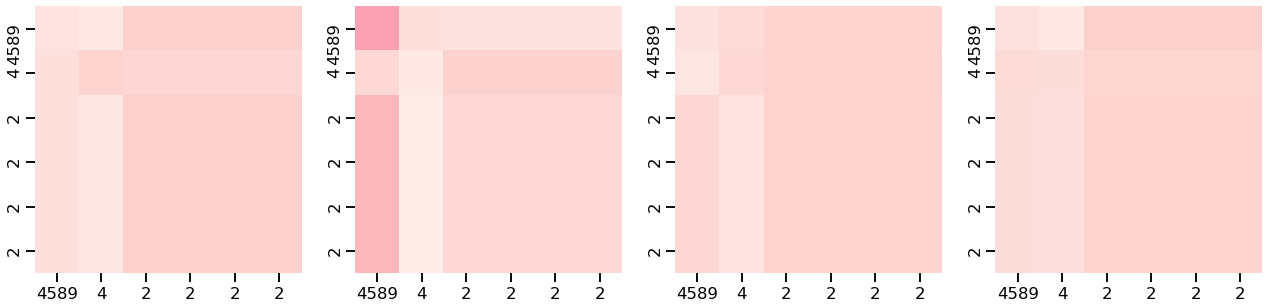



Ejemplo de tweet con label  questioning  y Tw_id  524948710942588928
Encoder Layer 1


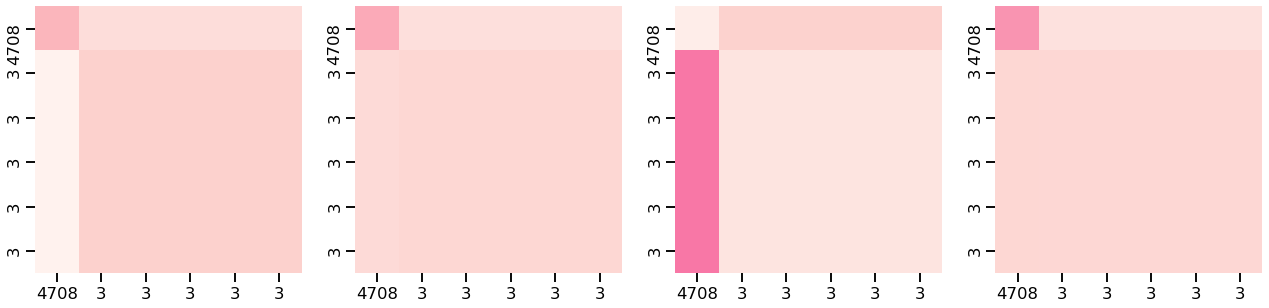

Encoder Layer 2


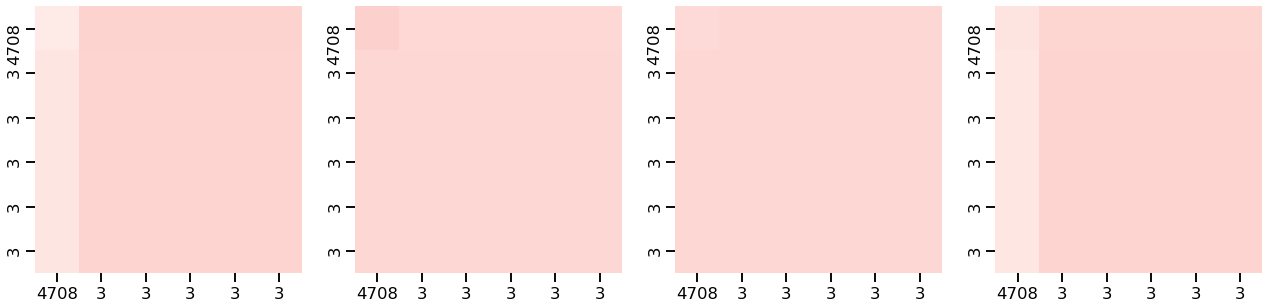

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 8
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.306 	F-macro_val: 0.170
Epoch 10 	acc_val: 0.691 	F-macro_val: 0.530
Epoch 20 	acc_val: 0.694 	F-macro_val: 0.525
Testing run # 8
SE TUVIERON QUE REPETIR 3 EJEMPLOS


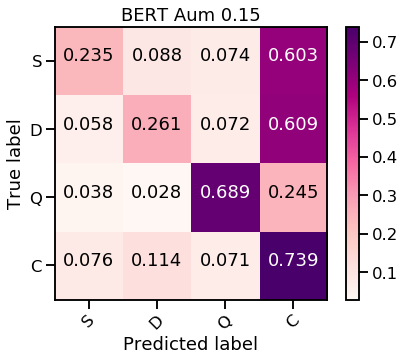

Test_ acc: 0.6679725759059746
Test_ f1 none: [0.21192053 0.19459459 0.59836066 0.78659371]
Test_ f1 macro: 0.44786737184599157
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 9
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.257 	F-macro_val: 0.199
Epoch 10 	acc_val: 0.688 	F-macro_val: 0.504
Epoch 20 	acc_val: 0.698 	F-macro_val: 0.524
Testing run # 9
SE TUVIERON QUE REPETIR 3 EJEMPLOS


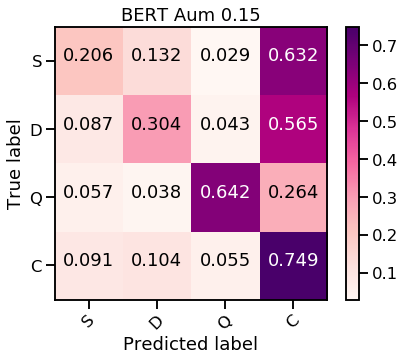

Test_ acc: 0.6718903036238981
Test_ f1 none: [0.16969697 0.22826087 0.61261261 0.79265806]
Test_ f1 macro: 0.45080712690479785
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 10
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.347 	F-macro_val: 0.245
Epoch 10 	acc_val: 0.684 	F-macro_val: 0.535
Epoch 20 	acc_val: 0.705 	F-macro_val: 0.551
Testing run # 10
SE TUVIERON QUE REPETIR 3 EJEMPLOS


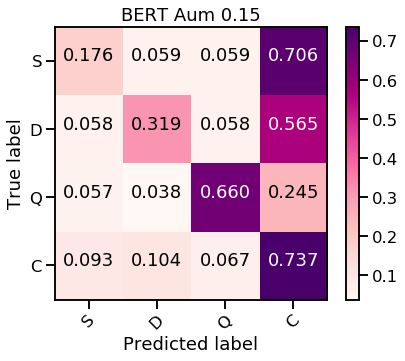

Test_ acc: 0.66307541625857
Test_ f1 none: [0.14814815 0.24444444 0.59322034 0.78278689]
Test_ f1 macro: 0.4421499542053863
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 11
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.240 	F-macro_val: 0.173
Epoch 10 	acc_val: 0.691 	F-macro_val: 0.521
Epoch 20 	acc_val: 0.701 	F-macro_val: 0.522
Testing run # 11
SE TUVIERON QUE REPETIR 3 EJEMPLOS


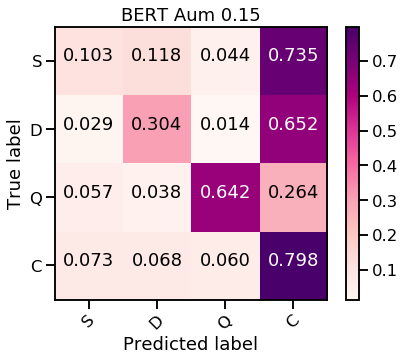

Test_ acc: 0.702252693437806
Test_ f1 none: [0.1        0.27096774 0.60444444 0.81603154]
Test_ f1 macro: 0.44786093095766266
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 12
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.104 	F-macro_val: 0.110
Epoch 10 	acc_val: 0.733 	F-macro_val: 0.578
Epoch 20 	acc_val: 0.743 	F-macro_val: 0.579
Testing run # 12
SE TUVIERON QUE REPETIR 3 EJEMPLOS


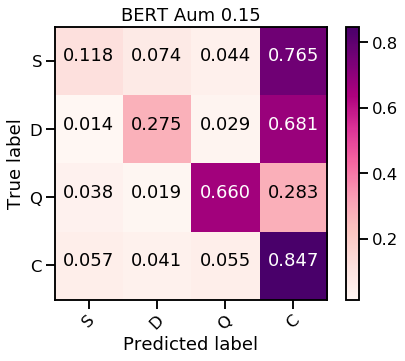

Test_ acc: 0.7404505386875612
Test_ f1 none: [0.128      0.2992126  0.625      0.84163474]
Test_ f1 macro: 0.47346183415291476
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 13
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.569 	F-macro_val: 0.374
Epoch 10 	acc_val: 0.663 	F-macro_val: 0.502
Epoch 20 	acc_val: 0.677 	F-macro_val: 0.519
Testing run # 13
SE TUVIERON QUE REPETIR 3 EJEMPLOS


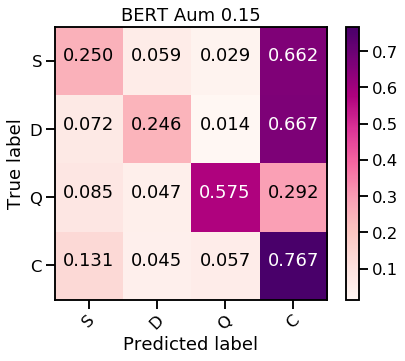

Test_ acc: 0.6777668952007836
Test_ f1 none: [0.16915423 0.26153846 0.57009346 0.79759519]
Test_ f1 macro: 0.44959533467971746
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 14
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.330 	F-macro_val: 0.273
Epoch 10 	acc_val: 0.733 	F-macro_val: 0.551
Epoch 20 	acc_val: 0.708 	F-macro_val: 0.525
Testing run # 14
SE TUVIERON QUE REPETIR 3 EJEMPLOS


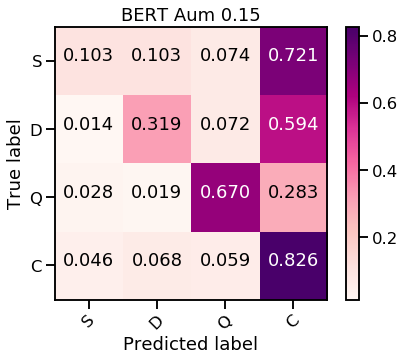

Test_ acc: 0.7277179236043095
Test_ f1 none: [0.12173913 0.2875817  0.60944206 0.83452304]
Test_ f1 macro: 0.46332148171399823
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 15
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test


In [ ]:
best_15, all_accs, all_fno, all_ma, all_cm =train_transformer(0.15, 30, path_a, path_m, "RdPu")

In [24]:
best_15  # array([0.2745098 , 0.21621622, 0.64435146, 0.79863481]

{'F_ma': 0.4834280742149052, 'Run': 15}

In [28]:
all_ma

[0.4262756928568287,
 0.4528186441290518,
 0.44500240338968594,
 0.4478889582472929,
 0.46490154774388764,
 0.4439069019277161,
 0.4778839330129614,
 0.44786737184599157,
 0.45080712690479785,
 0.4421499542053863,
 0.44786093095766266,
 0.47346183415291476,
 0.44959533467971746,
 0.46332148171399823,
 0.4834280742149052,
 0.42387101467369714,
 0.4418214373042218,
 0.460045074536493,
 0.4325468666404234,
 0.4712416749059509]

In [29]:
all_fno

[array([0.092, 0.225, 0.594, 0.795]),
 array([0.244, 0.228, 0.567, 0.772]),
 array([0.236, 0.259, 0.566, 0.719]),
 array([0.119, 0.228, 0.615, 0.83 ]),
 array([0.14 , 0.238, 0.652, 0.829]),
 array([0.155, 0.212, 0.599, 0.81 ]),
 array([0.209, 0.259, 0.631, 0.812]),
 array([0.212, 0.195, 0.598, 0.787]),
 array([0.17 , 0.228, 0.613, 0.793]),
 array([0.148, 0.244, 0.593, 0.783]),
 array([0.1  , 0.271, 0.604, 0.816]),
 array([0.128, 0.299, 0.625, 0.842]),
 array([0.169, 0.262, 0.57 , 0.798]),
 array([0.122, 0.288, 0.609, 0.835]),
 array([0.275, 0.216, 0.644, 0.799]),
 array([0.225, 0.204, 0.536, 0.73 ]),
 array([0.15 , 0.226, 0.582, 0.809]),
 array([0.203, 0.246, 0.618, 0.773]),
 array([0.146, 0.23 , 0.562, 0.792]),
 array([0.218, 0.261, 0.577, 0.829])]

In [31]:
all_accs

[0.6777668952007836,
 0.6523016650342801,
 0.5964740450538688,
 0.7238001958863859,
 0.7218413320274241,
 0.6944172380019589,
 0.7012732615083251,
 0.6679725759059746,
 0.6718903036238981,
 0.66307541625857,
 0.702252693437806,
 0.7404505386875612,
 0.6777668952007836,
 0.7277179236043095,
 0.6885406464250735,
 0.6013712047012733,
 0.693437806072478,
 0.6523016650342801,
 0.6669931439764937,
 0.7198824681684622]

Acc: 0.682 -- deviation: 0.037
F-score: 0.452 -- deviation: 0.016
(0.15) SDQC: 0.17301069812900732 0.24098979863071884 0.5978273904775772 0.7975113643714135


Confusion counts
[[  273.   142.    83.   862.]
 [   63.   408.    79.   830.]
 [  102.    72.  1436.   510.]
 [ 1249.  1407.  1093. 11811.]]


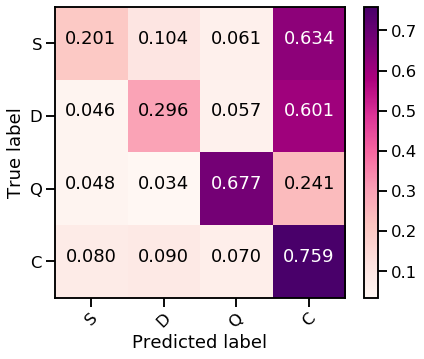

In [27]:
#best_15, all_accs, all_fno, all_ma, all_cm
print ("Acc: %.3f" % np.mean(np.asarray(all_accs)), "-- deviation: %.3f" % np.std(np.asarray(all_accs)))
print ("F-score: %.3f" % np.mean(np.asarray(all_ma)), "-- deviation: %.3f" % np.std(np.asarray(all_ma)))
np.set_printoptions(precision=3)
sup=np.mean(np.asarray(all_fno)[:,0])
den=np.mean(np.asarray(all_fno)[:,1])
que=np.mean(np.asarray(all_fno)[:,2])
com=np.mean(np.asarray(all_fno)[:,3])

print ("(0.15) SDQC:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in all_cm:
    m_temp+=np.asarray(m)
    
print (m_temp)

plot_cm(cm_norma(m_temp),["S","D","Q","C"], "", cmap='RdPu')

## 0.5 mask

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 1
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.278 	F-macro_val: 0.211
Epoch 10 	acc_val: 0.656 	F-macro_val: 0.493
Epoch 20 	acc_val: 0.660 	F-macro_val: 0.499
Testing run # 1
SE TUVIERON QUE REPETIR 3 EJEMPLOS


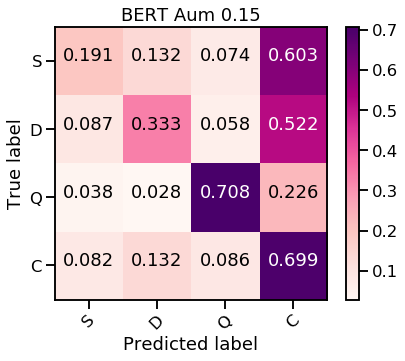

Test_ acc: 0.6415279138099902
Test_ f1 none: [0.168 0.222 0.584 0.765]
Test_ f1 macro: 0.4345509036362408


Ejemplo de tweet con label  commenting  y Tw_id  544280844060213248
Encoder Layer 1


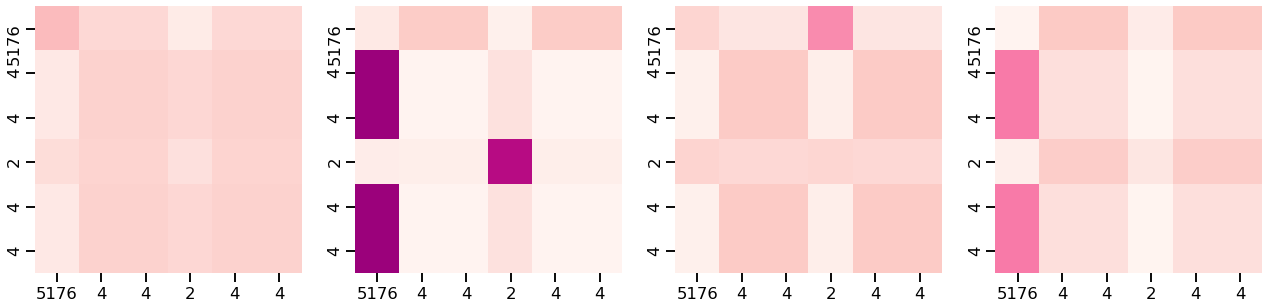

Encoder Layer 2


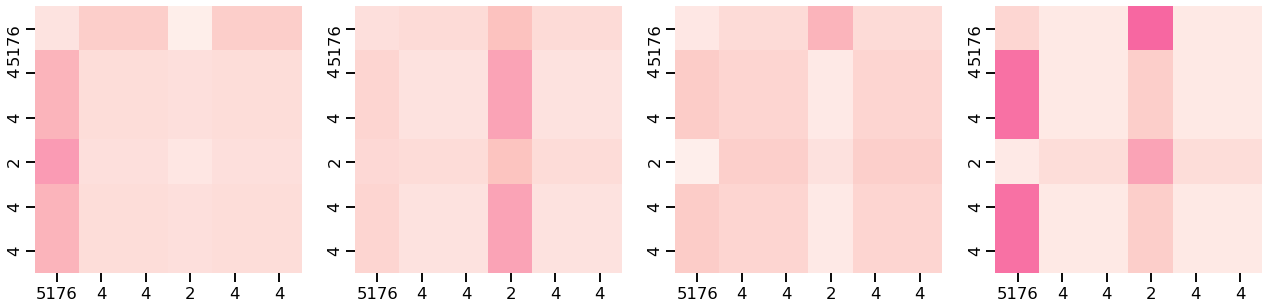



Ejemplo de tweet con label  support  y Tw_id  768863602065416192
Encoder Layer 1


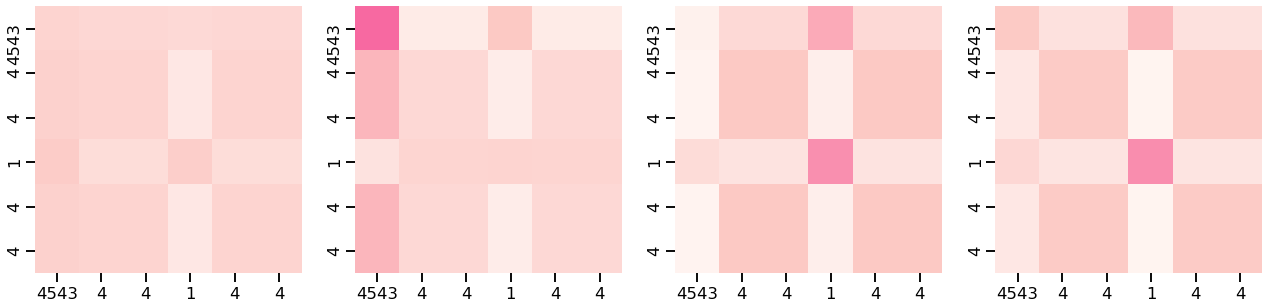

Encoder Layer 2


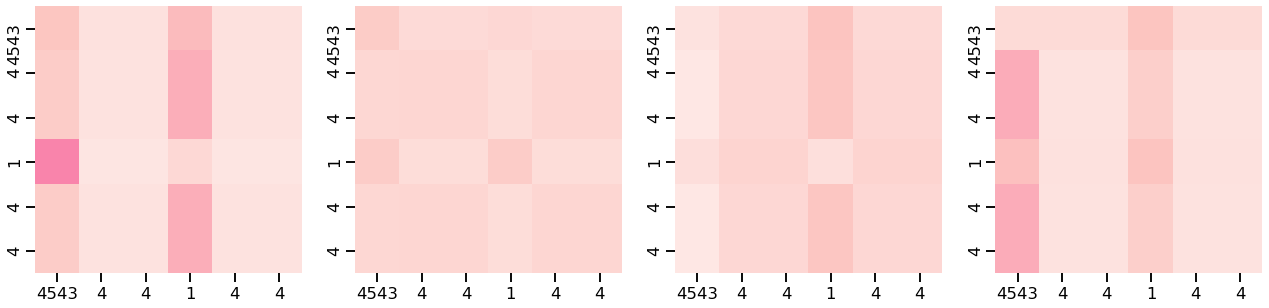



Ejemplo de tweet con label  denying  y Tw_id  758335648541671424
Encoder Layer 1


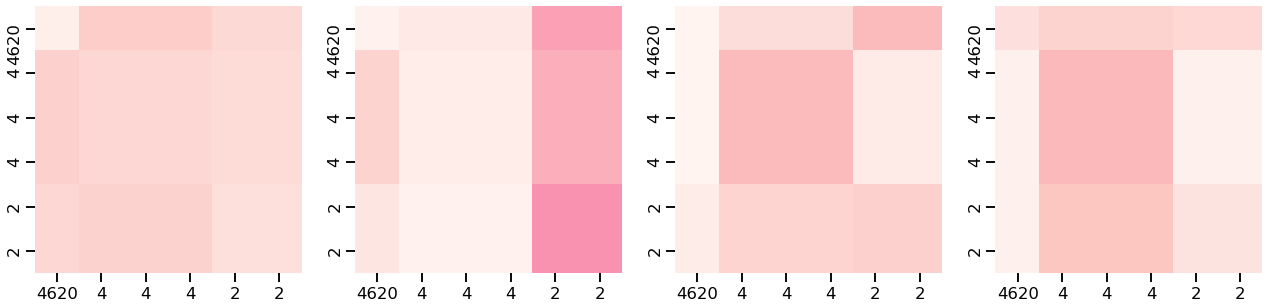

Encoder Layer 2


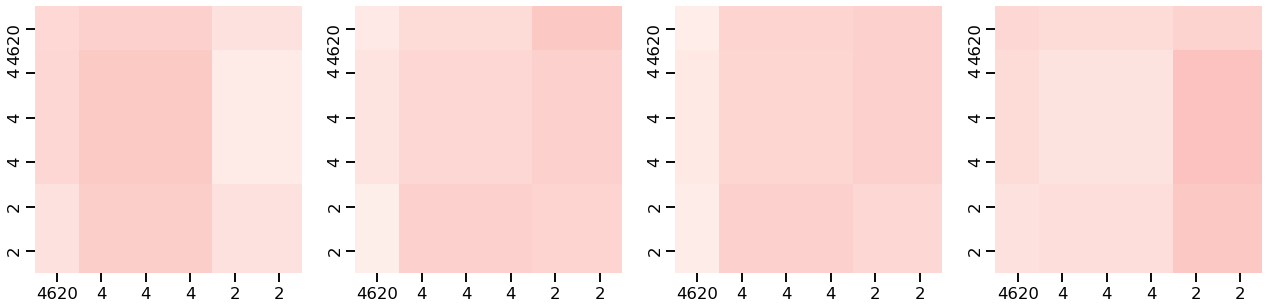



Ejemplo de tweet con label  questioning  y Tw_id  544280004860059648
Encoder Layer 1


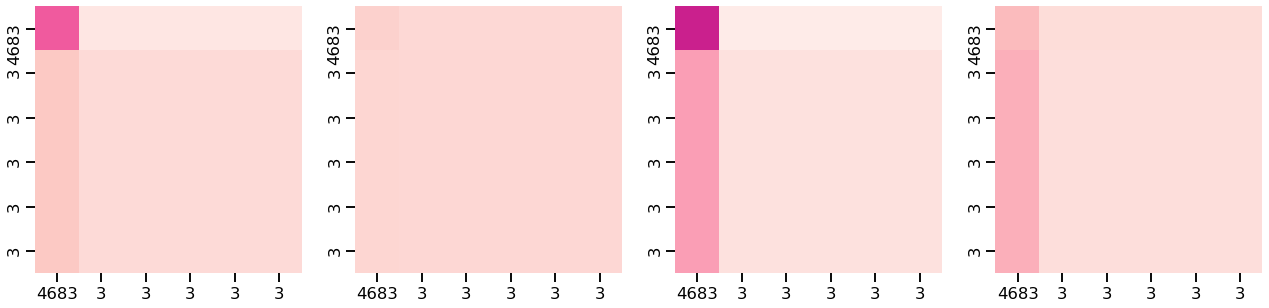

Encoder Layer 2


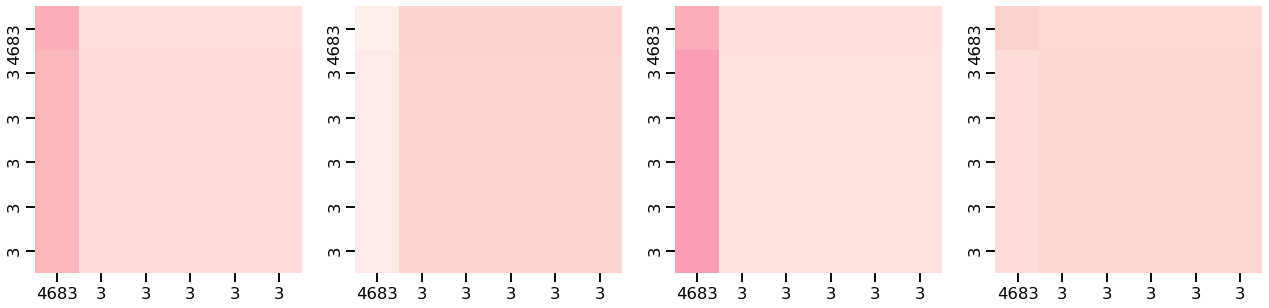

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 2
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.309 	F-macro_val: 0.177
Epoch 10 	acc_val: 0.681 	F-macro_val: 0.488
Epoch 20 	acc_val: 0.688 	F-macro_val: 0.498
Testing run # 2
SE TUVIERON QUE REPETIR 3 EJEMPLOS


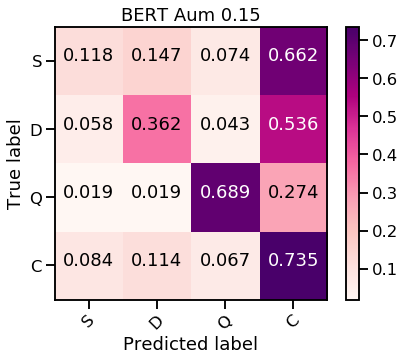

Test_ acc: 0.6640548481880509
Test_ f1 none: [0.109 0.256 0.611 0.783]
Test_ f1 macro: 0.4397894450082174


Ejemplo de tweet con label  commenting  y Tw_id  544365801503879169
Encoder Layer 1


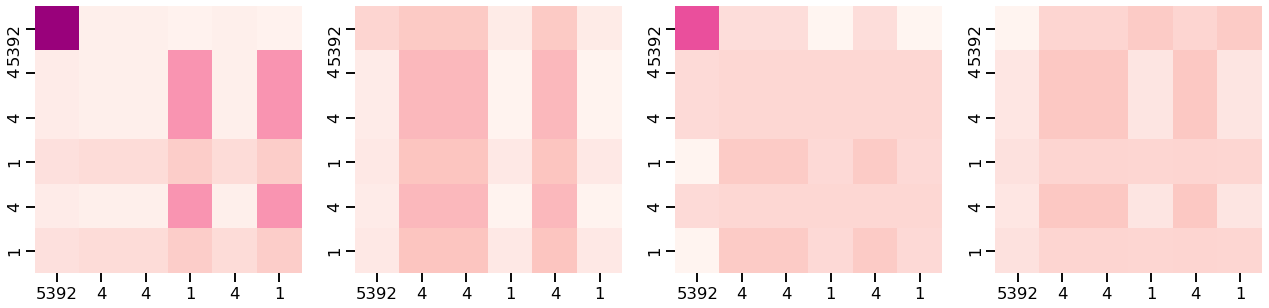

Encoder Layer 2


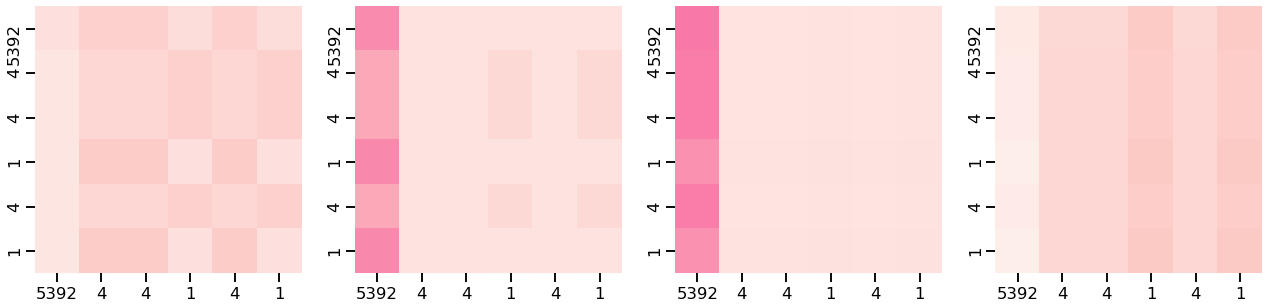



Ejemplo de tweet con label  support  y Tw_id  769993008896995328
Encoder Layer 1


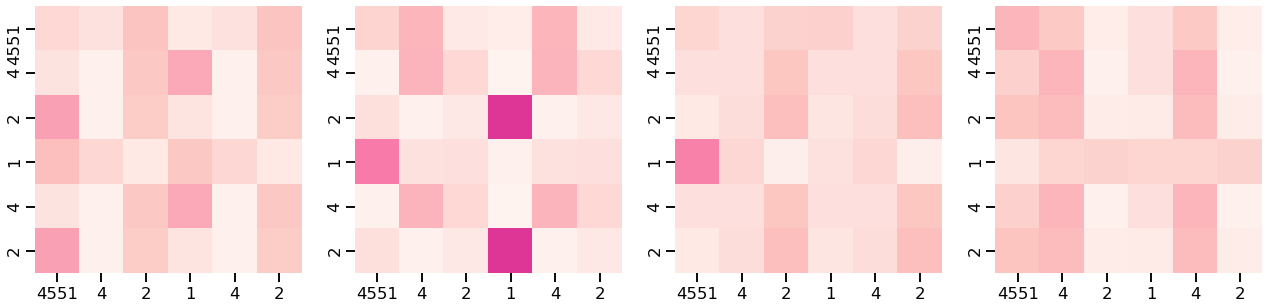

Encoder Layer 2


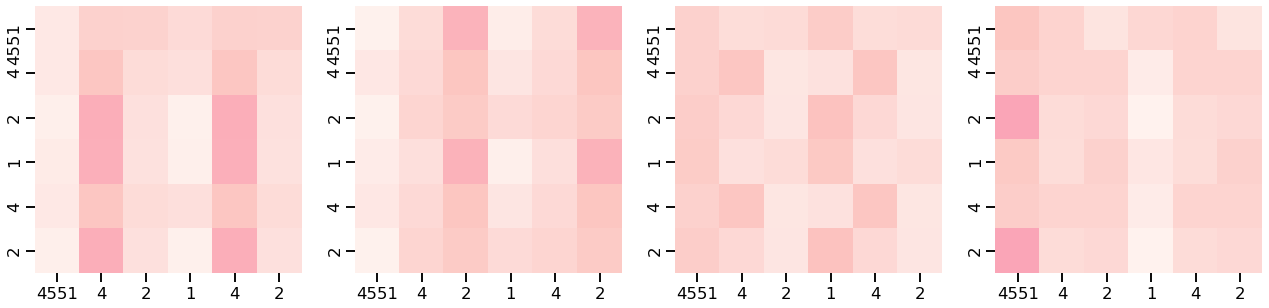



Ejemplo de tweet con label  denying  y Tw_id  498546719244578817
Encoder Layer 1


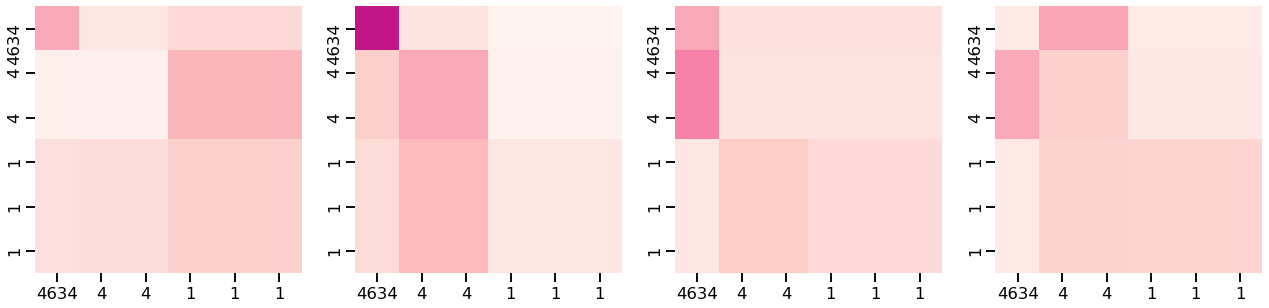

Encoder Layer 2


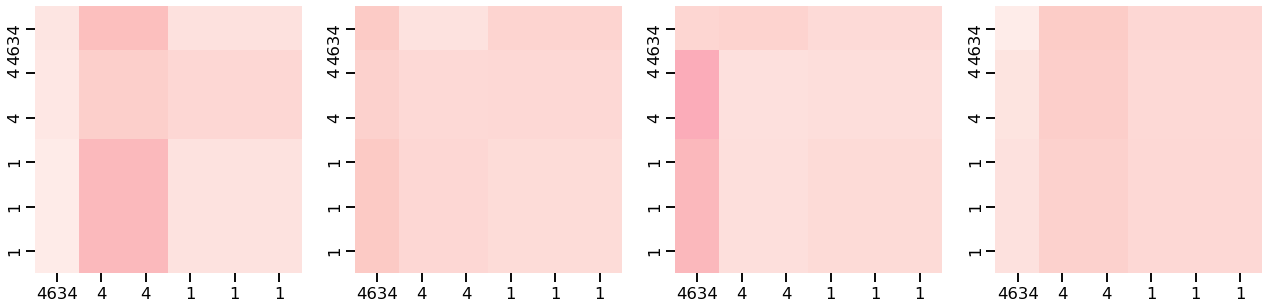



Ejemplo de tweet con label  questioning  y Tw_id  581297818528141313
Encoder Layer 1


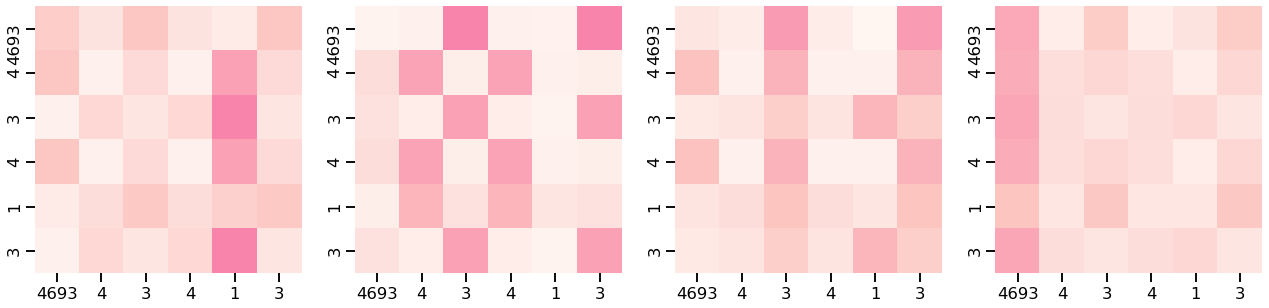

Encoder Layer 2


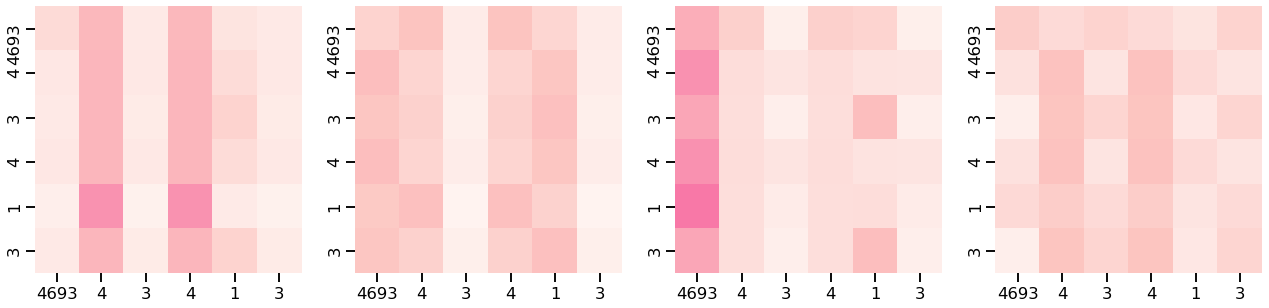

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 3
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.208 	F-macro_val: 0.184
Epoch 10 	acc_val: 0.670 	F-macro_val: 0.530
Epoch 20 	acc_val: 0.649 	F-macro_val: 0.510
Testing run # 3
SE TUVIERON QUE REPETIR 3 EJEMPLOS


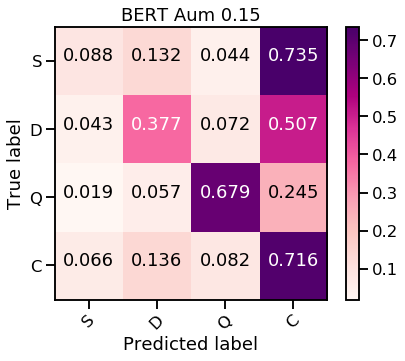

Test_ acc: 0.6474045053868757
Test_ f1 none: [0.092 0.241 0.576 0.77 ]
Test_ f1 macro: 0.4198623848872812
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 4
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.156 	F-macro_val: 0.111
Epoch 10 	acc_val: 0.632 	F-macro_val: 0.484
Epoch 20 	acc_val: 0.653 	F-macro_val: 0.498
Testing run # 4
SE TUVIERON QUE REPETIR 3 EJEMPLOS


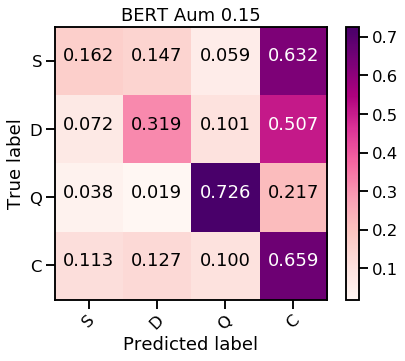

Test_ acc: 0.6101860920666013
Test_ f1 none: [0.125 0.218 0.566 0.737]
Test_ f1 macro: 0.41151680457092366
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 5
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.267 	F-macro_val: 0.186
Epoch 10 	acc_val: 0.667 	F-macro_val: 0.534
Epoch 20 	acc_val: 0.670 	F-macro_val: 0.544
Testing run # 5
SE TUVIERON QUE REPETIR 3 EJEMPLOS


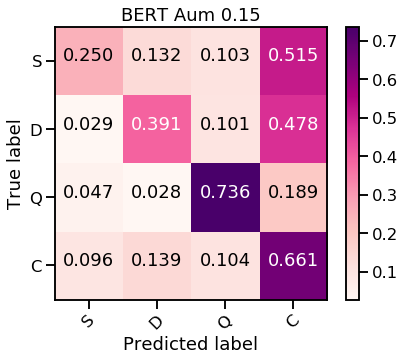

Test_ acc: 0.6229187071498531
Test_ f1 none: [0.204 0.25  0.559 0.745]
Test_ f1 macro: 0.4394150338873445
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 6
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.194 	F-macro_val: 0.152
Epoch 10 	acc_val: 0.635 	F-macro_val: 0.520
Epoch 20 	acc_val: 0.632 	F-macro_val: 0.509
Testing run # 6
SE TUVIERON QUE REPETIR 3 EJEMPLOS


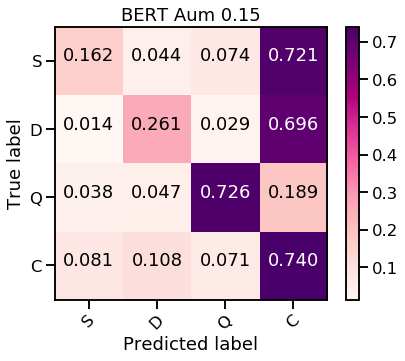

Test_ acc: 0.6679725759059746
Test_ f1 none: [0.15  0.201 0.629 0.783]
Test_ f1 macro: 0.4406223328877483


Ejemplo de tweet con label  commenting  y Tw_id  767741947763167232
Encoder Layer 1


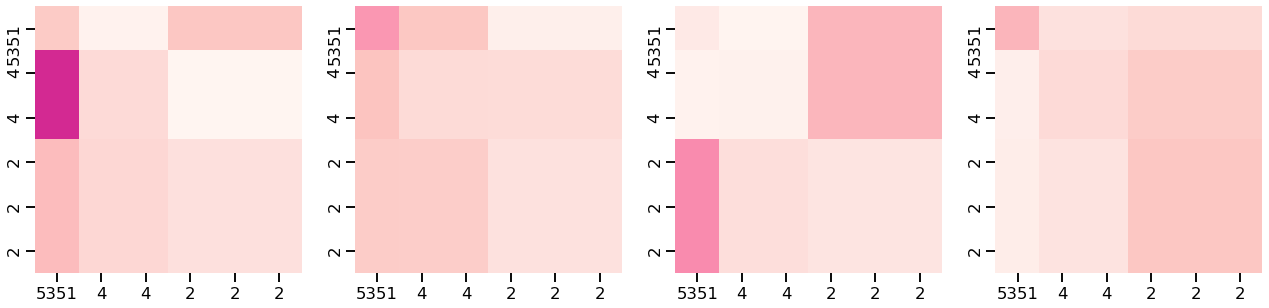

Encoder Layer 2


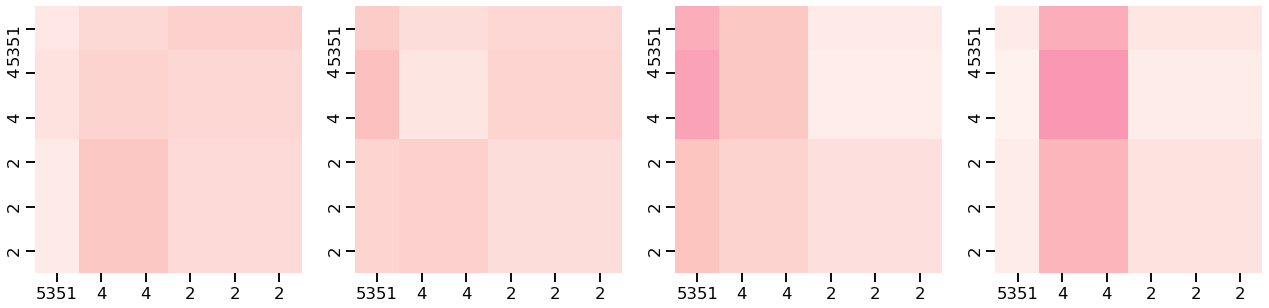



Ejemplo de tweet con label  support  y Tw_id  775075528554389504
Encoder Layer 1


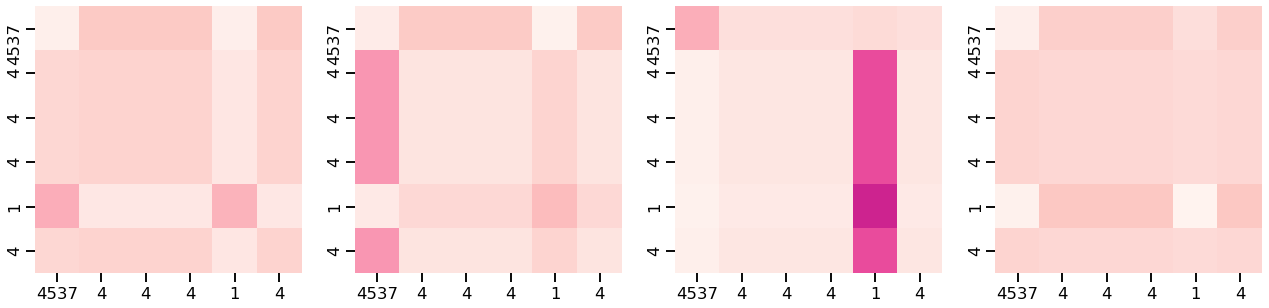

Encoder Layer 2


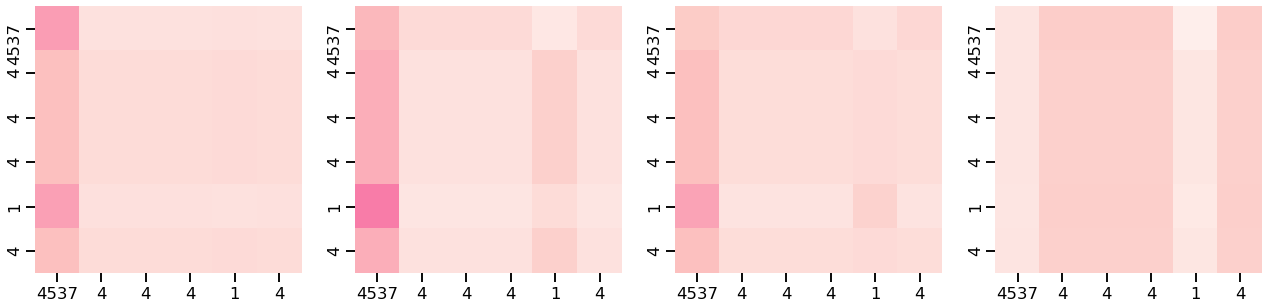



Ejemplo de tweet con label  denying  y Tw_id  765612220860370944
Encoder Layer 1


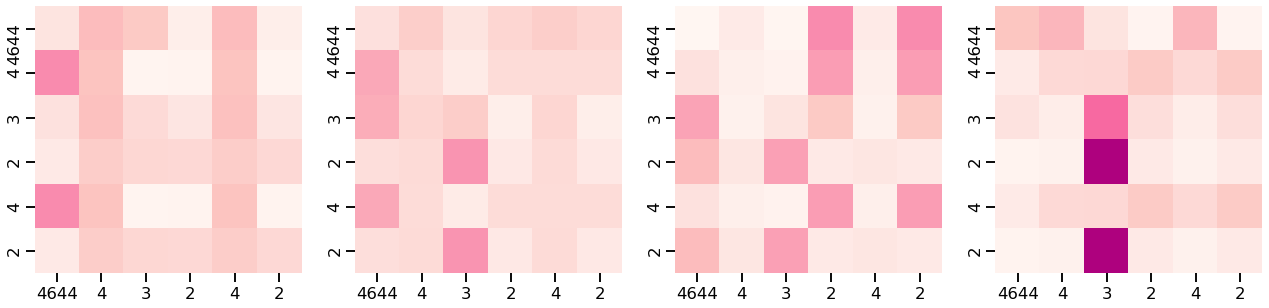

Encoder Layer 2


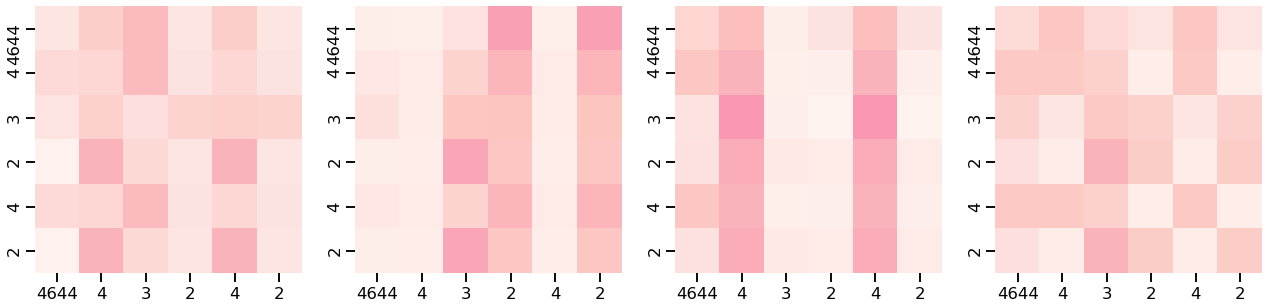



Ejemplo de tweet con label  questioning  y Tw_id  553561561139535872
Encoder Layer 1


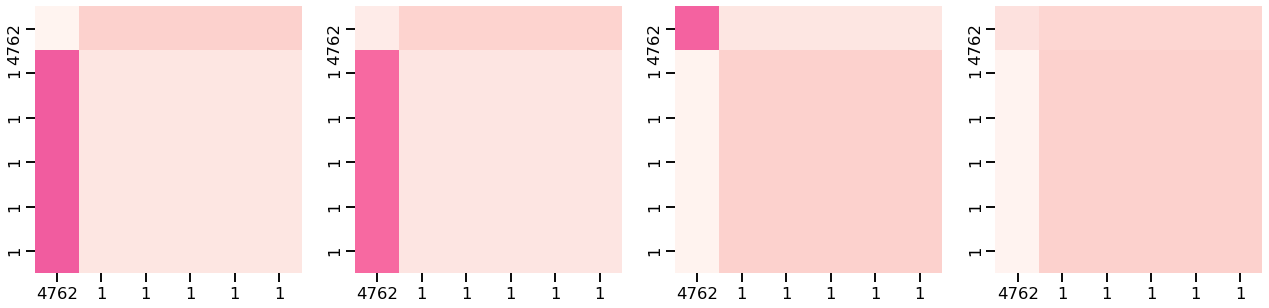

Encoder Layer 2


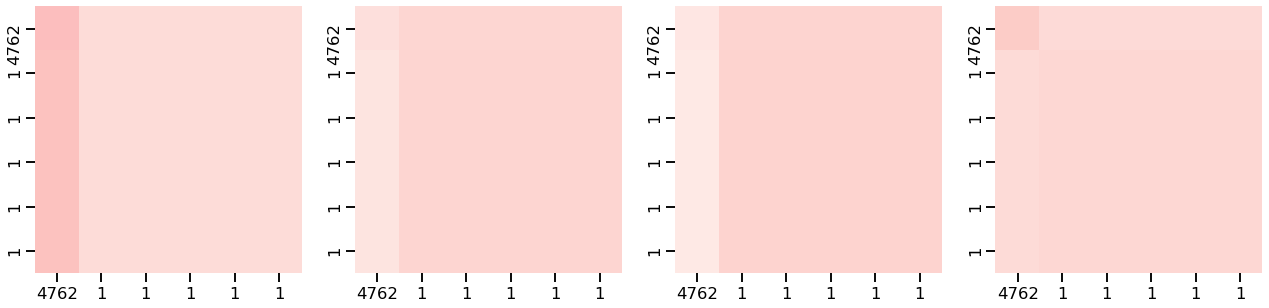

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 7
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.087 	F-macro_val: 0.078
Epoch 10 	acc_val: 0.653 	F-macro_val: 0.490
Epoch 20 	acc_val: 0.681 	F-macro_val: 0.504
Testing run # 7
SE TUVIERON QUE REPETIR 3 EJEMPLOS


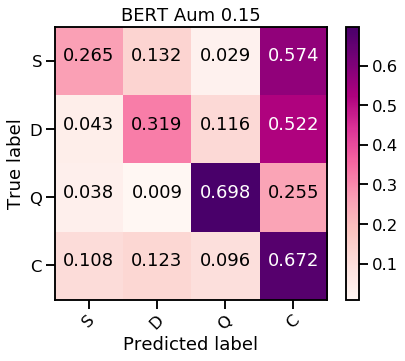

Test_ acc: 0.623898139079334
Test_ f1 none: [0.203 0.223 0.558 0.746]
Test_ f1 macro: 0.4326939776275309
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 8
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.208 	F-macro_val: 0.134
Epoch 10 	acc_val: 0.674 	F-macro_val: 0.523
Epoch 20 	acc_val: 0.667 	F-macro_val: 0.514
Testing run # 8
SE TUVIERON QUE REPETIR 3 EJEMPLOS


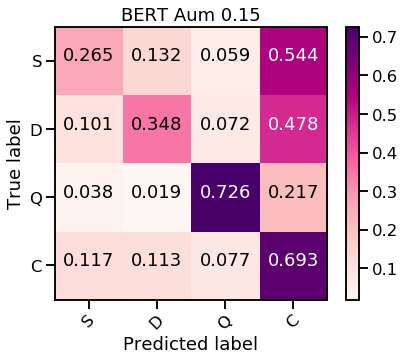

Test_ acc: 0.6444662095984329
Test_ f1 none: [0.191 0.25  0.611 0.765]
Test_ f1 macro: 0.4542848699763593


Ejemplo de tweet con label  commenting  y Tw_id  758424568260333570
Encoder Layer 1


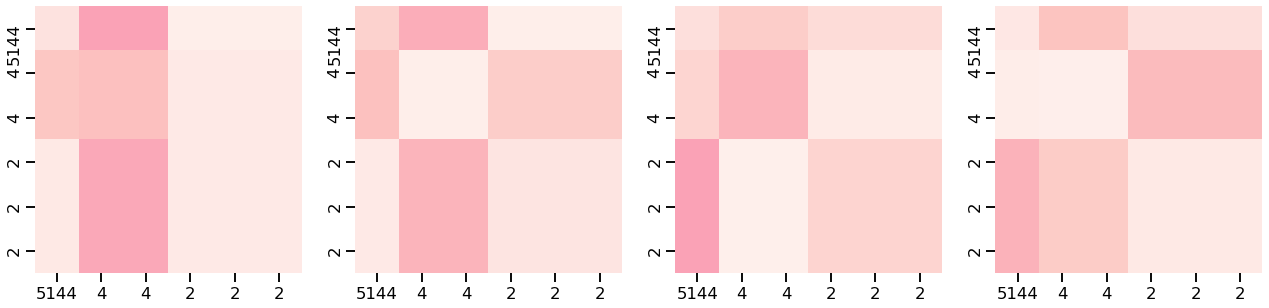

Encoder Layer 2


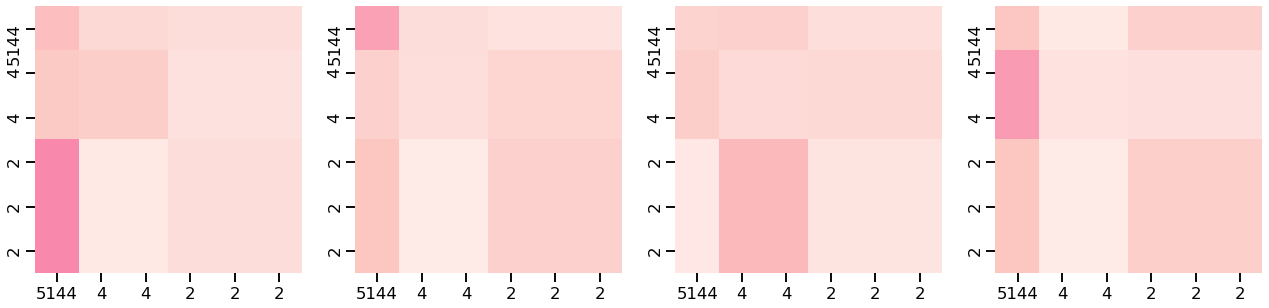



Ejemplo de tweet con label  support  y Tw_id  553574606259625984
Encoder Layer 1


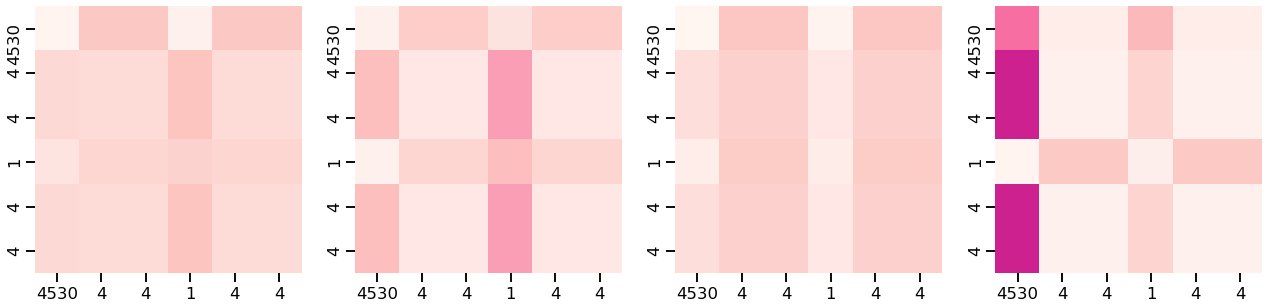

Encoder Layer 2


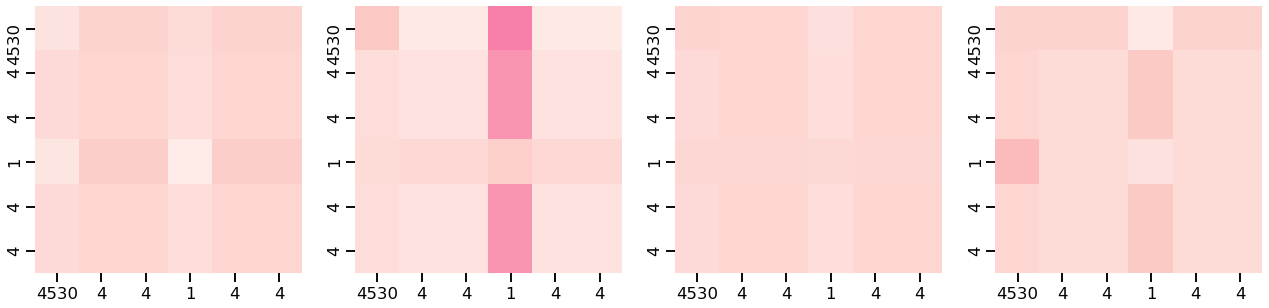



Ejemplo de tweet con label  denying  y Tw_id  767745760570044416
Encoder Layer 1


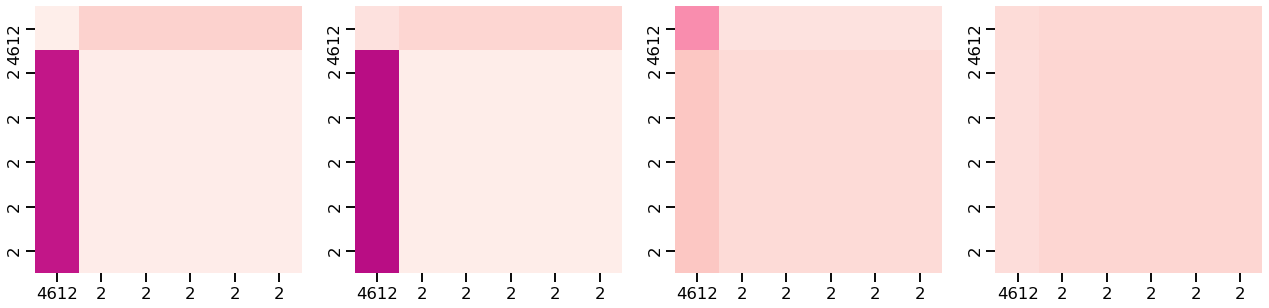

Encoder Layer 2


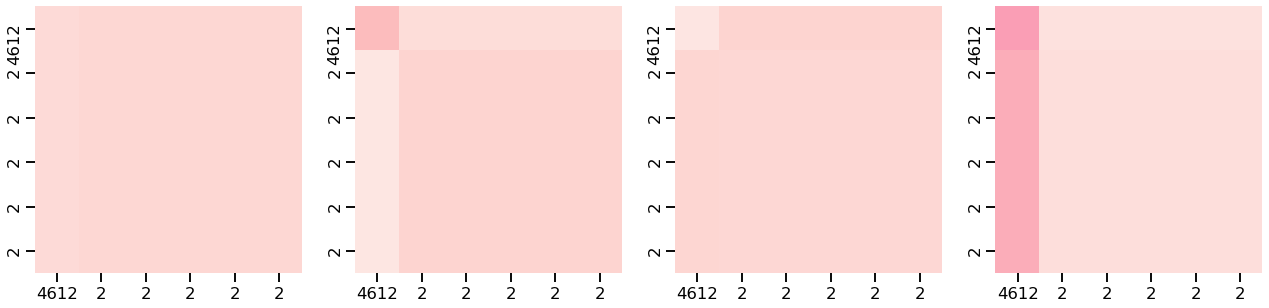



Ejemplo de tweet con label  questioning  y Tw_id  758346105415344128
Encoder Layer 1


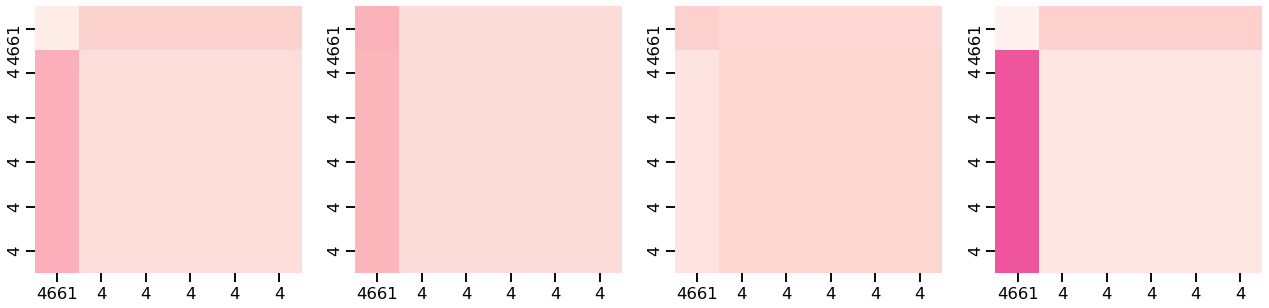

Encoder Layer 2


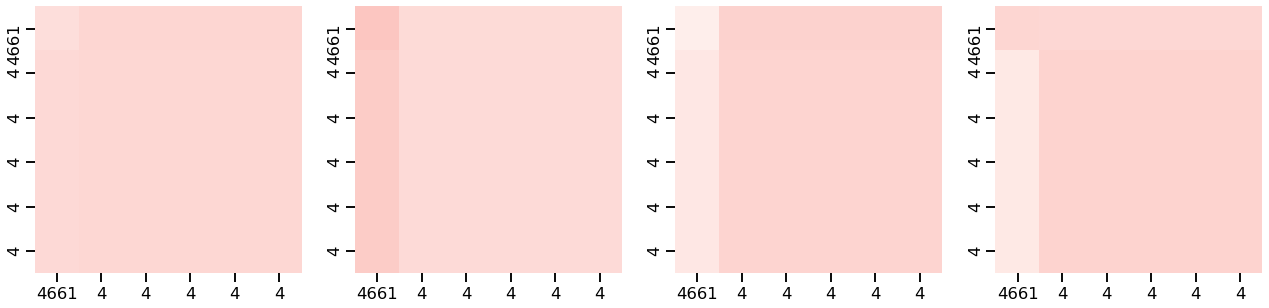

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 9
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.250 	F-macro_val: 0.230
Epoch 10 	acc_val: 0.642 	F-macro_val: 0.482
Epoch 20 	acc_val: 0.660 	F-macro_val: 0.502
Testing run # 9
SE TUVIERON QUE REPETIR 3 EJEMPLOS


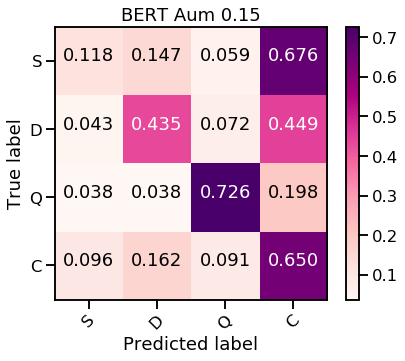

Test_ acc: 0.6082272282076395
Test_ f1 none: [0.101 0.251 0.586 0.732]
Test_ f1 macro: 0.41753381203810896
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 10
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.385 	F-macro_val: 0.318
Epoch 10 	acc_val: 0.670 	F-macro_val: 0.483
Epoch 20 	acc_val: 0.681 	F-macro_val: 0.490
Testing run # 10
SE TUVIERON QUE REPETIR 3 EJEMPLOS


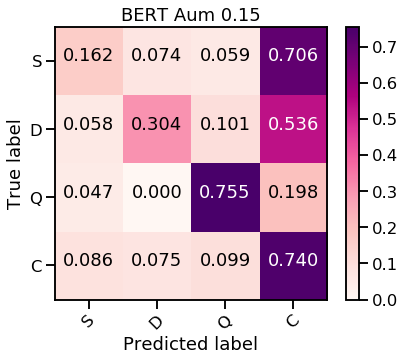

Test_ acc: 0.67384916748286
Test_ f1 none: [0.142 0.275 0.584 0.789]
Test_ f1 macro: 0.4473569973805909
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 11
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.181 	F-macro_val: 0.119
Epoch 10 	acc_val: 0.660 	F-macro_val: 0.479
Epoch 20 	acc_val: 0.660 	F-macro_val: 0.518
Testing run # 11
SE TUVIERON QUE REPETIR 3 EJEMPLOS


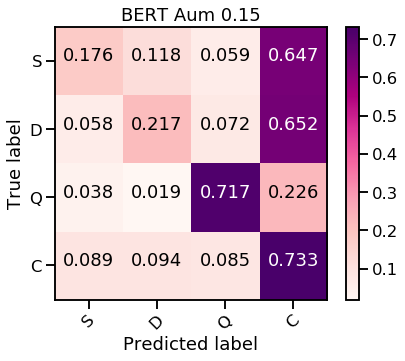

Test_ acc: 0.6591576885406464
Test_ f1 none: [0.153 0.18  0.591 0.78 ]
Test_ f1 macro: 0.4260585309124232
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 12
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.292 	F-macro_val: 0.200
Epoch 10 	acc_val: 0.660 	F-macro_val: 0.521
Epoch 20 	acc_val: 0.708 	F-macro_val: 0.561
Testing run # 12
SE TUVIERON QUE REPETIR 3 EJEMPLOS


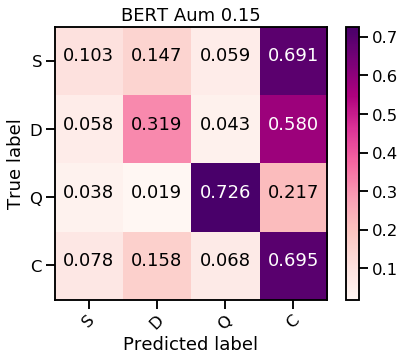

Test_ acc: 0.633692458374143
Test_ f1 none: [0.097 0.195 0.634 0.757]
Test_ f1 macro: 0.42070754795539567
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 13
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.292 	F-macro_val: 0.181
Epoch 10 	acc_val: 0.677 	F-macro_val: 0.486
Epoch 20 	acc_val: 0.656 	F-macro_val: 0.490
Testing run # 13
SE TUVIERON QUE REPETIR 3 EJEMPLOS


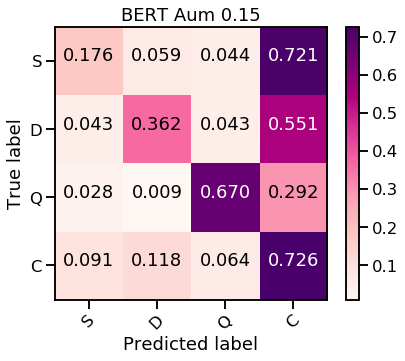

Test_ acc: 0.6591576885406464
Test_ f1 none: [0.153 0.262 0.609 0.773]
Test_ f1 macro: 0.44938281355022847
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 14
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.222 	F-macro_val: 0.169
Epoch 10 	acc_val: 0.642 	F-macro_val: 0.473
Epoch 20 	acc_val: 0.660 	F-macro_val: 0.478
Testing run # 14
SE TUVIERON QUE REPETIR 3 EJEMPLOS


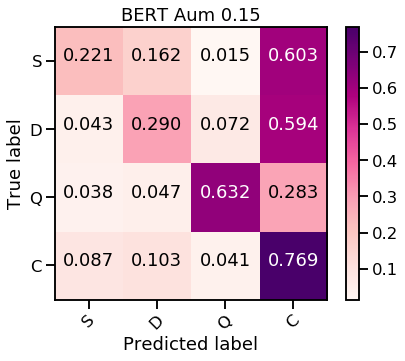

Test_ acc: 0.6856023506366308
Test_ f1 none: [0.19  0.216 0.635 0.804]
Test_ f1 macro: 0.46123104121133596


Ejemplo de tweet con label  commenting  y Tw_id  524962170166317056
Encoder Layer 1


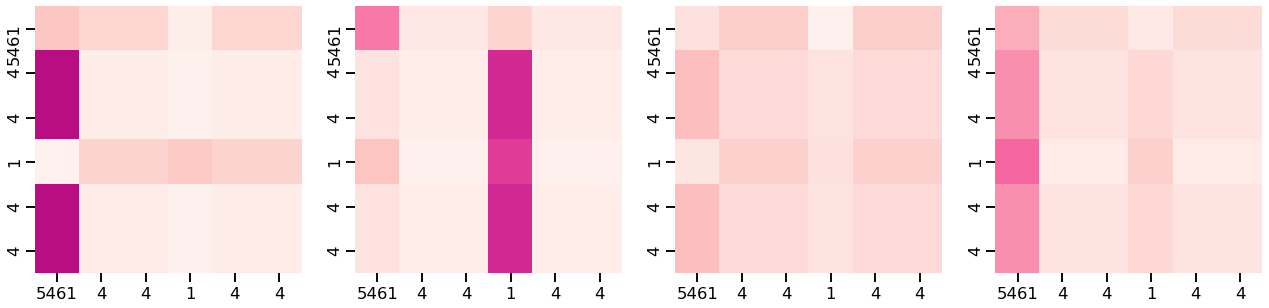

Encoder Layer 2


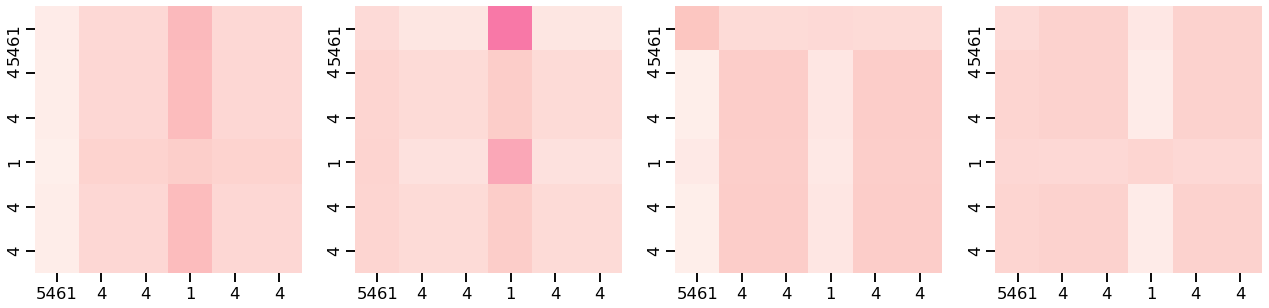



Ejemplo de tweet con label  support  y Tw_id  767727622046511104
Encoder Layer 1


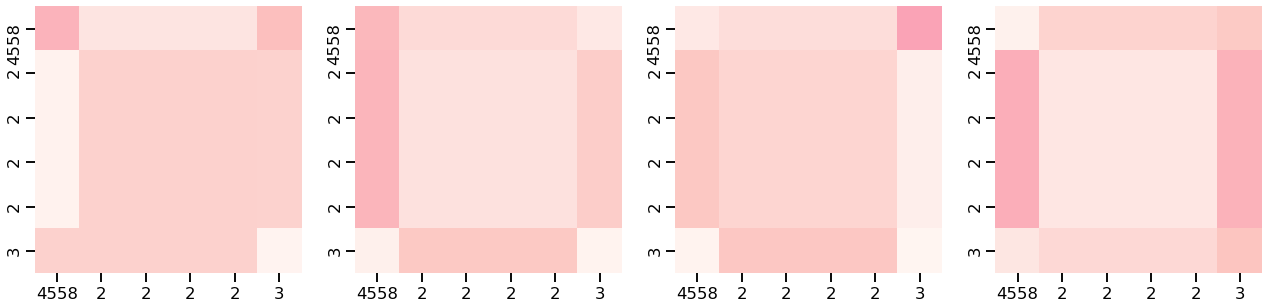

Encoder Layer 2


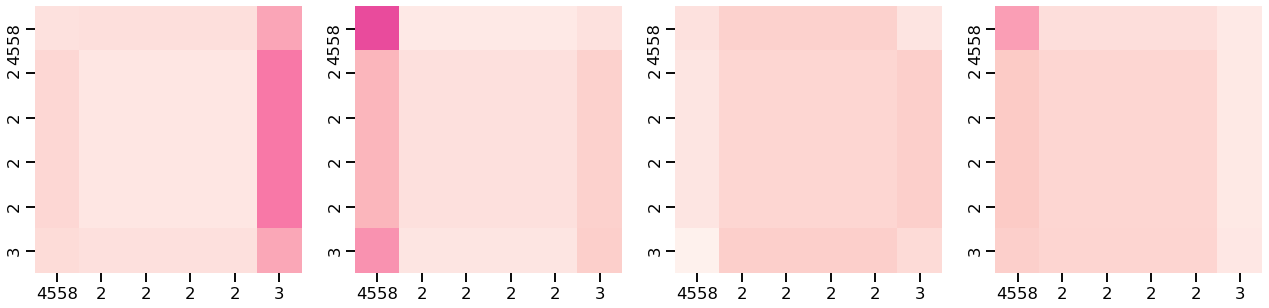



Ejemplo de tweet con label  denying  y Tw_id  765171900683161601
Encoder Layer 1


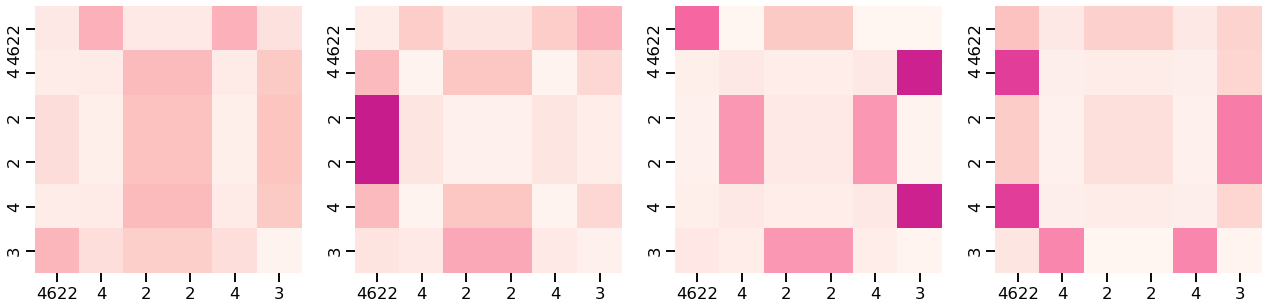

Encoder Layer 2


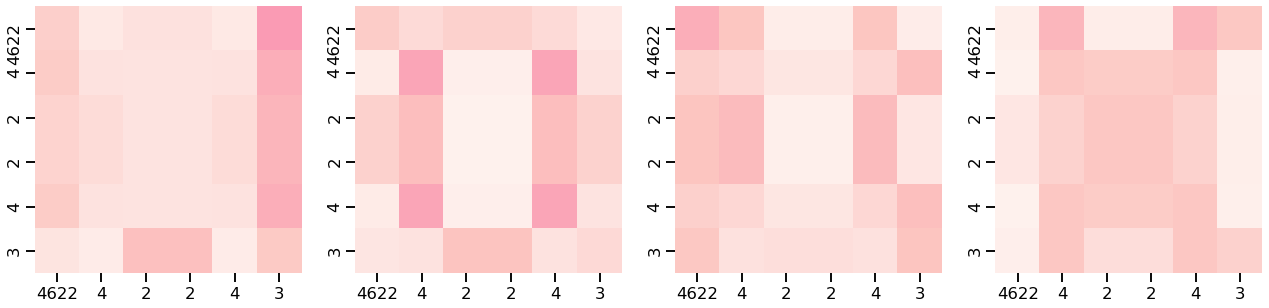



Ejemplo de tweet con label  questioning  y Tw_id  524948710942588928
Encoder Layer 1


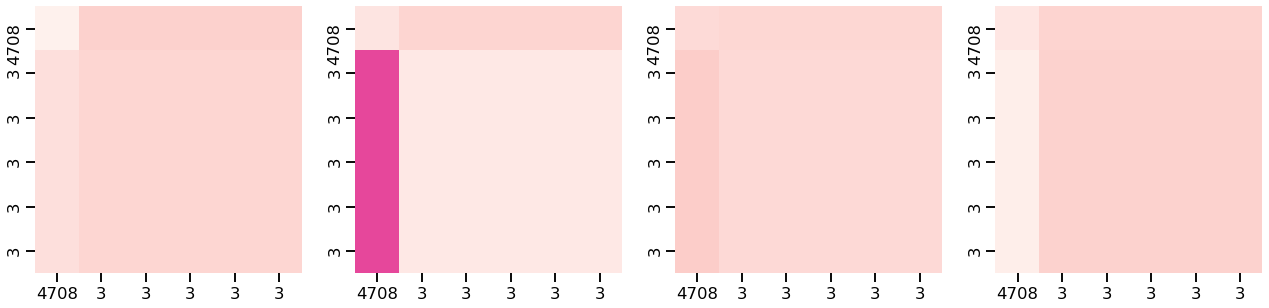

Encoder Layer 2


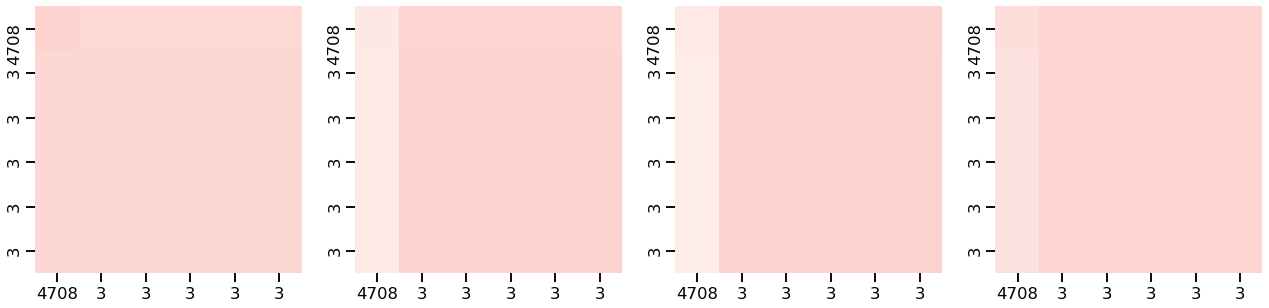

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 15
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.135 	F-macro_val: 0.127
Epoch 10 	acc_val: 0.642 	F-macro_val: 0.520
Epoch 20 	acc_val: 0.656 	F-macro_val: 0.531
Testing run # 15
SE TUVIERON QUE REPETIR 3 EJEMPLOS


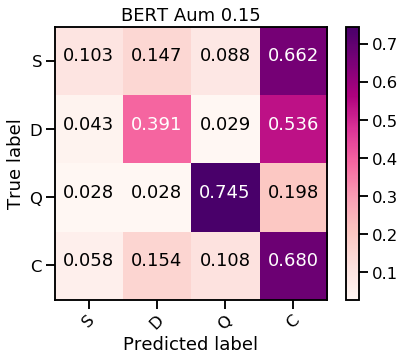

Test_ acc: 0.6287952987267384
Test_ f1 none: [0.111 0.236 0.57  0.75 ]
Test_ f1 macro: 0.4169176733038888
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 16
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.240 	F-macro_val: 0.162
Epoch 10 	acc_val: 0.625 	F-macro_val: 0.472
Epoch 20 	acc_val: 0.656 	F-macro_val: 0.482
Testing run # 16
SE TUVIERON QUE REPETIR 3 EJEMPLOS


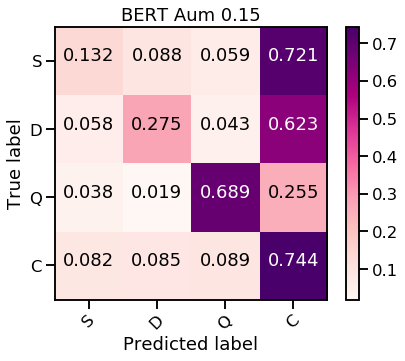

Test_ acc: 0.6660137120470128
Test_ f1 none: [0.121 0.235 0.573 0.785]
Test_ f1 macro: 0.4281187838745958
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 17
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.108 	F-macro_val: 0.090
Epoch 10 	acc_val: 0.642 	F-macro_val: 0.488
Epoch 20 	acc_val: 0.642 	F-macro_val: 0.489
Testing run # 17
SE TUVIERON QUE REPETIR 3 EJEMPLOS


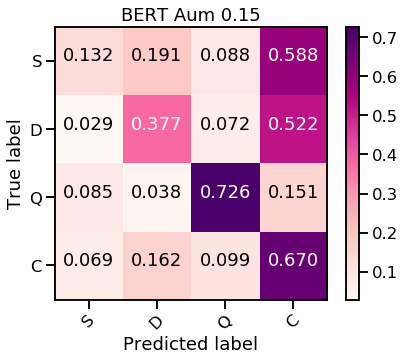

Test_ acc: 0.6199804113614104
Test_ f1 none: [0.127 0.218 0.568 0.749]
Test_ f1 macro: 0.41565375172972185
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 18
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.226 	F-macro_val: 0.144
Epoch 10 	acc_val: 0.694 	F-macro_val: 0.554
Epoch 20 	acc_val: 0.701 	F-macro_val: 0.543
Testing run # 18
SE TUVIERON QUE REPETIR 3 EJEMPLOS


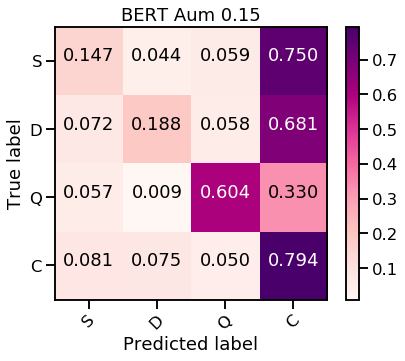

Test_ acc: 0.6904995102840352
Test_ f1 none: [0.132 0.181 0.59  0.808]
Test_ f1 macro: 0.4275919346766319
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 19
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.101 	F-macro_val: 0.091
Epoch 10 	acc_val: 0.698 	F-macro_val: 0.549
Epoch 20 	acc_val: 0.701 	F-macro_val: 0.534
Testing run # 19
SE TUVIERON QUE REPETIR 3 EJEMPLOS


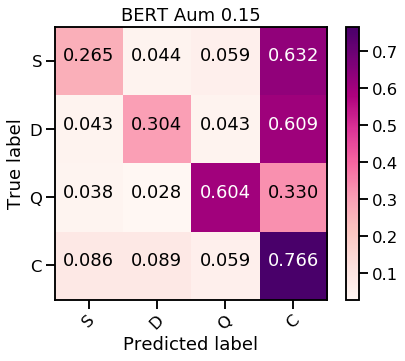

Test_ acc: 0.6846229187071499
Test_ f1 none: [0.225 0.255 0.574 0.798]
Test_ f1 macro: 0.46284864624962685


Ejemplo de tweet con label  commenting  y Tw_id  544295899585732609
Encoder Layer 1


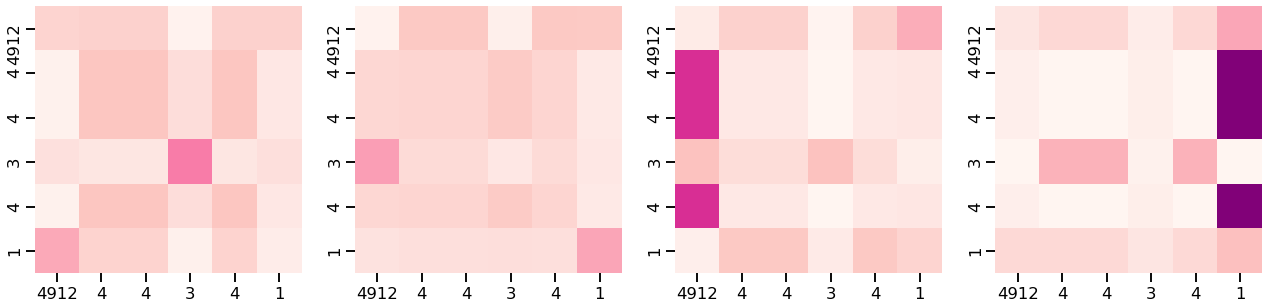

Encoder Layer 2


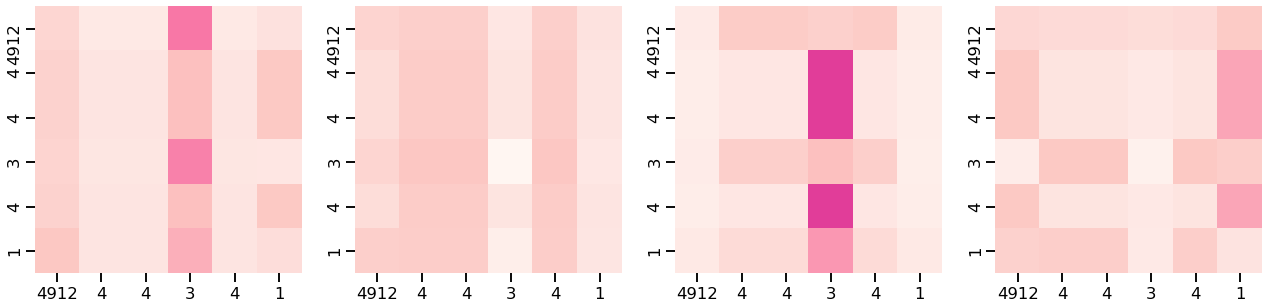



Ejemplo de tweet con label  support  y Tw_id  774992054883540992
Encoder Layer 1


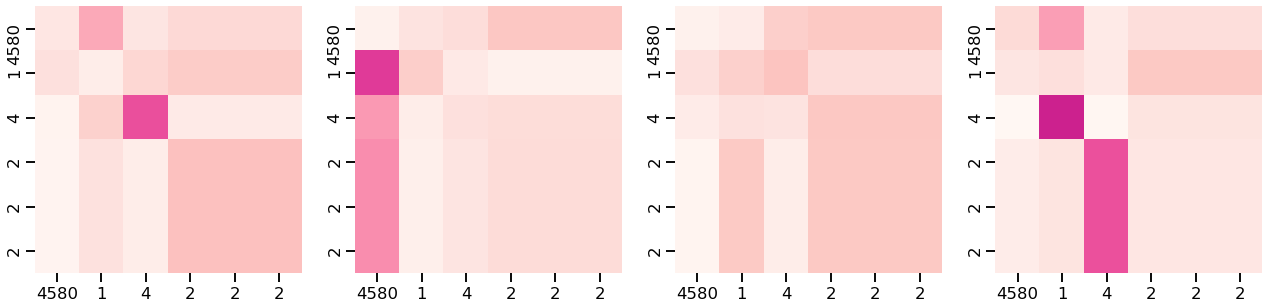

Encoder Layer 2


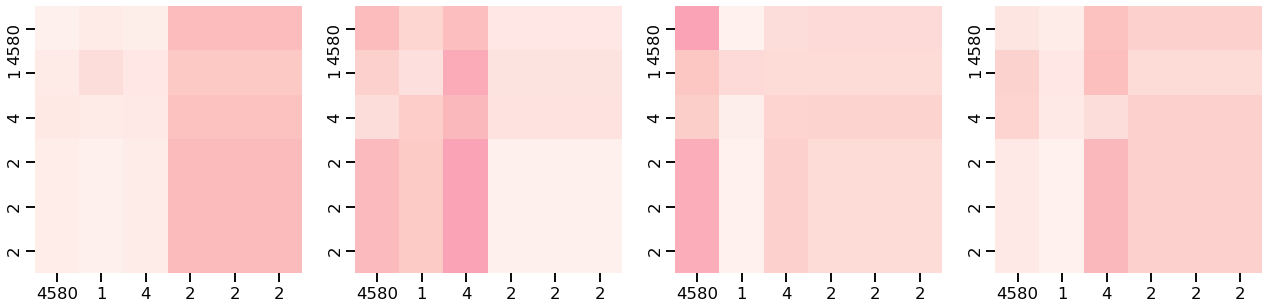



Ejemplo de tweet con label  denying  y Tw_id  764944029922590720
Encoder Layer 1


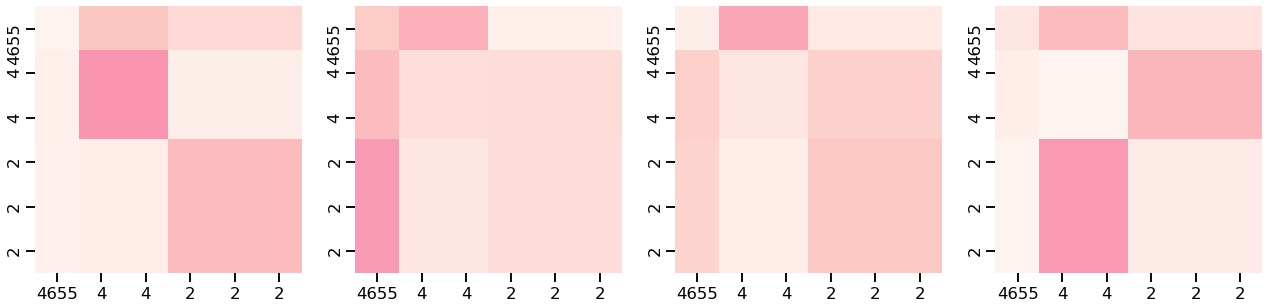

Encoder Layer 2


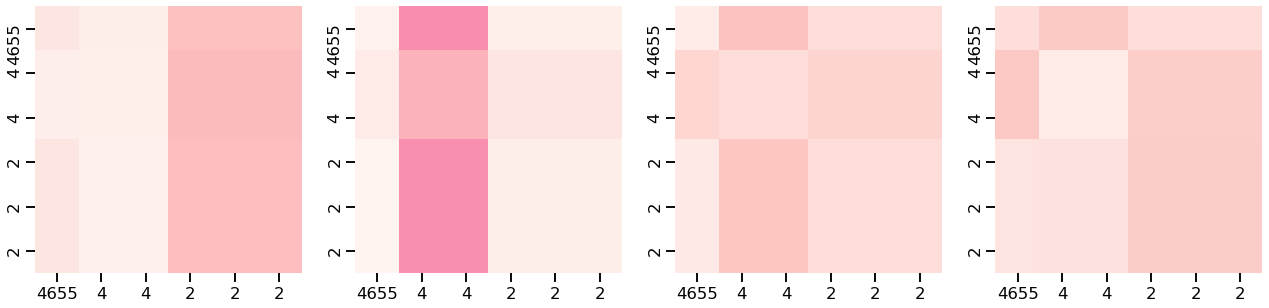



Ejemplo de tweet con label  questioning  y Tw_id  581363347041460224
Encoder Layer 1


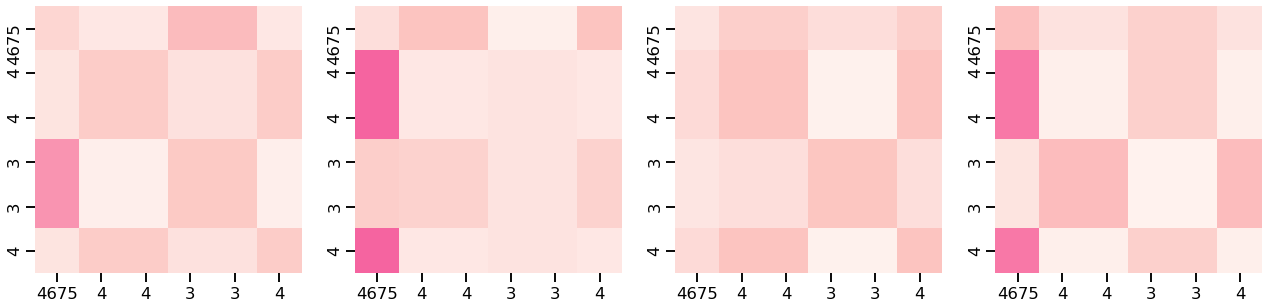

Encoder Layer 2


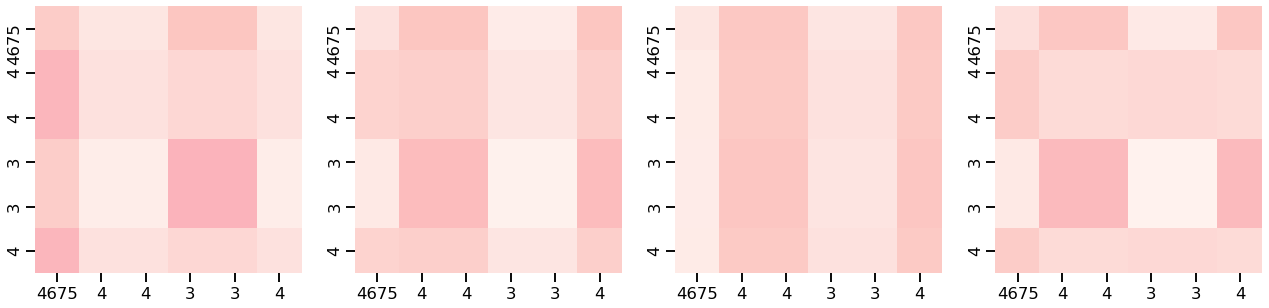

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 20
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.087 	F-macro_val: 0.075
Epoch 10 	acc_val: 0.663 	F-macro_val: 0.541
Epoch 20 	acc_val: 0.670 	F-macro_val: 0.525
Testing run # 20
SE TUVIERON QUE REPETIR 3 EJEMPLOS


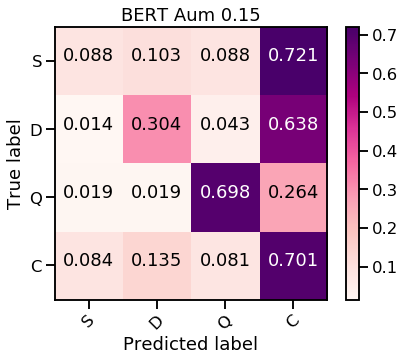

Test_ acc: 0.6327130264446621
Test_ f1 none: [0.085 0.206 0.587 0.755]
Test_ f1 macro: 0.40813465698141194


In [32]:
best_50, all_accs_50, all_fno_50, all_ma_50, all_cm_50 =train_transformer(0.5, 30, path_a, path_m, "RdPu")

In [33]:
print ("best_50", best_50)
print ("all_accs_50", all_accs_50)
print ("all_fno_50", all_fno_50)
print ("all_ma_50", all_ma_50)

best_50 {'F_ma': 0.46284864624962685, 'Run': 19}
all_accs_50 [0.6415279138099902, 0.6640548481880509, 0.6474045053868757, 0.6101860920666013, 0.6229187071498531, 0.6679725759059746, 0.623898139079334, 0.6444662095984329, 0.6082272282076395, 0.67384916748286, 0.6591576885406464, 0.633692458374143, 0.6591576885406464, 0.6856023506366308, 0.6287952987267384, 0.6660137120470128, 0.6199804113614104, 0.6904995102840352, 0.6846229187071499, 0.6327130264446621]
all_fno_50 [array([0.168, 0.222, 0.584, 0.765]), array([0.109, 0.256, 0.611, 0.783]), array([0.092, 0.241, 0.576, 0.77 ]), array([0.125, 0.218, 0.566, 0.737]), array([0.204, 0.25 , 0.559, 0.745]), array([0.15 , 0.201, 0.629, 0.783]), array([0.203, 0.223, 0.558, 0.746]), array([0.191, 0.25 , 0.611, 0.765]), array([0.101, 0.251, 0.586, 0.732]), array([0.142, 0.275, 0.584, 0.789]), array([0.153, 0.18 , 0.591, 0.78 ]), array([0.097, 0.195, 0.634, 0.757]), array([0.153, 0.262, 0.609, 0.773]), array([0.19 , 0.216, 0.635, 0.804]), array([0.111

Acc: 0.648 -- deviation: 0.025
F-score: 0.433 -- deviation: 0.016
(0.5) SDQC: 0.14389087498253855 0.2284696113647537 0.5897791212683615 0.7687147808534674


Confusion counts
[[  226.   158.    85.   891.]
 [   70.   447.    89.   774.]
 [   81.    53.  1482.   504.]
 [ 1350.  1869.  1259. 11082.]]


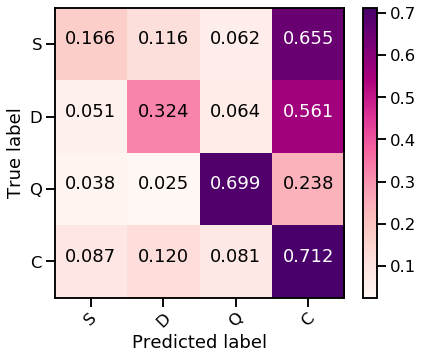

In [34]:
#best_15, all_accs, all_fno, all_ma, all_cm
print ("Acc: %.3f" % np.mean(np.asarray(all_accs_50)), "-- deviation: %.3f" % np.std(np.asarray(all_accs_50)))
print ("F-score: %.3f" % np.mean(np.asarray(all_ma_50)), "-- deviation: %.3f" % np.std(np.asarray(all_ma_50)))
np.set_printoptions(precision=3)
sup=np.mean(np.asarray(all_fno_50)[:,0])
den=np.mean(np.asarray(all_fno_50)[:,1])
que=np.mean(np.asarray(all_fno_50)[:,2])
com=np.mean(np.asarray(all_fno_50)[:,3])

print ("(0.5) SDQC:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in all_cm_50:
    m_temp+=np.asarray(m)
    
print (m_temp)

plot_cm(cm_norma(m_temp),["S","D","Q","C"], "", cmap='RdPu')

## 0.85 -- 10 run

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 1
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.535 	F-macro_val: 0.265
Epoch 10 	acc_val: 0.705 	F-macro_val: 0.516
Epoch 20 	acc_val: 0.708 	F-macro_val: 0.526
Testing run # 1
SE TUVIERON QUE REPETIR 3 EJEMPLOS


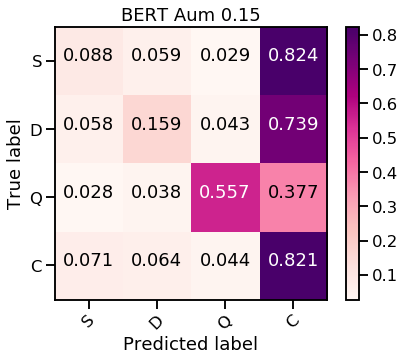

Test_ acc: 0.7002938295788442
Test_ f1 none: [0.088 0.159 0.578 0.817]
Test_ f1 macro: 0.4108056265984654


Ejemplo de tweet con label  commenting  y Tw_id  767728097928052736
Encoder Layer 1


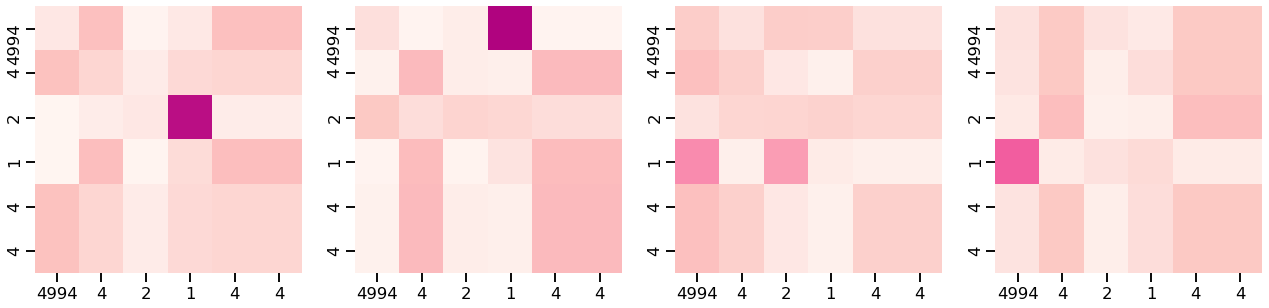

Encoder Layer 2


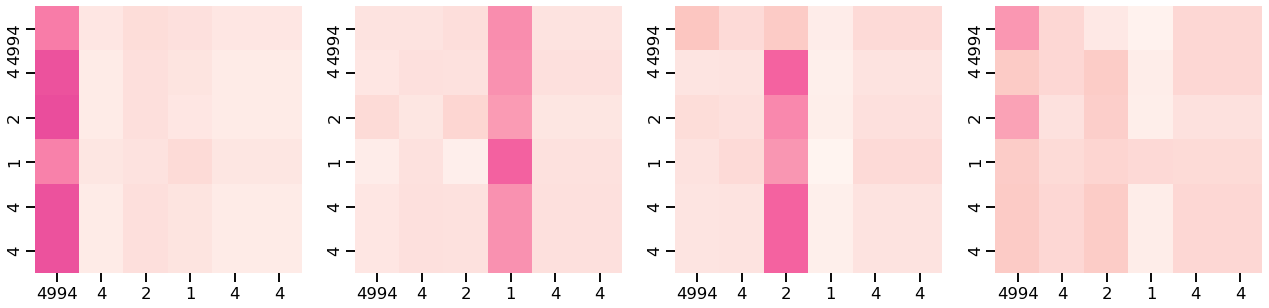



Ejemplo de tweet con label  support  y Tw_id  544275255163125760
Encoder Layer 1


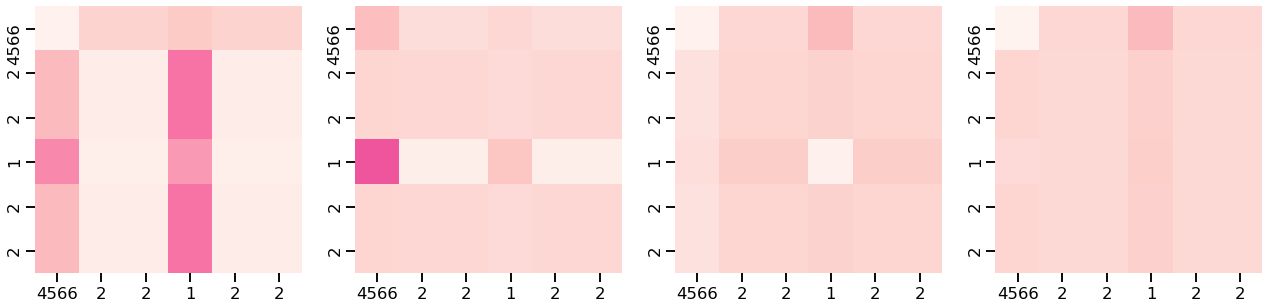

Encoder Layer 2


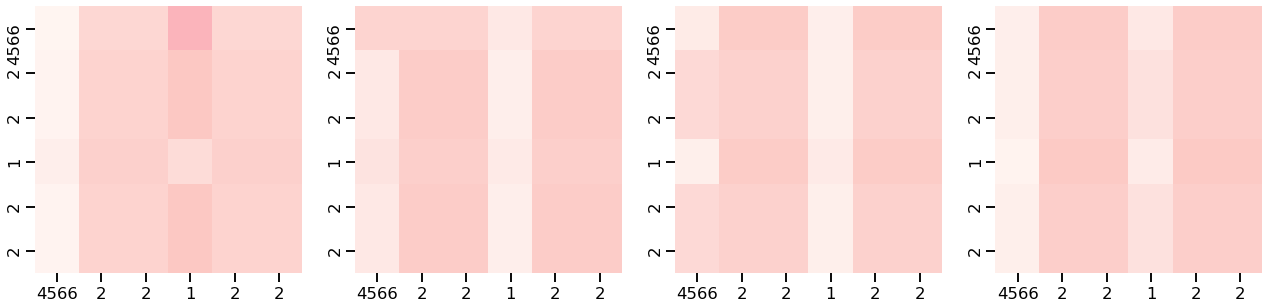



Ejemplo de tweet con label  denying  y Tw_id  764958204493176832
Encoder Layer 1


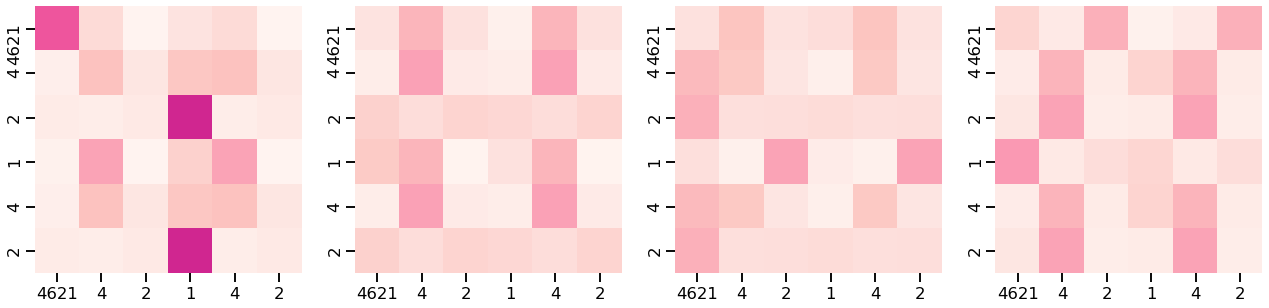

Encoder Layer 2


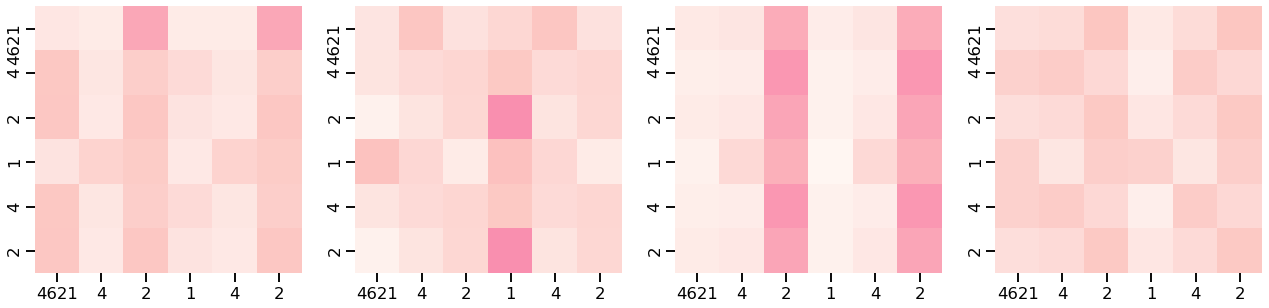



Ejemplo de tweet con label  questioning  y Tw_id  768313868175089664
Encoder Layer 1


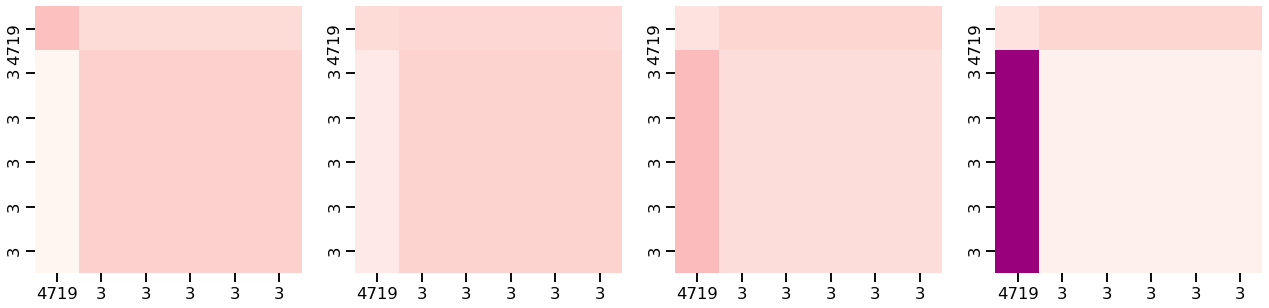

Encoder Layer 2


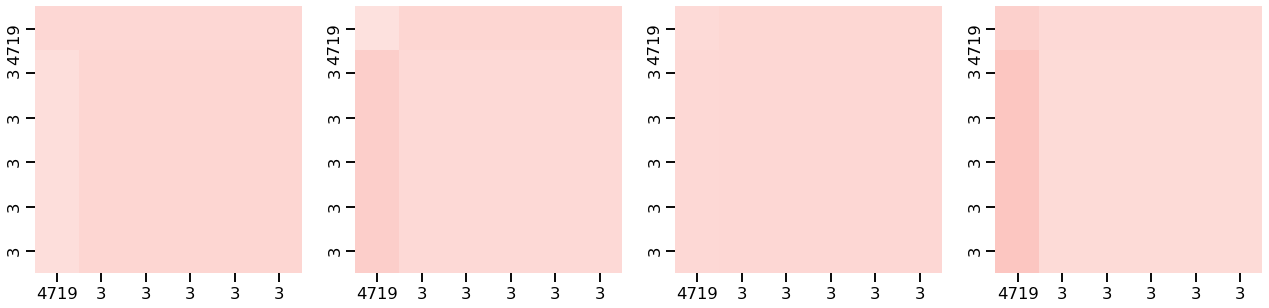

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 2
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.226 	F-macro_val: 0.139
Epoch 10 	acc_val: 0.681 	F-macro_val: 0.502
Epoch 20 	acc_val: 0.688 	F-macro_val: 0.501
Testing run # 2
SE TUVIERON QUE REPETIR 3 EJEMPLOS


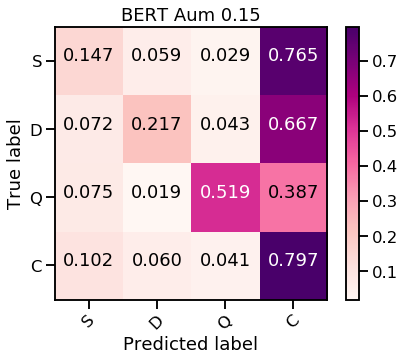

Test_ acc: 0.6856023506366308
Test_ f1 none: [0.118 0.219 0.556 0.807]
Test_ f1 macro: 0.4247367861688918


Ejemplo de tweet con label  commenting  y Tw_id  770234243356233728
Encoder Layer 1


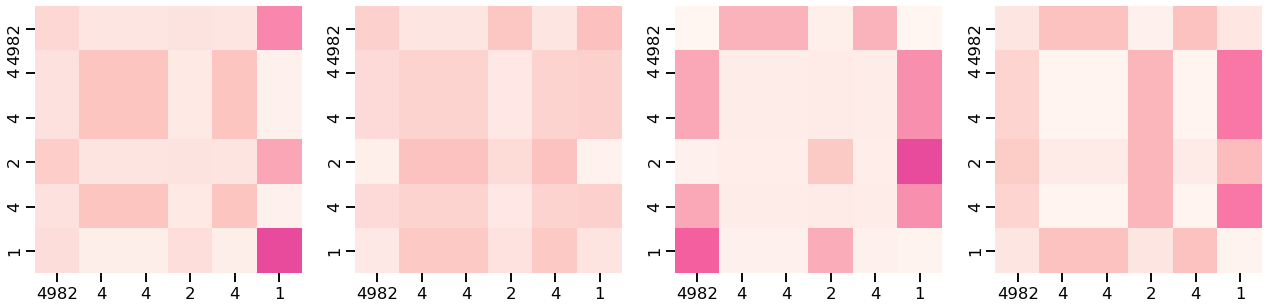

Encoder Layer 2


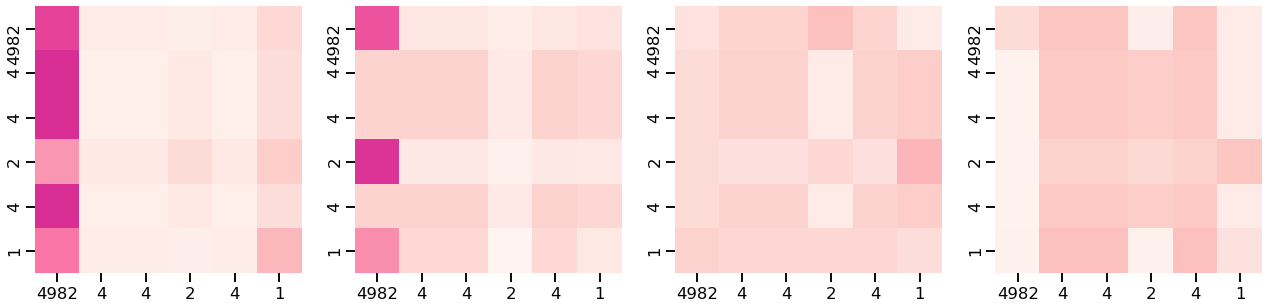



Ejemplo de tweet con label  support  y Tw_id  498298019045847040
Encoder Layer 1


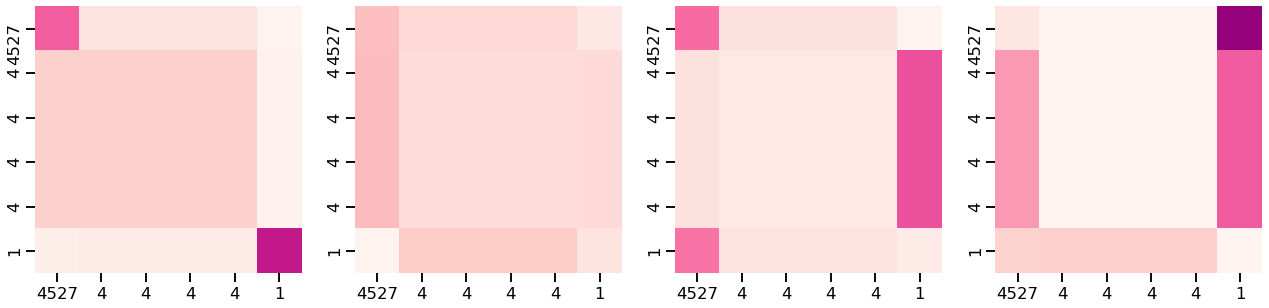

Encoder Layer 2


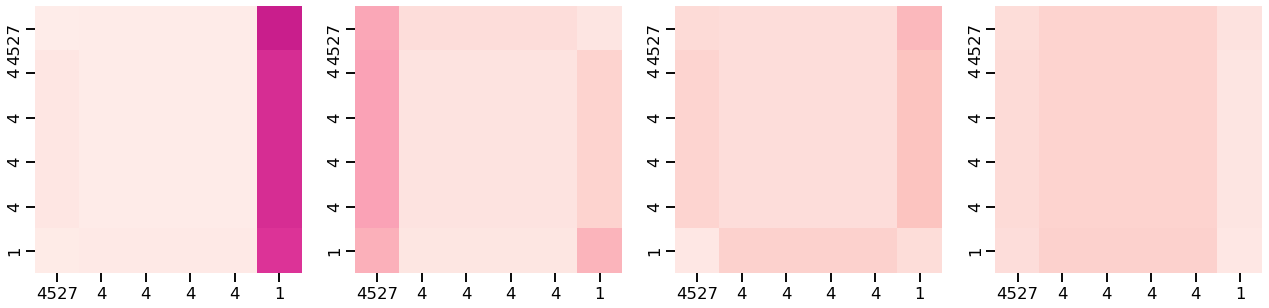



Ejemplo de tweet con label  denying  y Tw_id  770304212844613632
Encoder Layer 1


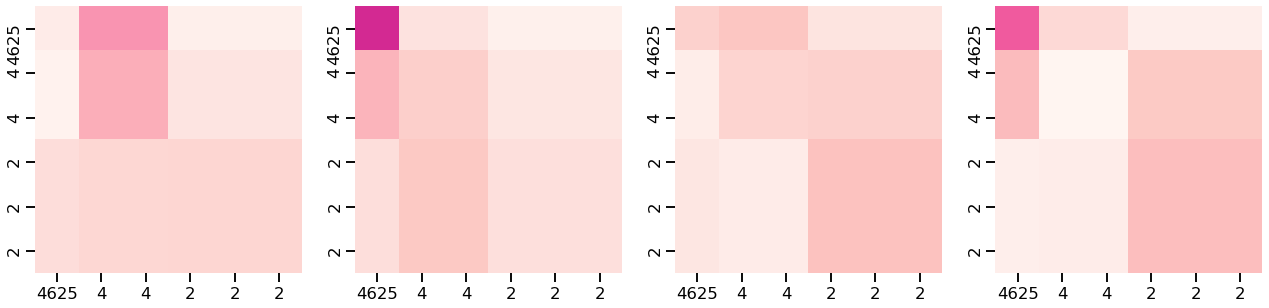

Encoder Layer 2


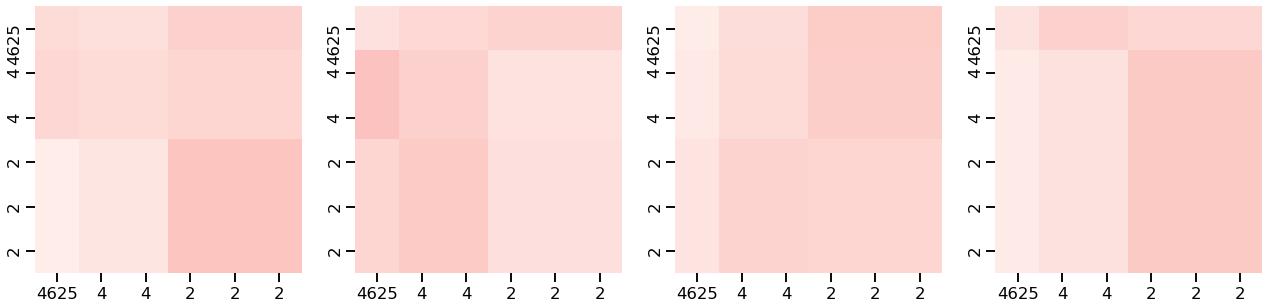



Ejemplo de tweet con label  questioning  y Tw_id  553561563710644224
Encoder Layer 1


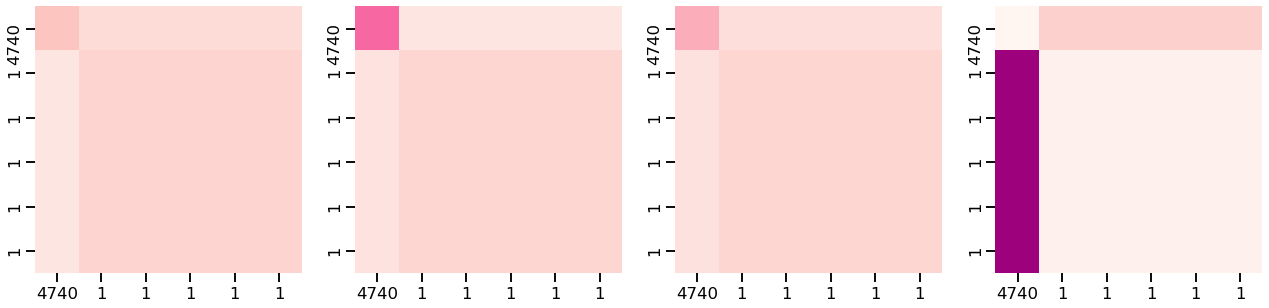

Encoder Layer 2


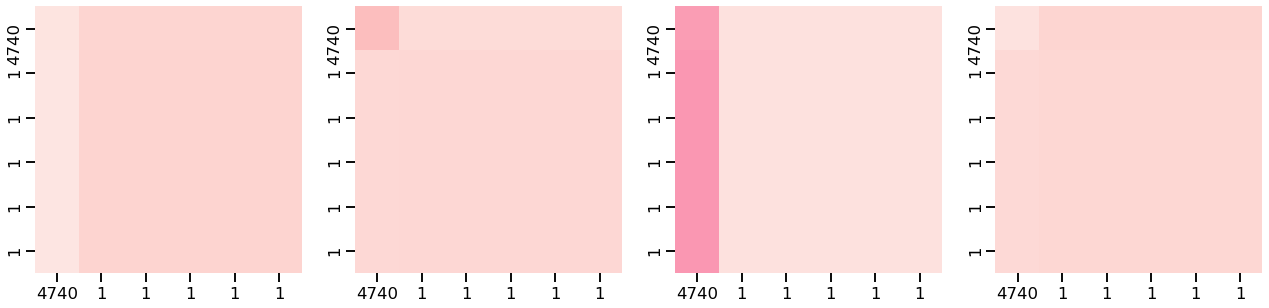

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 3
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.219 	F-macro_val: 0.181
Epoch 10 	acc_val: 0.663 	F-macro_val: 0.515
Epoch 20 	acc_val: 0.681 	F-macro_val: 0.519
Testing run # 3
SE TUVIERON QUE REPETIR 3 EJEMPLOS


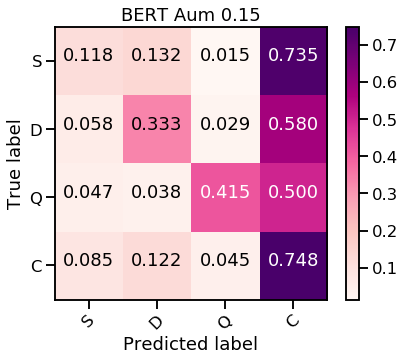

Test_ acc: 0.643486777668952
Test_ f1 none: [0.106 0.23  0.468 0.774]
Test_ f1 macro: 0.3946241172720081
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 4
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.253 	F-macro_val: 0.172
Epoch 10 	acc_val: 0.681 	F-macro_val: 0.512
Epoch 20 	acc_val: 0.684 	F-macro_val: 0.518
Testing run # 4
SE TUVIERON QUE REPETIR 3 EJEMPLOS


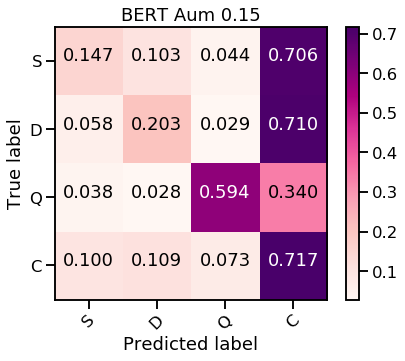

Test_ acc: 0.6317335945151812
Test_ f1 none: [0.122 0.157 0.545 0.76 ]
Test_ f1 macro: 0.3961024030669733
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 5
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.236 	F-macro_val: 0.177
Epoch 10 	acc_val: 0.691 	F-macro_val: 0.513
Epoch 20 	acc_val: 0.688 	F-macro_val: 0.515
Testing run # 5
SE TUVIERON QUE REPETIR 3 EJEMPLOS


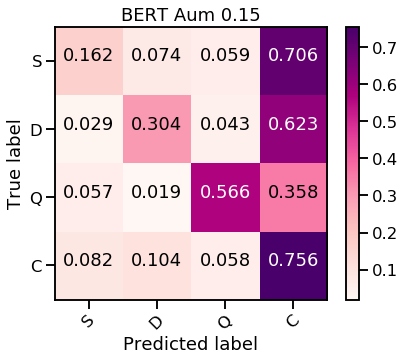

Test_ acc: 0.6660137120470128
Test_ f1 none: [0.146 0.236 0.55  0.787]
Test_ f1 macro: 0.42968280239827783


Ejemplo de tweet con label  commenting  y Tw_id  764951944934731776
Encoder Layer 1


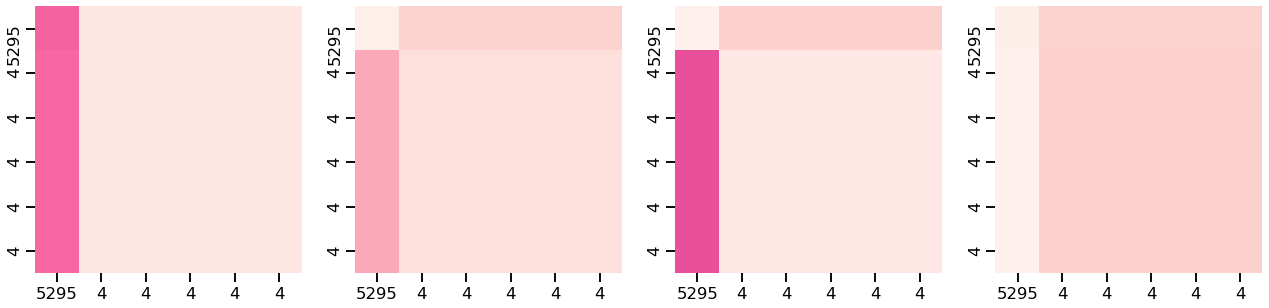

Encoder Layer 2


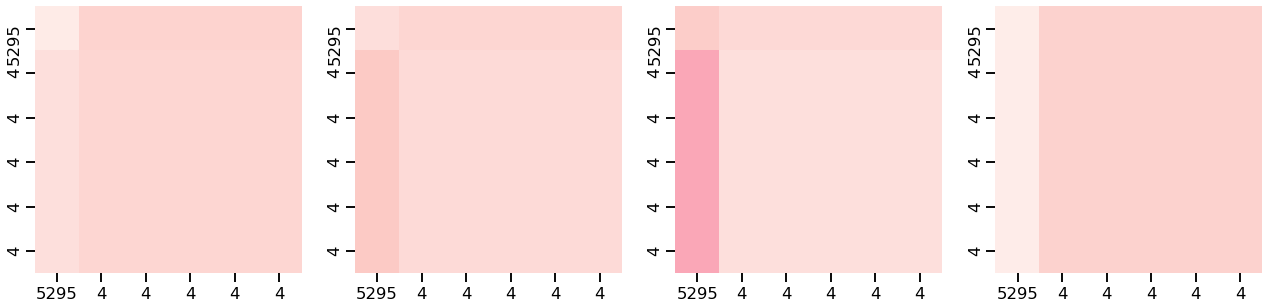



Ejemplo de tweet con label  support  y Tw_id  581290541645635584
Encoder Layer 1


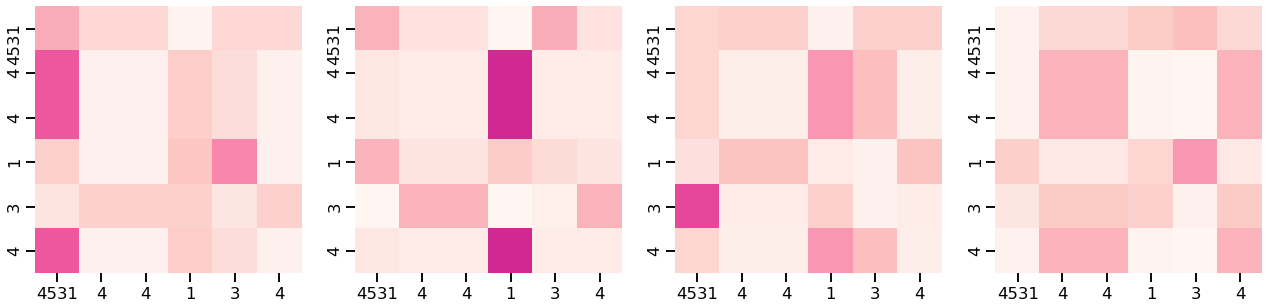

Encoder Layer 2


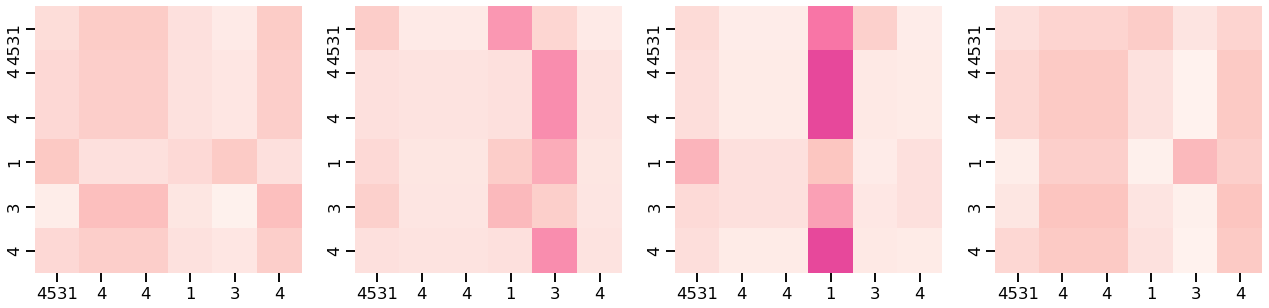



Ejemplo de tweet con label  denying  y Tw_id  769989019627290624
Encoder Layer 1


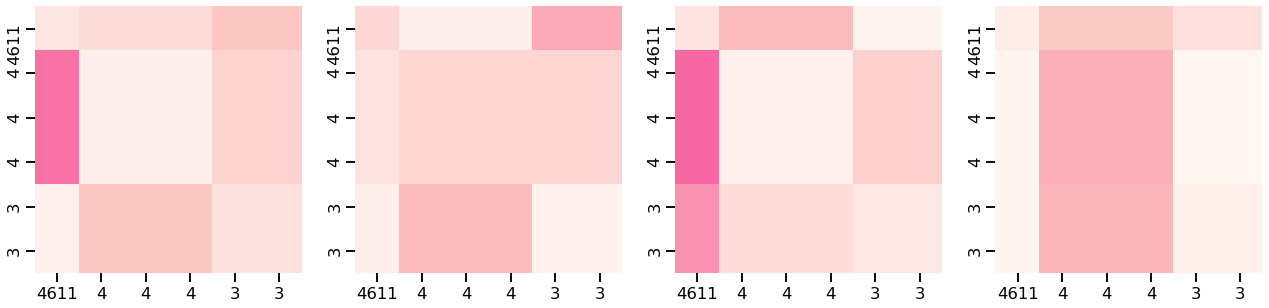

Encoder Layer 2


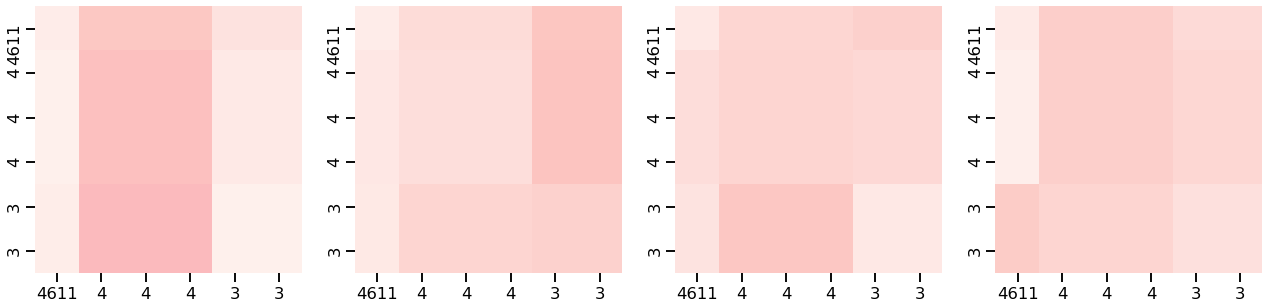



Ejemplo de tweet con label  questioning  y Tw_id  767727443398451200
Encoder Layer 1


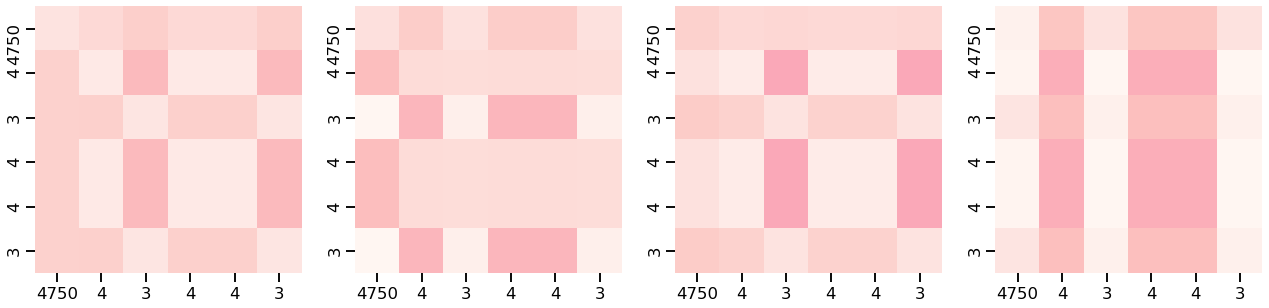

Encoder Layer 2


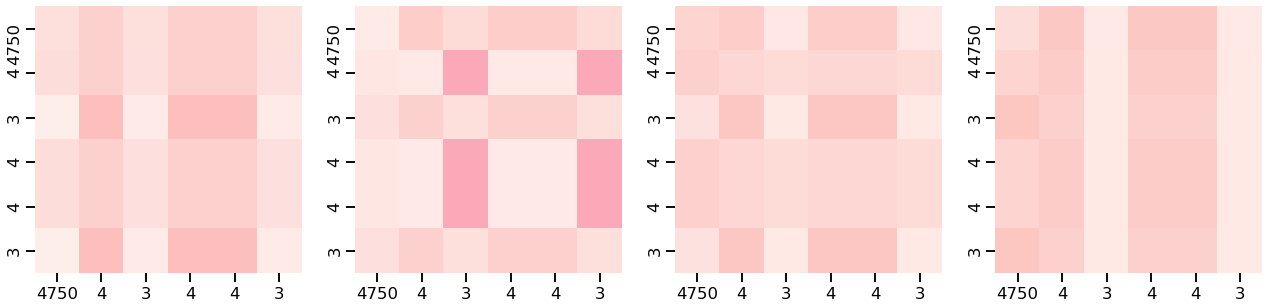

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 6
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.177 	F-macro_val: 0.147
Epoch 10 	acc_val: 0.667 	F-macro_val: 0.523
Epoch 20 	acc_val: 0.667 	F-macro_val: 0.519
Testing run # 6
SE TUVIERON QUE REPETIR 3 EJEMPLOS


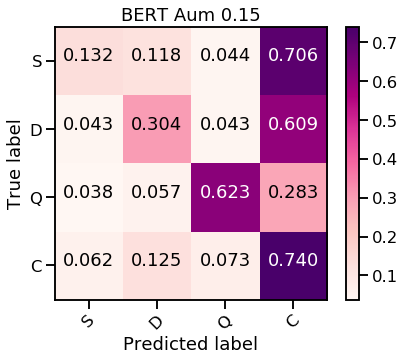

Test_ acc: 0.6581782566111655
Test_ f1 none: [0.136 0.209 0.562 0.782]
Test_ f1 macro: 0.42214194982534137
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 7
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.208 	F-macro_val: 0.154
Epoch 10 	acc_val: 0.694 	F-macro_val: 0.545
Epoch 20 	acc_val: 0.705 	F-macro_val: 0.540
Testing run # 7
SE TUVIERON QUE REPETIR 3 EJEMPLOS


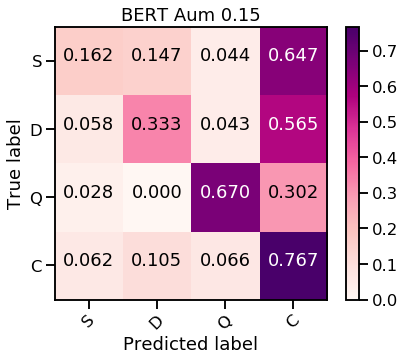

Test_ acc: 0.6875612144955926
Test_ f1 none: [0.164 0.25  0.607 0.801]
Test_ f1 macro: 0.4555897482986033


Ejemplo de tweet con label  commenting  y Tw_id  775084898595987457
Encoder Layer 1


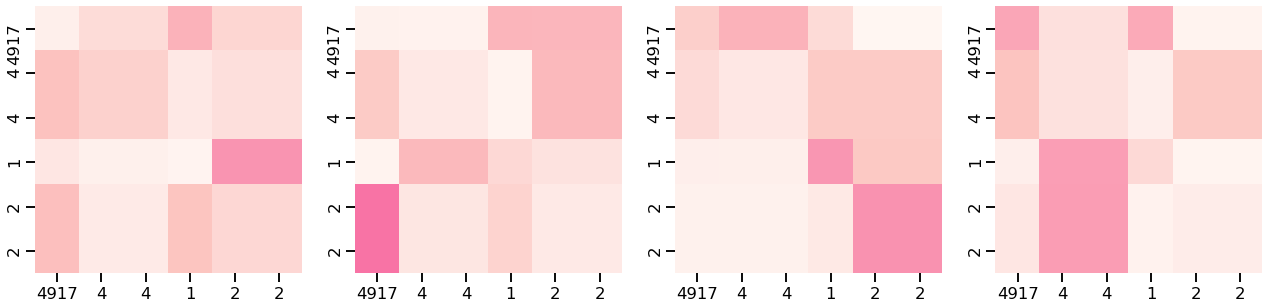

Encoder Layer 2


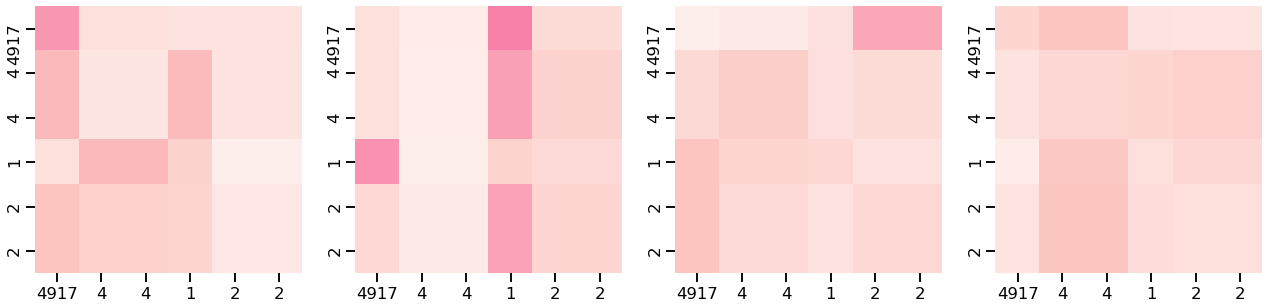



Ejemplo de tweet con label  support  y Tw_id  775075528554389504
Encoder Layer 1


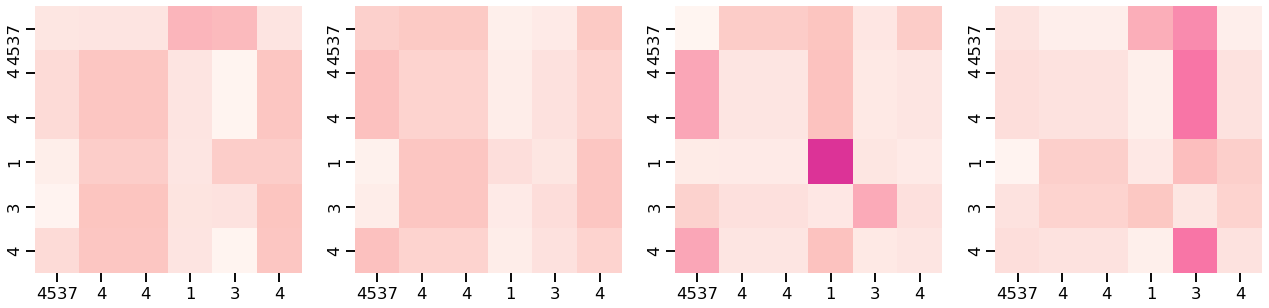

Encoder Layer 2


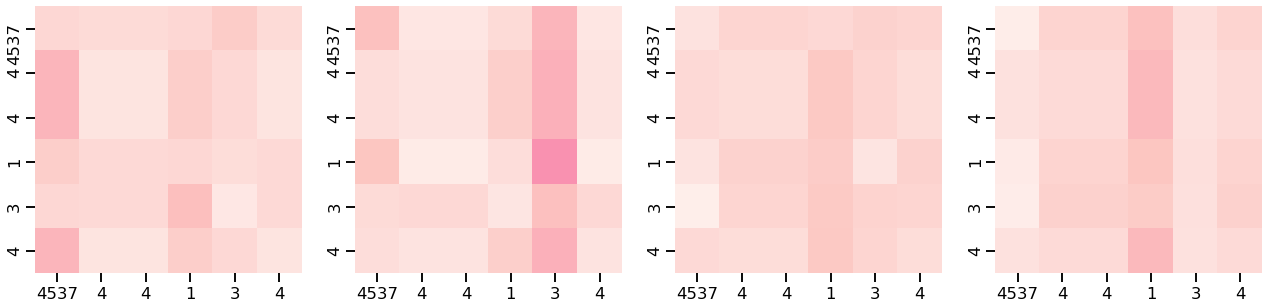



Ejemplo de tweet con label  denying  y Tw_id  580354345935486976
Encoder Layer 1


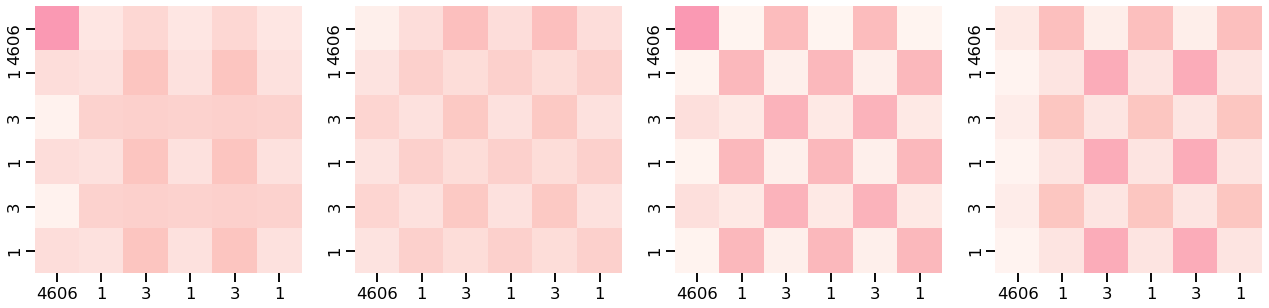

Encoder Layer 2


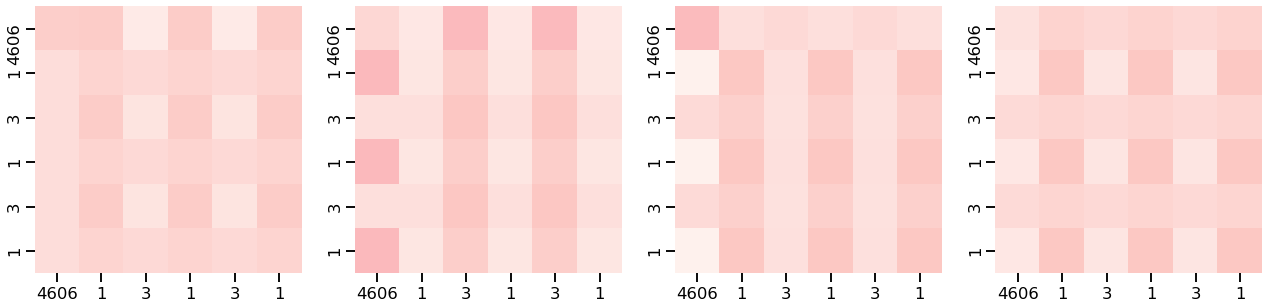



Ejemplo de tweet con label  questioning  y Tw_id  580359656750653441
Encoder Layer 1


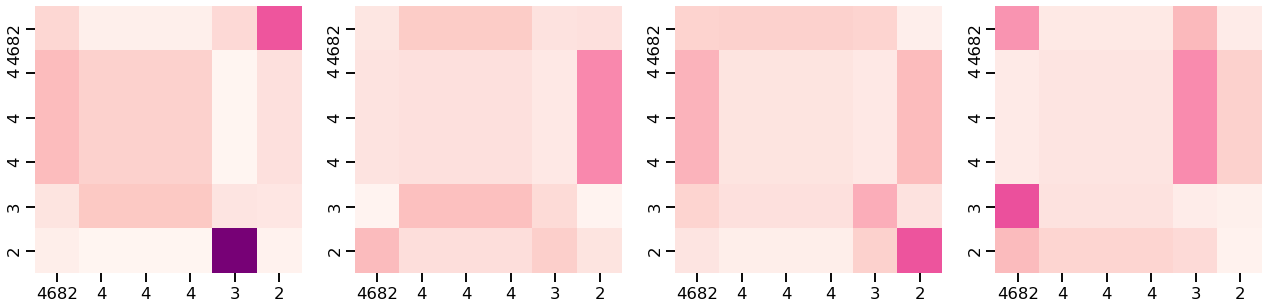

Encoder Layer 2


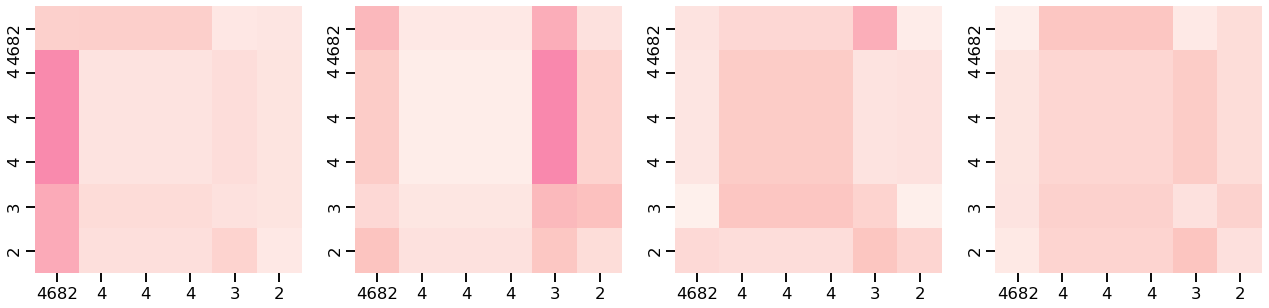

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 8
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.198 	F-macro_val: 0.152
Epoch 10 	acc_val: 0.649 	F-macro_val: 0.484
Epoch 20 	acc_val: 0.660 	F-macro_val: 0.480
Testing run # 8
SE TUVIERON QUE REPETIR 3 EJEMPLOS


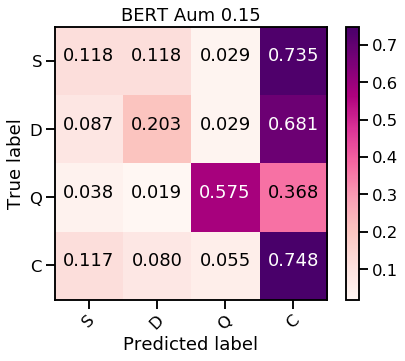

Test_ acc: 0.6513222331047992
Test_ f1 none: [0.09  0.181 0.57  0.778]
Test_ f1 macro: 0.40480224144259924
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 9
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.135 	F-macro_val: 0.150
Epoch 10 	acc_val: 0.719 	F-macro_val: 0.536
Epoch 20 	acc_val: 0.729 	F-macro_val: 0.535
Testing run # 9
SE TUVIERON QUE REPETIR 3 EJEMPLOS


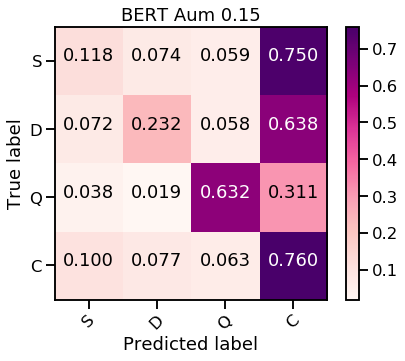

Test_ acc: 0.6679725759059746
Test_ f1 none: [0.098 0.211 0.583 0.79 ]
Test_ f1 macro: 0.4202184197401837
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 10
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.160 	F-macro_val: 0.139
Epoch 10 	acc_val: 0.688 	F-macro_val: 0.526
Epoch 20 	acc_val: 0.681 	F-macro_val: 0.535
Testing run # 10
SE TUVIERON QUE REPETIR 3 EJEMPLOS


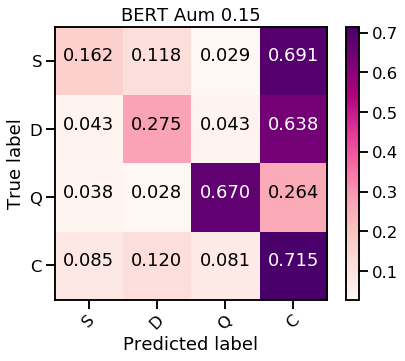

Test_ acc: 0.643486777668952
Test_ f1 none: [0.145 0.198 0.58  0.765]
Test_ f1 macro: 0.4218896226808541


In [36]:
### solo 10!! 
best_85, all_accs_85, all_fno_85, all_ma_85, all_cm_85 =train_transformer(0.85, 30, path_a, path_m, "RdPu", xfrom=1, xto=10)

In [37]:
print ("best_85", best_85)
print ("all_accs_85", all_accs_85)
print ("all_fno_85", all_fno_85)
print ("all_ma_85", all_ma_85)

best_85 {'F_ma': 0.4555897482986033, 'Run': 7}
all_accs_85 [0.7002938295788442, 0.6856023506366308, 0.643486777668952, 0.6317335945151812, 0.6660137120470128, 0.6581782566111655, 0.6875612144955926, 0.6513222331047992, 0.6679725759059746, 0.643486777668952]
all_fno_85 [array([0.088, 0.159, 0.578, 0.817]), array([0.118, 0.219, 0.556, 0.807]), array([0.106, 0.23 , 0.468, 0.774]), array([0.122, 0.157, 0.545, 0.76 ]), array([0.146, 0.236, 0.55 , 0.787]), array([0.136, 0.209, 0.562, 0.782]), array([0.164, 0.25 , 0.607, 0.801]), array([0.09 , 0.181, 0.57 , 0.778]), array([0.098, 0.211, 0.583, 0.79 ]), array([0.145, 0.198, 0.58 , 0.765])]
all_ma_85 [0.4108056265984654, 0.4247367861688918, 0.3946241172720081, 0.3961024030669733, 0.42968280239827783, 0.42214194982534137, 0.4555897482986033, 0.40480224144259924, 0.4202184197401837, 0.4218896226808541]


Acc: 0.664 -- deviation: 0.021
F-score: 0.418 -- deviation: 0.017
(0.85) SDQC: 0.12133237739673985 0.20497001866382053 0.5598819020366402 0.7860531888996786


Confusion counts
[[  92.   68.   26.  494.]
 [  40.  177.   28.  445.]
 [  45.   28.  617.  370.]
 [ 673.  752.  466. 5889.]]


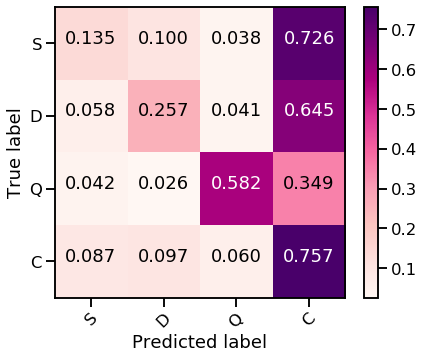

In [38]:
#best_15, all_accs, all_fno, all_ma, all_cm
print ("Acc: %.3f" % np.mean(np.asarray(all_accs_85)), "-- deviation: %.3f" % np.std(np.asarray(all_accs_85)))
print ("F-score: %.3f" % np.mean(np.asarray(all_ma_85)), "-- deviation: %.3f" % np.std(np.asarray(all_ma_85)))
np.set_printoptions(precision=3)
sup=np.mean(np.asarray(all_fno_85)[:,0])
den=np.mean(np.asarray(all_fno_85)[:,1])
que=np.mean(np.asarray(all_fno_85)[:,2])
com=np.mean(np.asarray(all_fno_85)[:,3])

print ("(0.85) SDQC:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in all_cm_85:
    m_temp+=np.asarray(m)
    
print (m_temp)

plot_cm(cm_norma(m_temp),["S","D","Q","C"], "", cmap='RdPu')